# Обучение RVector

In [28]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from rvector_module import RVectorModule
from utils import PROCESSED_DATA_PATH
from data_module import DataModule
from lightning.pytorch import Trainer
from ray import tune
from ray.tune import Tuner, TuneConfig
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler
from ray.train.lightning import RayTrainReportCallback
from typing import Any
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2

print(f'[The device is {device}]')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[The device is cpu]


In [2]:
model_config = {
    "resnet": {
        "stages": [
            {"in_channels": 32,  "num_channels": 32,  "blocks": 3, "stride": 1},
            {"in_channels": 32,  "num_channels": 64,  "blocks": 4, "stride": 2},
            {"in_channels": 64,  "num_channels": 128, "blocks": 6, "stride": 2},
            {"in_channels": 128, "num_channels": 256, "blocks": 3, "stride": 2},
        ],
        "dropout_prob": 0
    }
}


In [ ]:
def train_func(config: dict[str, Any]) -> None:
    rvector_cfg = model_config.copy()
    rvector_cfg['resnet']['dropout_prob'] = config['dropout_prob']
    
    module = RVectorModule(
        config=rvector_cfg,
        lr=config["lr"],
        weight_decay=config["weight_decay"],
        factor=config['factor'],
        label_smoothing=config['label_smoothing']
    )
    datamodule = DataModule(PROCESSED_DATA_PATH)

    trainer = Trainer(
        max_epochs=10,
        callbacks=[
            EarlyStopping(monitor="val_auc_pr", patience=5, mode="max"),
            RayTrainReportCallback(),
        ],
    )
    trainer.fit(module, datamodule=datamodule)


tuner = Tuner(
    train_func,
    tune_config=TuneConfig(
        metric="val_auc_pr",   # отслеживаем именно эту метрику
        mode="max",            # хотим максимизировать Average Precision
        scheduler=ASHAScheduler(
            max_t=20,          # увеличили лимит эпох до 20
            grace_period=3,    # дали пробам минимум 3 эпохи
            reduction_factor=2,
        ),
        search_alg=OptunaSearch(),  
        num_samples=30,             # сколько разных конфигураций запустить
        max_concurrent_trials=2,
    ),
    param_space={
        "lr": tune.loguniform(1e-6, 1e-1),           
        "weight_decay": tune.loguniform(1e-7, 1e-2), 
        "dropout_prob": tune.uniform(0.0, 0.5),      
        "factor": tune.uniform(0.1, 0.9),           
        "label_smoothing": tune.uniform(0.01, 0.3),  
        "batch_size": tune.choice([16, 32, 64]),    
    },
)

results: tune.ResultGrid = tuner.fit()

best_result = results.get_best_result()
print('Best AUC-PR:', best_result)

(train_func pid=1687) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=1687)   _log_deprecation_warning(
(train_func pid=1687) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=1687) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


(train_func pid=1687) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s]                           


(train_func pid=1691) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=1691)   _log_deprecation_warning(
(train_func pid=1691) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=1691) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  92%|█████████▏| 97/106 [00:40<00:03,  2.38it/s, v_num=0]
(train_func pid=1687) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  95%|█████████▌| 101/106 [00:41<00:02,  2.41it/s, v_num=0]
(train_func pid=1687) 
Epoch 0:  97%|█████████▋| 103/106 [00:42<00:01,  2.42it/s, v_num=0]
(train_func pid=1687) 
Epoch 0:  98%|█████████▊| 104/106 [00:42<00:00,  2.43it/s, v_num=0]
(train_func pid=1687) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.37it/s]
(train_func pid=1687) 
Epoch 0:  99%|█████████▉| 105/106 [00:43<00:00,  2.44it/s, v_num=0]
(train_func pid=1687) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.01it/s]
(train_func pid=1687) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.58it/s]
(train_func pid=1687) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:01<00:02,  7.54it/s]
(train_func pid=1687) 
Validation DataLoader 0:  37%|███▋      | 10/27 [00:01<00:02,  7.94it

(train_func pid=1687) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=1687)   _log_deprecation_warning(
(train_func pid=1687) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=1687)   _log_deprecation_warning(
(train_

Epoch 1:   0%|          | 0/106 [00:00<?, ?it/s, v_num=0]          
(train_func pid=1691) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=1691) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1691) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:14,  1.84it/s]
(train_func pid=1691) 
Epoch 1:   1%|          | 1/106 [00:03<06:26,  0.27it/s, v_num=0]
(train_func pid=1691) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.83it/s]
(train_func pid=1691) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.52it/s]
(train_func pid=1691) 
Epoch 1:   2%|▏         | 2/106 [00:04<03:29,  0.50it/s, v_num=0]
(train_func pid=1691) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.36it/s]
(train_func pid=1691) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  6.18it/s]
(train_func pid=1691) 
Epoch 1:   3%|▎         | 3/106 [00:04<02:36,  0.66it/s, v_num=0]
(train_func pid=1691) 
Epoch 1:   

(train_func pid=1691) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=1691)   _log_deprecation_warning( [repeated 2x across cluster]
(train_func pid=1691) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=1691) Checkp

Epoch 1: 100%|██████████| 106/106 [00:38<00:00,  2.78it/s, v_num=0]
(train_func pid=1687) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:  67%|██████▋   | 71/106 [00:28<00:14,  2.48it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=1687) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1687) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.59it/s]
(train_func pid=1687) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.12it/s]
(train_func pid=1687) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  6.04it/s]
(train_func pid=1687) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  6.60it/s]
(train_func pid=1687) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.96it/s]
(train_func pid=1687) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:00<00:02,  7.58it/s]
(train_func pid=1687) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  7.70it/s]
(train_func pi

(train_func pid=1687) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d01f3fe9_1_batch_size=64,dropout_prob=0.4258,factor=0.2900,label_smoothing=0.2882,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-19/checkpoint_000001)


Epoch 1: 100%|██████████| 106/106 [00:40<00:00,  2.64it/s, v_num=0]
(train_func pid=1691) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=1691) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1691) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.72it/s]
(train_func pid=1691) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.43it/s]
(train_func pid=1691) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  6.32it/s]
(train_func pid=1691) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  6.93it/s]
(train_func pid=1691) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  7.22it/s]
(train_func pid=1691) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:02,  7.49it/s]
(train_func pid=1691) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:00<00:02,  7.85it/s]
(train_func pid=1691) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  7.95it/s]
(train_func pid=

(train_func pid=1691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_dd300552_2_batch_size=32,dropout_prob=0.3616,factor=0.2323,label_smoothing=0.0315,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-23/checkpoint_000001)


Epoch 2: 100%|██████████| 106/106 [00:39<00:00,  2.69it/s, v_num=0]
(train_func pid=1687) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=1687) 
Epoch 2:  68%|██████▊   | 72/106 [00:28<00:13,  2.53it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=1687) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:05,  4.65it/s]
(train_func pid=1687) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  6.01it/s]
(train_func pid=1687) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  6.74it/s]
(train_func pid=1687) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  7.31it/s]
(train_func pid=1687) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:02,  7.55it/s]
(train_func pid=1687) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:02,  7.86it/s]
(train_func pid=1687) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:00<00:02,  8.19it/s]
(train_func pid=1687) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:00<0

(train_func pid=1687) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d01f3fe9_1_batch_size=64,dropout_prob=0.4258,factor=0.2900,label_smoothing=0.2882,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-19/checkpoint_000002)


Epoch 2: 100%|██████████| 106/106 [00:39<00:00,  2.66it/s, v_num=0]
(train_func pid=1691) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=1691) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1691) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.79it/s]
(train_func pid=1691) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.36it/s]
(train_func pid=1691) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  6.32it/s]
(train_func pid=1691) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  6.76it/s]
(train_func pid=1691) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  7.16it/s]
(train_func pid=1691) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:02,  7.61it/s]
(train_func pid=1691) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:00<00:02,  7.75it/s]
(train_func pid=1691) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  7.97it/s]
(train_func pid=

(train_func pid=1691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_dd300552_2_batch_size=32,dropout_prob=0.3616,factor=0.2323,label_smoothing=0.0315,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-23/checkpoint_000002)


Epoch 3: 100%|██████████| 106/106 [00:41<00:00,  2.54it/s, v_num=0]
(train_func pid=1687) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3:  65%|██████▌   | 69/106 [00:29<00:15,  2.34it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=1687) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1687) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.87it/s]
(train_func pid=1687) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.27it/s]
(train_func pid=1687) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.90it/s]
(train_func pid=1687) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  6.38it/s]
(train_func pid=1687) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.76it/s]
(train_func pid=1687) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.96it/s]
(train_func pid=1687) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:00<00:02,  7.11it/s]
(train_func pi

(train_func pid=1687) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d01f3fe9_1_batch_size=64,dropout_prob=0.4258,factor=0.2900,label_smoothing=0.2882,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-19/checkpoint_000003)


Epoch 3: 100%|██████████| 106/106 [00:43<00:00,  2.41it/s, v_num=0]
(train_func pid=1691) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4:  17%|█▋        | 18/106 [00:10<00:52,  1.66it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=1691) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1691) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.44it/s]
(train_func pid=1691) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.60it/s]
(train_func pid=1691) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.27it/s]
(train_func pid=1691) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.67it/s]
(train_func pid=1691) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  5.92it/s]
(train_func pid=1691) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.12it/s]
(train_func pid=1691) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.29it/s]
(train_func pi

(train_func pid=1691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_dd300552_2_batch_size=32,dropout_prob=0.3616,factor=0.2323,label_smoothing=0.0315,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-23/checkpoint_000003)


Epoch 4:  64%|██████▍   | 68/106 [00:36<00:20,  1.84it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=1687) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=1687) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1687) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.54it/s]
(train_func pid=1687) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.76it/s]
(train_func pid=1687) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.46it/s]
(train_func pid=1687) 
Epoch 4:  73%|███████▎  | 77/106 [00:39<00:15,  1.93it/s, v_num=0]
(train_func pid=1687) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.16it/s]
(train_func pid=1687) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.37it/s]
(train_func pid=1687) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.57it/s]
(train_func pid=1687) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5.

(train_func pid=1687) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d01f3fe9_1_batch_size=64,dropout_prob=0.4258,factor=0.2900,label_smoothing=0.2882,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-19/checkpoint_000004)


Epoch 4: 100%|██████████| 106/106 [00:52<00:00,  2.02it/s, v_num=0]
(train_func pid=1691) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=1691) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1691) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:04,  5.86it/s]
(train_func pid=1691) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:03,  6.29it/s]
(train_func pid=1691) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  6.67it/s]
(train_func pid=1691) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  6.96it/s]
(train_func pid=1691) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.92it/s]
(train_func pid=1691) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.89it/s]
(train_func pid=1691) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:02,  6.92it/s]
(train_func pid=1691) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  6.92it/s]
(train_func pid=

(train_func pid=1691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_dd300552_2_batch_size=32,dropout_prob=0.3616,factor=0.2323,label_smoothing=0.0315,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-23/checkpoint_000004)


Epoch 5:  69%|██████▉   | 73/106 [00:35<00:15,  2.07it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=1687) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=1687) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1687) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:05,  4.36it/s]
(train_func pid=1687) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.31it/s]
(train_func pid=1687) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  6.01it/s]
(train_func pid=1687) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  6.63it/s]
(train_func pid=1687) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.76it/s]
(train_func pid=1687) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:02,  7.01it/s]
(train_func pid=1687) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:00<00:02,  7.29it/s]
(train_func pid=1687) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02

(train_func pid=1687) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d01f3fe9_1_batch_size=64,dropout_prob=0.4258,factor=0.2900,label_smoothing=0.2882,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-19/checkpoint_000005)


Epoch 5: 100%|██████████| 106/106 [00:48<00:00,  2.19it/s, v_num=0]
(train_func pid=1691) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=1691) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1691) 
Epoch 6:  16%|█▌        | 17/106 [00:09<00:51,  1.73it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=1691) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  6.14it/s]
(train_func pid=1691) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  6.67it/s]
(train_func pid=1691) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  7.10it/s]
(train_func pid=1691) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.97it/s]
(train_func pid=1691) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  7.00it/s]
(train_func pid=1691) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:00<00:02,  7.05it/s]
(train_func pid=1691) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  7

(train_func pid=1691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_dd300552_2_batch_size=32,dropout_prob=0.3616,factor=0.2323,label_smoothing=0.0315,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-23/checkpoint_000005)


Epoch 6:  70%|██████▉   | 74/106 [00:36<00:15,  2.01it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=1687) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=1687) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1687) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.23it/s]
(train_func pid=1687) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.92it/s]
(train_func pid=1687) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.34it/s]
(train_func pid=1687) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  5.82it/s]
(train_func pid=1687) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]
(train_func pid=1687) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.24it/s]
(train_func pid=1687) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.33it/s]
(train_func pid=1687) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02

(train_func pid=1687) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d01f3fe9_1_batch_size=64,dropout_prob=0.4258,factor=0.2900,label_smoothing=0.2882,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-19/checkpoint_000006)


Epoch 7:   6%|▌         | 6/106 [00:09<02:37,  0.64it/s, v_num=0] [repeated 6x across cluster]
(train_func pid=1691) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=1691) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1691) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:13,  1.88it/s]
(train_func pid=1691) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  2.82it/s]
(train_func pid=1691) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.40it/s]
(train_func pid=1691) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.71it/s]
(train_func pid=1691) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.97it/s]
(train_func pid=1691) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.17it/s]
(train_func pid=1691) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.40it/s]
(train_func pid=1691) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04, 

(train_func pid=1691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_dd300552_2_batch_size=32,dropout_prob=0.3616,factor=0.2323,label_smoothing=0.0315,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-23/checkpoint_000006)


Epoch 7:  97%|█████████▋| 103/106 [00:53<00:01,  1.94it/s, v_num=0] [repeated 10x across cluster]
(train_func pid=1687) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=1691) 
(train_func pid=1687) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1687) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.39it/s]
(train_func pid=1687) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.12it/s]
(train_func pid=1687) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  5.94it/s]
(train_func pid=1687) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.55it/s]
(train_func pid=1687) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:02,  7.13it/s]
(train_func pid=1687) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:00<00:02,  7.59it/s]
(train_func pid=1687) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  7.97it/s]
(train_func pid=1687) 
Validation DataLoader 0:  33%|███▎ 

(train_func pid=1687) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d01f3fe9_1_batch_size=64,dropout_prob=0.4258,factor=0.2900,label_smoothing=0.2882,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-19/checkpoint_000007)


Epoch 8:   0%|          | 0/106 [00:00<?, ?it/s, v_num=0]          
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 


(train_func pid=1691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_dd300552_2_batch_size=32,dropout_prob=0.3616,factor=0.2323,label_smoothing=0.0315,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-23/checkpoint_000007)


Epoch 8:  97%|█████████▋| 103/106 [00:49<00:01,  2.10it/s, v_num=0]
(train_func pid=1687) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8:  91%|█████████ | 96/106 [00:46<00:04,  2.05it/s, v_num=0] [repeated 6x across cluster]
(train_func pid=1691) 
(train_func pid=1687) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=1687) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:11,  2.33it/s]
(train_func pid=1687) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.04it/s]
(train_func pid=1687) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  5.90it/s]
(train_func pid=1687) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.57it/s]
(train_func pid=1687) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:02,  7.05it/s]
(train_func pid=1687) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:00<00:02,  7.52it/s]
(train_func pid=1687) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  7.

(train_func pid=1687) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d01f3fe9_1_batch_size=64,dropout_prob=0.4258,factor=0.2900,label_smoothing=0.2882,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-19/checkpoint_000008)


Epoch 8: 100%|██████████| 106/106 [00:56<00:00,  1.87it/s, v_num=0]
(train_func pid=1691) 
Epoch 9:   0%|          | 0/106 [00:00<?, ?it/s, v_num=0]          
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 


(train_func pid=1691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_dd300552_2_batch_size=32,dropout_prob=0.3616,factor=0.2323,label_smoothing=0.0315,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-23/checkpoint_000008)


Epoch 9:  95%|█████████▌| 101/106 [00:50<00:02,  2.00it/s, v_num=0] [repeated 7x across cluster]
(train_func pid=1687) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=1687) 
Epoch 9:  91%|█████████ | 96/106 [00:48<00:05,  1.99it/s, v_num=0] [repeated 2x across cluster]
(train_func pid=1691) 
(train_func pid=1687) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.84it/s]
(train_func pid=1687) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  4.93it/s]
(train_func pid=1687) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  5.75it/s]
(train_func pid=1687) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.91it/s]
(train_func pid=1687) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:00<00:02,  7.35it/s]
(train_func pid=1687) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  7.72it/s]
(train_func pid=1687) 
Validation DataLoader 0:  37%|███▋      | 10/27 [00:01<00:02,  8.34it/s]
(train_func pid=1687) 
Val

(train_func pid=1687) `Trainer.fit` stopped: `max_epochs=10` reached.
(train_func pid=1687) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d01f3fe9_1_batch_size=64,dropout_prob=0.4258,factor=0.2900,label_smoothing=0.2882,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-19/checkpoint_000009)


(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 
(train_func pid=1691) 


(train_func pid=1691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_dd300552_2_batch_size=32,dropout_prob=0.3616,factor=0.2323,label_smoothing=0.0315,lr=0.0000,weight_decay=0.0000_2025-05-13_21-48-23/checkpoint_000009)
(train_func pid=2156) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2156)   _log_deprecation_warning(
(train_func pid=2156) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_ut

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]


(train_func pid=2156) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s]                           


(train_func pid=2157) 


Epoch 0:   4%|▍         | 4/106 [00:02<01:13,  1.39it/s, v_num=0]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


(train_func pid=2157) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2157)   _log_deprecation_warning(
(train_func pid=2157) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=2157) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Epoch 0: 100%|██████████| 106/106 [00:48<00:00,  2.20it/s, v_num=0]
(train_func pid=2156) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  84%|████████▍ | 89/106 [00:44<00:08,  2.01it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=2156) 
Epoch 0:  92%|█████████▏| 97/106 [00:46<00:04,  2.08it/s, v_num=0]
(train_func pid=2156) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.61it/s]
(train_func pid=2156) 
Epoch 0:  92%|█████████▏| 98/106 [00:47<00:03,  2.08it/s, v_num=0]
(train_func pid=2156) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.33it/s]
(train_func pid=2156) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.80it/s]
(train_func pid=2156) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.06it/s]
(train_func pid=2156) 
Epoch 0:  93%|█████████▎| 99/106 [00:47<00:03,  2.08it/s, v_num=0]
(train_func pid=2156) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.40it/s]
(train_func pid=2156)

(train_func pid=2156) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=2156)   _log_deprecation_warning(
(train_func pid=2156) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2156)   _log_deprecation_warning(
(train_

Epoch 1:   0%|          | 0/106 [00:00<?, ?it/s, v_num=0]          
(train_func pid=2157) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2157) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2157) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.50it/s]
(train_func pid=2157) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.02it/s]
(train_func pid=2157) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.71it/s]
(train_func pid=2157) 
Epoch 1:   1%|          | 1/106 [00:03<05:41,  0.31it/s, v_num=0]
(train_func pid=2157) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.79it/s]
(train_func pid=2157) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:02,  7.10it/s]
(train_func pid=2157) 
Epoch 1:   2%|▏         | 2/106 [00:03<03:08,  0.55it/s, v_num=0]
(train_func pid=2157) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  7.45it/s]
(train_func pid=2157) 
Valid

(train_func pid=2157) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=2157)   _log_deprecation_warning( [repeated 2x across cluster]
(train_func pid=2157) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2157) Checkp

Epoch 1: 100%|██████████| 106/106 [00:51<00:00,  2.08it/s, v_num=0]
(train_func pid=2156) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.38it/s]
(train_func pid=2156) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.78it/s]
(train_func pid=2156) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.30it/s]
(train_func pid=2156) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.68it/s]
(train_func pid=2156) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  5.93it/s]
(train_func pid=2156) 
Epoch 1:  92%|█████████▏| 97/106 [00:47<00:04,  2.02it/s, v_num=0]
(train_func pid=2156) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.18it/s]
(train_func pid=2156) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  6.28it/s]
(train_func pid=2156)

(train_func pid=2156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b6e7c81c_3_batch_size=64,dropout_prob=0.3511,factor=0.4089,label_smoothing=0.0435,lr=0.0129,weight_decay=0.0000_2025-05-13_21-57-38/checkpoint_000001)


Epoch 1: 100%|██████████| 106/106 [00:51<00:00,  2.04it/s, v_num=0]
(train_func pid=2157) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2:   1%|          | 1/106 [00:03<05:56,  0.29it/s, v_num=0]
(train_func pid=2157) 
Epoch 2:   3%|▎         | 3/106 [00:03<02:14,  0.77it/s, v_num=0]
(train_func pid=2157) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.73it/s]
(train_func pid=2157) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  4.09it/s]
(train_func pid=2157) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  4.99it/s]
(train_func pid=2157) 
Epoch 2:   4%|▍         | 4/106 [00:04<01:49,  0.93it/s, v_num=0]
(train_func pid=2157) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  5.86it/s]
(train_func pid=2157) 
Epoch 2:   5%|▍         | 5/106 [00:04<01:34,  1.07it/s, v_num=0]
(train_func pid=2157) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.40it/s]
(train_func pid=2157) 
Validation DataLoader 0:  30%|██

(train_func pid=2157) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_0ecf7303_4_batch_size=64,dropout_prob=0.3274,factor=0.2538,label_smoothing=0.0398,lr=0.0740,weight_decay=0.0000_2025-05-13_21-57-43/checkpoint_000001)


Epoch 2: 100%|██████████| 106/106 [00:50<00:00,  2.11it/s, v_num=0]
(train_func pid=2156) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2:  83%|████████▎ | 88/106 [00:43<00:08,  2.01it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2156) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  2.92it/s]
(train_func pid=2156) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  4.06it/s]
(train_func pid=2156) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.76it/s]
(train_func pid=2156) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.27it/s]
(train_func pid=2156) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.49it/s]
(train_func pid=2156) 
Epoch 2:  92%|█████████▏| 97/106 [00:46<00:04,  2.07it/s, v_num=0]
(train_func pid=2156) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.90it/s]
(train_func pid=215

(train_func pid=2156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b6e7c81c_3_batch_size=64,dropout_prob=0.3511,factor=0.4089,label_smoothing=0.0435,lr=0.0129,weight_decay=0.0000_2025-05-13_21-57-38/checkpoint_000002)


Epoch 2: 100%|██████████| 106/106 [00:50<00:00,  2.09it/s, v_num=0]
(train_func pid=2157) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2157) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2157) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.41it/s]
(train_func pid=2157) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.93it/s]
(train_func pid=2157) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.74it/s]
(train_func pid=2157) 
Epoch 3:   3%|▎         | 3/106 [00:04<02:23,  0.72it/s, v_num=0] [repeated 3x across cluster]
(train_func pid=2157) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  5.89it/s]
(train_func pid=2157) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]
(train_func pid=2157) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.37it/s]
(train_func pid=2157) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  6.5

(train_func pid=2157) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_0ecf7303_4_batch_size=64,dropout_prob=0.3274,factor=0.2538,label_smoothing=0.0398,lr=0.0740,weight_decay=0.0000_2025-05-13_21-57-43/checkpoint_000002)


Epoch 3:  17%|█▋        | 18/106 [00:09<00:45,  1.93it/s, v_num=0] [repeated 15x across cluster]


(train_func pid=2313) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2313)   _log_deprecation_warning(
(train_func pid=2313) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=2313) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=2313) 
(train_func pid=2313)   | Name       | Type                   | Params | Mode 
(train_func pid=2313) --------------------------------------------------------------
(train_func pid=2313) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=2313) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=2313) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=2313) --------------------------------------------------------------
(train_func pid=2313) 5.7 M     Trainable params
(train_func pid=2313) 0         Non-trainable params
(train_func pid=2313) 5.7 M     Total params
(train_func pid=2313) 22.994    Total estimated model params size (MB)
(train_func pid=2313) 221       Modules in train mode
(train_func pid=2313) 0         Modules in eval mode
(train_func pid=2313) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s]                           


(train_func pid=2313) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:  49%|████▉     | 52/106 [00:28<00:29,  1.81it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2156) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.15it/s]
(train_func pid=2156) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.68it/s]
(train_func pid=2156) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.33it/s]
(train_func pid=2156) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.07it/s]
(train_func pid=2156) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.64it/s]
(train_func pid=2156) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.56it/s]
(train_func pid=2156) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.74it/s]
(train_func pid=2156) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=2156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b6e7c81c_3_batch_size=64,dropout_prob=0.3511,factor=0.4089,label_smoothing=0.0435,lr=0.0129,weight_decay=0.0000_2025-05-13_21-57-38/checkpoint_000003)


Epoch 0: 100%|██████████| 106/106 [00:52<00:00,  2.03it/s, v_num=0]
(train_func pid=2313) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2313) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2313) 
Epoch 4:  30%|███       | 32/106 [00:17<00:40,  1.82it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=2313) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.11it/s]
(train_func pid=2313) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.10it/s]
(train_func pid=2313) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.41it/s]
(train_func pid=2313) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.29it/s]
(train_func pid=2313) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.52it/s]
(train_func pid=2313) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.43it/s]
(train_func pid=2313) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:01<00:03,  4

(train_func pid=2313) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=2313)   _log_deprecation_warning(
(train_func pid=2313) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2313)   _log_deprecation_warning(
(train_

Epoch 4: 100%|██████████| 106/106 [00:52<00:00,  2.02it/s, v_num=0]
(train_func pid=2156) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:  56%|█████▌    | 59/106 [00:31<00:24,  1.89it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=2156) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.79it/s]
(train_func pid=2156) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.23it/s]
(train_func pid=2156) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.00it/s]
(train_func pid=2156) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.93it/s]
(train_func pid=2156) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.33it/s]
(train_func pid=2156) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.32it/s]
(train_func pid=2156) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.48it/s]
(train_func pi

(train_func pid=2156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b6e7c81c_3_batch_size=64,dropout_prob=0.3511,factor=0.4089,label_smoothing=0.0435,lr=0.0129,weight_decay=0.0000_2025-05-13_21-57-38/checkpoint_000004)


Epoch 5:  23%|██▎       | 24/106 [00:15<00:52,  1.57it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2313) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2313) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2313) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.49it/s]
(train_func pid=2313) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.73it/s]
(train_func pid=2313) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.53it/s]
(train_func pid=2313) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.47it/s]
(train_func pid=2313) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.75it/s]
(train_func pid=2313) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.59it/s]
(train_func pid=2313) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.79it/s]
(train_func pid=2313) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=2313) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ee96103a_5_batch_size=32,dropout_prob=0.4561,factor=0.7980,label_smoothing=0.1095,lr=0.0000,weight_decay=0.0041_2025-05-13_22-00-46/checkpoint_000001)


Epoch 2:  49%|████▉     | 52/106 [00:28<00:29,  1.81it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2156) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.05it/s]
(train_func pid=2156) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.85it/s]
(train_func pid=2156) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.34it/s]
(train_func pid=2156) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.96it/s]
(train_func pid=2156) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.66it/s]
(train_func pid=2156) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.95it/s]
(train_func pid=2156) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.75it/s]
(train_func pid=2156) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=2156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b6e7c81c_3_batch_size=64,dropout_prob=0.3511,factor=0.4089,label_smoothing=0.0435,lr=0.0129,weight_decay=0.0000_2025-05-13_21-57-38/checkpoint_000005)


Epoch 2: 100%|██████████| 106/106 [00:52<00:00,  2.03it/s, v_num=0]
(train_func pid=2313) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2313) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2313) 
Epoch 6:  29%|██▉       | 31/106 [00:17<00:41,  1.80it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2313) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.65it/s]
(train_func pid=2313) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.32it/s]
(train_func pid=2313) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.25it/s]
(train_func pid=2313) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.55it/s]
(train_func pid=2313) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.44it/s]
(train_func pid=2313) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.65it/s]
(train_func pid=2313) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=2313) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ee96103a_5_batch_size=32,dropout_prob=0.4561,factor=0.7980,label_smoothing=0.1095,lr=0.0000,weight_decay=0.0041_2025-05-13_22-00-46/checkpoint_000002)


Epoch 6: 100%|██████████| 106/106 [00:52<00:00,  2.02it/s, v_num=0]
(train_func pid=2156) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3:  54%|█████▍    | 57/106 [00:31<00:26,  1.84it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=2156) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.41it/s]
(train_func pid=2156) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.68it/s]
(train_func pid=2156) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.43it/s]
(train_func pid=2156) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.25it/s]
(train_func pid=2156) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.63it/s]
(train_func pid=2156) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.49it/s]
(train_func pid=2156) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.70it/s]
(train_func pi

(train_func pid=2156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b6e7c81c_3_batch_size=64,dropout_prob=0.3511,factor=0.4089,label_smoothing=0.0435,lr=0.0129,weight_decay=0.0000_2025-05-13_21-57-38/checkpoint_000006)


Epoch 3: 100%|██████████| 106/106 [00:52<00:00,  2.01it/s, v_num=0]
(train_func pid=2313) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2313) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2313) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.08it/s]
(train_func pid=2313) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.73it/s]
(train_func pid=2313) 
Epoch 7:  31%|███       | 33/106 [00:18<00:40,  1.80it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2313) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.59it/s]
(train_func pid=2313) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.94it/s]
(train_func pid=2313) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.97it/s]
(train_func pid=2313) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.16it/s]
(train_func pid=2313) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=2313) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ee96103a_5_batch_size=32,dropout_prob=0.4561,factor=0.7980,label_smoothing=0.1095,lr=0.0000,weight_decay=0.0041_2025-05-13_22-00-46/checkpoint_000003)


Epoch 7: 100%|██████████| 106/106 [00:53<00:00,  2.00it/s, v_num=0]
(train_func pid=2156) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4:  55%|█████▍    | 58/106 [00:31<00:25,  1.86it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=2156) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  4.23it/s]
(train_func pid=2156) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  4.11it/s]
(train_func pid=2156) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.65it/s]
(train_func pid=2156) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.27it/s]
(train_func pid=2156) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.71it/s]
(train_func pid=2156) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.59it/s]
(train_func pid=2156) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.75it/s]
(train_func pi

(train_func pid=2156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b6e7c81c_3_batch_size=64,dropout_prob=0.3511,factor=0.4089,label_smoothing=0.0435,lr=0.0129,weight_decay=0.0000_2025-05-13_21-57-38/checkpoint_000007)


Epoch 4: 100%|██████████| 106/106 [00:53<00:00,  1.99it/s, v_num=0]
(train_func pid=2313) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2313) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2313) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.39it/s]
(train_func pid=2313) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  2.97it/s]
(train_func pid=2313) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.62it/s]
(train_func pid=2313) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.69it/s]
(train_func pid=2313) 
Epoch 8:  34%|███▍      | 36/106 [00:19<00:38,  1.82it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=2313) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.00it/s]
(train_func pid=2313) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.21it/s]
(train_func pid=2313) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=2313) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ee96103a_5_batch_size=32,dropout_prob=0.4561,factor=0.7980,label_smoothing=0.1095,lr=0.0000,weight_decay=0.0041_2025-05-13_22-00-46/checkpoint_000004)


Epoch 8: 100%|██████████| 106/106 [00:52<00:00,  2.01it/s, v_num=0]
(train_func pid=2156) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.37it/s]
(train_func pid=2156) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.73it/s]
(train_func pid=2156) 
Epoch 5:  57%|█████▋    | 60/106 [00:31<00:24,  1.89it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=2156) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.18it/s]
(train_func pid=2156) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.52it/s]
(train_func pid=2156) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.40it/s]
(train_func pid=2156) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.59it/s]
(train_func pid=2156) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=2156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b6e7c81c_3_batch_size=64,dropout_prob=0.3511,factor=0.4089,label_smoothing=0.0435,lr=0.0129,weight_decay=0.0000_2025-05-13_21-57-38/checkpoint_000008)


Epoch 5: 100%|██████████| 106/106 [00:52<00:00,  2.01it/s, v_num=0]
(train_func pid=2313) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2313) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2313) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.57it/s]
(train_func pid=2313) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  3.12it/s]
(train_func pid=2313) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.84it/s]
(train_func pid=2313) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.85it/s]
(train_func pid=2313) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.16it/s]
(train_func pid=2313) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.09it/s]
(train_func pid=2313) 
Epoch 9:  34%|███▍      | 36/106 [00:20<00:39,  1.78it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2313) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=2313) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ee96103a_5_batch_size=32,dropout_prob=0.4561,factor=0.7980,label_smoothing=0.1095,lr=0.0000,weight_decay=0.0041_2025-05-13_22-00-46/checkpoint_000005)


Epoch 9:  64%|██████▍   | 68/106 [00:30<00:17,  2.20it/s, v_num=0] [repeated 18x across cluster]


(train_func pid=2528) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2528)   _log_deprecation_warning(
(train_func pid=2528) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=2528) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=2528) 
(train_func pid=2528)   | Name       | Type                   | Params | Mode 
(train_func pid=2528) --------------------------------------------------------------
(train_func pid=2528) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=2528) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=2528) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=2528) --------------------------------------------------------------
(train_func pid=2528) 5.7 M     Trainable params
(train_func pid=2528) 0         Non-trainable params
(train_func pid=2528) 5.7 M     Total params
(train_func pid=2528) 22.994    Total estimated model params size (MB)
(train_func pid=2528) 221       Modules in train mode
(train_func pid=2528) 0         Modules in eval mode
(train_func pid=2528) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                                                                           


(train_func pid=2528) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 9: 100%|██████████| 106/106 [00:46<00:00,  2.28it/s, v_num=0]
(train_func pid=2156) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2156) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.93it/s]
(train_func pid=2156) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.08it/s]
(train_func pid=2156) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.56it/s]
(train_func pid=2156) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  5.77it/s]
(train_func pid=2156) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  5.97it/s]
(train_func pid=2156) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.08it/s]
(train_func pid=2156) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]
(train_func pid=2156) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  6.25it/s]
(train_func pid=

(train_func pid=2156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b6e7c81c_3_batch_size=64,dropout_prob=0.3511,factor=0.4089,label_smoothing=0.0435,lr=0.0129,weight_decay=0.0000_2025-05-13_21-57-38/checkpoint_000009)
(train_func pid=2156) `Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 106/106 [00:52<00:00,  2.00it/s, v_num=0]


(train_func pid=2156) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_func pid=2156)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 0:  42%|████▏     | 44/106 [00:21<00:30,  2.05it/s, v_num=0] [repeated 16x across cluster]


(train_func pid=2551) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2551)   _log_deprecation_warning(
(train_func pid=2551) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=2551) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=2551) 
(train_func pid=2551)   | Name       | Type                   | Params | Mode 
(train_func pid=2551) --------------------------------------------------------------
(train_func pid=2551) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=2551) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=2551) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=2551) --------------------------------------------------------------
(train_func pid=2551) 5.7 M     Trainable params
(train_func pid=2551) 0         Non-trainable params
(train_func pid=2551) 5.7 M     Total params
(train_func pid=2551) 22.994    Total estimated model params size (MB)
(train_func pid=2551) 221       Modules in train mode
(train_func pid=2551) 0         Modules in eval mode
(train_func pid=2551) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]
                                                                           
Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s] 


(train_func pid=2551) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:  32%|███▏      | 34/106 [00:19<00:41,  1.74it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2528) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.67it/s]
(train_func pid=2528) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.64it/s]
(train_func pid=2528) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.60it/s]
(train_func pid=2528) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.39it/s]
(train_func pid=2528) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.73it/s]
(train_func pid=2528) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.51it/s]
(train_func pid=2528) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.75it/s]
(train_func pid=2528) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=2528) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=2528) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2528)   _log_deprecation_warning( [repeated 2x across cluster]
(train_func pid=2528) Checkp

Epoch 0: 100%|██████████| 106/106 [00:51<00:00,  2.06it/s, v_num=0]
(train_func pid=2551) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2551) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2551) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.69it/s]
(train_func pid=2551) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.43it/s]
(train_func pid=2551) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.87it/s]
(train_func pid=2551) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.89it/s]
(train_func pid=2551) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.19it/s]
(train_func pid=2551) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.19it/s]
(train_func pid=2551) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.35it/s]
(train_func pid=2551) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.27it/s]
(train_func pid=

(train_func pid=2551) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=2551) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2551)   _log_deprecation_warning( [repeated 2x across cluster]
(train_func pid=2551) Checkp

Epoch 1: 100%|██████████| 106/106 [00:51<00:00,  2.06it/s, v_num=0]
(train_func pid=2528) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.47it/s]
(train_func pid=2528) 
Epoch 1:  38%|███▊      | 40/106 [00:21<00:35,  1.85it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=2528) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.80it/s]
(train_func pid=2528) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.94it/s]
(train_func pid=2528) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.23it/s]
(train_func pid=2528) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.18it/s]
(train_func pid=2528) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.40it/s]
(train_func pid=2528) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=2528) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_11342020_6_batch_size=32,dropout_prob=0.0847,factor=0.4434,label_smoothing=0.1820,lr=0.0007,weight_decay=0.0000_2025-05-13_22-07-03/checkpoint_000001)


Epoch 1: 100%|██████████| 106/106 [00:51<00:00,  2.05it/s, v_num=0]
(train_func pid=2551) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2:  43%|████▎     | 46/106 [00:25<00:33,  1.80it/s, v_num=0] [repeated 10x across cluster]
(train_func pid=2551) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2551) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.48it/s]
(train_func pid=2551) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.70it/s]
(train_func pid=2551) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.71it/s]
(train_func pid=2551) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.40it/s]
(train_func pid=2551) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.74it/s]
(train_func pid=2551) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.58it/s]
(train_func pid=2551) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.73it/s]
(train_func pi

(train_func pid=2551) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_dac7b3f1_7_batch_size=64,dropout_prob=0.0760,factor=0.4112,label_smoothing=0.0393,lr=0.0511,weight_decay=0.0000_2025-05-13_22-07-32/checkpoint_000001)


Epoch 2:  30%|███       | 32/106 [00:18<00:43,  1.70it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2528) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.56it/s]
(train_func pid=2528) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.81it/s]
(train_func pid=2528) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.46it/s]
(train_func pid=2528) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.35it/s]
(train_func pid=2528) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.66it/s]
(train_func pid=2528) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.50it/s]
(train_func pid=2528) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.69it/s]
(train_func pid=2528) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=2528) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_11342020_6_batch_size=32,dropout_prob=0.0847,factor=0.4434,label_smoothing=0.1820,lr=0.0007,weight_decay=0.0000_2025-05-13_22-07-03/checkpoint_000002)


Epoch 2: 100%|██████████| 106/106 [00:51<00:00,  2.05it/s, v_num=0]
(train_func pid=2551) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2551) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2551) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.00it/s]
(train_func pid=2551) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.57it/s]
(train_func pid=2551) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.22it/s]
(train_func pid=2551) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.26it/s]
(train_func pid=2551) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.60it/s]
(train_func pid=2551) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.57it/s]
(train_func pid=2551) 
Epoch 3:  52%|█████▏    | 55/106 [00:28<00:26,  1.93it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=2551) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=2551) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_dac7b3f1_7_batch_size=64,dropout_prob=0.0760,factor=0.4112,label_smoothing=0.0393,lr=0.0511,weight_decay=0.0000_2025-05-13_22-07-32/checkpoint_000002)


Epoch 3:  79%|███████▉  | 84/106 [00:38<00:09,  2.20it/s, v_num=0]


(train_func pid=2658) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2658)   _log_deprecation_warning(
(train_func pid=2658) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=2658) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Epoch 3:  82%|████████▏ | 87/106 [00:39<00:08,  2.23it/s, v_num=0] [repeated 17x across cluster]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=2658) 
(train_func pid=2658)   | Name       | Type                   | Params | Mode 
(train_func pid=2658) --------------------------------------------------------------
(train_func pid=2658) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=2658) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=2658) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=2658) --------------------------------------------------------------
(train_func pid=2658) 5.7 M     Trainable params
(train_func pid=2658) 0         Non-trainable params
(train_func pid=2658) 5.7 M     Total params
(train_func pid=2658) 22.994    Total estimated model params size (MB)
(train_func pid=2658) 221       Modules in train mode
(train_func pid=2658) 0         Modules in eval mode
(train_func pid=2658) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


(train_func pid=2658) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


                                                                           
Epoch 3: 100%|██████████| 106/106 [00:45<00:00,  2.33it/s, v_num=0]
(train_func pid=2528) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.78it/s]
(train_func pid=2528) 
Epoch 0:   6%|▌         | 6/106 [00:06<01:43,  0.97it/s, v_num=0] [repeated 6x across cluster]
(train_func pid=2528) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.18it/s]
(train_func pid=2528) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.22it/s]
(train_func pid=2528) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.63it/s]
(train_func pid=2528) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.58it/s]
(train_func pid=2528) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.84it/s]
(train_func 

(train_func pid=2528) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_11342020_6_batch_size=32,dropout_prob=0.0847,factor=0.4434,label_smoothing=0.1820,lr=0.0007,weight_decay=0.0000_2025-05-13_22-07-03/checkpoint_000003)


Epoch 0: 100%|██████████| 106/106 [00:53<00:00,  1.97it/s, v_num=0]
(train_func pid=2658) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.82it/s]
(train_func pid=2658) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.26it/s]
(train_func pid=2658) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.01it/s]
(train_func pid=2658) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.98it/s]
(train_func pid=2658) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.34it/s]
(train_func pid=2658) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.31it/s]
(train_func pid=2658) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.48it/s]
(train_func pid=2658) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.44it/s]
(train_func pid=

(train_func pid=2658) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=2658)   _log_deprecation_warning(
(train_func pid=2658) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2658)   _log_deprecation_warning(
(train_

Epoch 4: 100%|██████████| 106/106 [00:52<00:00,  2.01it/s, v_num=0]
(train_func pid=2528) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:13,  1.88it/s]
(train_func pid=2528) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.61it/s]
(train_func pid=2528) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.36it/s]
(train_func pid=2528) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.56it/s]
(train_func pid=2528) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.97it/s]
(train_func pid=2528) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.00it/s]
(train_func pid=2528) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.30it/s]
(train_func pid=2528) 
Epoch 1:   8%|▊         | 8/106 [00:05<01:12,  1.36it/s, v_num=0] [repeated 8x across cl

(train_func pid=2528) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_11342020_6_batch_size=32,dropout_prob=0.0847,factor=0.4434,label_smoothing=0.1820,lr=0.0007,weight_decay=0.0000_2025-05-13_22-07-03/checkpoint_000004)


Epoch 1: 100%|██████████| 106/106 [00:52<00:00,  2.04it/s, v_num=0]
(train_func pid=2658) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5:  77%|███████▋  | 82/106 [00:42<00:12,  1.91it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2658) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.47it/s]
(train_func pid=2658) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.13it/s]
(train_func pid=2658) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.79it/s]
(train_func pid=2658) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.60it/s]
(train_func pid=2658) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.87it/s]
(train_func pid=2658) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.74it/s]
(train_func pid=2658) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  4.87it/s]
(train_func pi

(train_func pid=2658) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c4ba7071_8_batch_size=16,dropout_prob=0.3330,factor=0.6854,label_smoothing=0.0702,lr=0.0015,weight_decay=0.0013_2025-05-13_22-10-41/checkpoint_000001)


Epoch 5: 100%|██████████| 106/106 [00:51<00:00,  2.05it/s, v_num=0]
(train_func pid=2528) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2:   6%|▌         | 6/106 [00:05<01:23,  1.19it/s, v_num=0]
(train_func pid=2528) 
Epoch 2:   8%|▊         | 8/106 [00:05<01:10,  1.40it/s, v_num=0]
(train_func pid=2528) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:18,  1.42it/s]
(train_func pid=2528) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.52it/s]
(train_func pid=2528) 
Epoch 2:   8%|▊         | 9/106 [00:06<01:05,  1.48it/s, v_num=0]
(train_func pid=2528) 
Epoch 2:   9%|▉         | 10/106 [00:06<01:02,  1.54it/s, v_num=0]
(train_func pid=2528) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:06,  3.49it/s]
(train_func pid=2528) 
Epoch 2:  10%|█         | 11/106 [00:06<00:59,  1.60it/s, v_num=0]
(train_func pid=2528) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:05,  3.83it/s]
(train_func pid=2528) 
Epoch 2:  11%|█▏        | 12/106 [00

(train_func pid=2528) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_11342020_6_batch_size=32,dropout_prob=0.0847,factor=0.4434,label_smoothing=0.1820,lr=0.0007,weight_decay=0.0000_2025-05-13_22-07-03/checkpoint_000005)


Epoch 2: 100%|██████████| 106/106 [00:53<00:00,  1.99it/s, v_num=0]
(train_func pid=2658) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2658) 
Epoch 6:  80%|████████  | 85/106 [00:44<00:11,  1.90it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2658) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  3.02it/s]
(train_func pid=2658) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.80it/s]
(train_func pid=2658) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.80it/s]
(train_func pid=2658) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.17it/s]
(train_func pid=2658) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.09it/s]
(train_func pid=2658) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.34it/s]
(train_func pid=2658) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=2658) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c4ba7071_8_batch_size=16,dropout_prob=0.3330,factor=0.6854,label_smoothing=0.0702,lr=0.0015,weight_decay=0.0013_2025-05-13_22-10-41/checkpoint_000002)


Epoch 6: 100%|██████████| 106/106 [00:52<00:00,  2.01it/s, v_num=0]
(train_func pid=2528) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3:   4%|▍         | 4/106 [00:04<01:58,  0.86it/s, v_num=0] [repeated 4x across cluster]
(train_func pid=2528) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:15,  1.68it/s]
(train_func pid=2528) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  2.79it/s]
(train_func pid=2528) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.11it/s]
(train_func pid=2528) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.59it/s]
(train_func pid=2528) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:06,  3.66it/s]
(train_func pid=2528) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.94it/s]
(train_func pid=2528) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:05,  3.92it/s]
(train_func pid=

(train_func pid=2528) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_11342020_6_batch_size=32,dropout_prob=0.0847,factor=0.4434,label_smoothing=0.1820,lr=0.0007,weight_decay=0.0000_2025-05-13_22-07-03/checkpoint_000006)


Epoch 3: 100%|██████████| 106/106 [00:52<00:00,  2.00it/s, v_num=0]
(train_func pid=2658) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.64it/s]
(train_func pid=2658) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  3.08it/s]
(train_func pid=2658) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.83it/s]
(train_func pid=2658) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.93it/s]
(train_func pid=2658) 
Epoch 7:  81%|████████  | 86/106 [00:44<00:10,  1.93it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=2658) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.16it/s]
(train_func pid=2658) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.35it/s]
(train_func pid=2658) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=2658) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c4ba7071_8_batch_size=16,dropout_prob=0.3330,factor=0.6854,label_smoothing=0.0702,lr=0.0015,weight_decay=0.0013_2025-05-13_22-10-41/checkpoint_000003)


Epoch 7: 100%|██████████| 106/106 [00:52<00:00,  2.03it/s, v_num=0]
(train_func pid=2528) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4:   8%|▊         | 8/106 [00:05<01:09,  1.41it/s, v_num=0] [repeated 8x across cluster]
(train_func pid=2528) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.12it/s]
(train_func pid=2528) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.37it/s]
(train_func pid=2528) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.55it/s]
(train_func pid=2528) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.03it/s]
(train_func pid=2528) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.99it/s]
(train_func pid=2528) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.28it/s]
(train_func pid=2528) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.21it/s]
(train_func pid=

(train_func pid=2528) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_11342020_6_batch_size=32,dropout_prob=0.0847,factor=0.4434,label_smoothing=0.1820,lr=0.0007,weight_decay=0.0000_2025-05-13_22-07-03/checkpoint_000007)


Epoch 4: 100%|██████████| 106/106 [00:52<00:00,  2.01it/s, v_num=0]
(train_func pid=2658) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.01it/s]
(train_func pid=2658) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.19it/s]
(train_func pid=2658) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.12it/s]
(train_func pid=2658) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.02it/s]
(train_func pid=2658) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.40it/s]
(train_func pid=2658) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.24it/s]
(train_func pid=2658) 
Epoch 8:  82%|████████▏ | 87/106 [00:45<00:09,  1.91it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=2658) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=2658) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c4ba7071_8_batch_size=16,dropout_prob=0.3330,factor=0.6854,label_smoothing=0.0702,lr=0.0015,weight_decay=0.0013_2025-05-13_22-10-41/checkpoint_000004)


Epoch 8: 100%|██████████| 106/106 [00:52<00:00,  2.01it/s, v_num=0]
(train_func pid=2528) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5:   8%|▊         | 8/106 [00:06<01:13,  1.33it/s, v_num=0] [repeated 8x across cluster]
(train_func pid=2528) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  2.98it/s]
(train_func pid=2528) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.51it/s]
(train_func pid=2528) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.07it/s]
(train_func pid=2528) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.04it/s]
(train_func pid=2528) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.36it/s]
(train_func pid=2528) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.27it/s]
(train_func pid=2528) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.48it/s]
(train_func pid=

(train_func pid=2528) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_11342020_6_batch_size=32,dropout_prob=0.0847,factor=0.4434,label_smoothing=0.1820,lr=0.0007,weight_decay=0.0000_2025-05-13_22-07-03/checkpoint_000008)


Epoch 9:  73%|███████▎  | 77/106 [00:41<00:15,  1.84it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=2658) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.78it/s]
(train_func pid=2658) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.22it/s]
(train_func pid=2658) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.89it/s]
(train_func pid=2658) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.85it/s]
(train_func pid=2658) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.20it/s]
(train_func pid=2658) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.11it/s]
(train_func pid=2658) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.34it/s]
(train_func pid=2658) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=2658) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c4ba7071_8_batch_size=16,dropout_prob=0.3330,factor=0.6854,label_smoothing=0.0702,lr=0.0015,weight_decay=0.0013_2025-05-13_22-10-41/checkpoint_000005)


Epoch 9:  91%|█████████ | 96/106 [00:48<00:05,  1.96it/s, v_num=0] [repeated 5x across cluster]
(train_func pid=2528) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2528) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  2.97it/s]
(train_func pid=2528) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.41it/s]
(train_func pid=2528) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.18it/s]
(train_func pid=2528) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.10it/s]
(train_func pid=2528) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.44it/s]
(train_func pid=2528) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.30it/s]
(train_func pid=2528) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.56it/s]
(train_func pid=2528) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,

(train_func pid=2528) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_11342020_6_batch_size=32,dropout_prob=0.0847,factor=0.4434,label_smoothing=0.1820,lr=0.0007,weight_decay=0.0000_2025-05-13_22-07-03/checkpoint_000009)
(train_func pid=2528) `Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 6:  26%|██▋       | 28/106 [00:13<00:37,  2.09it/s, v_num=0] [repeated 15x across cluster]


(train_func pid=2528) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_func pid=2528)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 6:  43%|████▎     | 46/106 [00:18<00:24,  2.47it/s, v_num=0] [repeated 18x across cluster]


(train_func pid=2832) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2832)   _log_deprecation_warning(
(train_func pid=2832) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=2832) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]
                                                                           


(train_func pid=2832) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:  35%|███▍      | 37/106 [00:21<00:40,  1.71it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2658) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.12it/s]
(train_func pid=2658) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.18it/s]
(train_func pid=2658) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.39it/s]
(train_func pid=2658) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.34it/s]
(train_func pid=2658) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.67it/s]
(train_func pid=2658) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.53it/s]
(train_func pid=2658) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.75it/s]
(train_func pid=2658) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=2658) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c4ba7071_8_batch_size=16,dropout_prob=0.3330,factor=0.6854,label_smoothing=0.0702,lr=0.0015,weight_decay=0.0013_2025-05-13_22-10-41/checkpoint_000006)


Epoch 0: 100%|██████████| 106/106 [00:51<00:00,  2.04it/s, v_num=0]
(train_func pid=2832) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7:  41%|████      | 43/106 [00:22<00:33,  1.91it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2832) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2832) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.22it/s]
(train_func pid=2832) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.82it/s]
(train_func pid=2832) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.52it/s]
(train_func pid=2832) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.34it/s]
(train_func pid=2832) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.67it/s]
(train_func pid=2832) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.51it/s]
(train_func pid=2832) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.74it/s]
(train_func pi

(train_func pid=2832) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=2832)   _log_deprecation_warning(
(train_func pid=2832) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2832)   _log_deprecation_warning(
(train_

Epoch 7: 100%|██████████| 106/106 [00:50<00:00,  2.10it/s, v_num=0]
(train_func pid=2658) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.33it/s]
(train_func pid=2658) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.31it/s]
(train_func pid=2658) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.48it/s]
(train_func pid=2658) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.46it/s]
(train_func pid=2658) 
Epoch 1:  43%|████▎     | 46/106 [00:24<00:31,  1.90it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=2658) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.62it/s]
(train_func pid=2658) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.80it/s]
(train_func pid=2658) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=2658) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c4ba7071_8_batch_size=16,dropout_prob=0.3330,factor=0.6854,label_smoothing=0.0702,lr=0.0015,weight_decay=0.0013_2025-05-13_22-10-41/checkpoint_000007)


Epoch 1: 100%|██████████| 106/106 [00:51<00:00,  2.06it/s, v_num=0]
(train_func pid=2832) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2832) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2832) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.58it/s]
(train_func pid=2832) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.87it/s]
(train_func pid=2832) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.55it/s]
(train_func pid=2832) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.41it/s]
(train_func pid=2832) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.72it/s]
(train_func pid=2832) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.63it/s]
(train_func pid=2832) 
Epoch 8:  48%|████▊     | 51/106 [00:26<00:28,  1.94it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=2832) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=2832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_f1ce9d65_9_batch_size=32,dropout_prob=0.4169,factor=0.8321,label_smoothing=0.2416,lr=0.0000,weight_decay=0.0077_2025-05-13_22-17-14/checkpoint_000001)


Epoch 2:  36%|███▌      | 38/106 [00:21<00:38,  1.75it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=2658) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.16it/s]
(train_func pid=2658) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.58it/s]
(train_func pid=2658) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.73it/s]
(train_func pid=2658) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.22it/s]
(train_func pid=2658) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.18it/s]
(train_func pid=2658) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.45it/s]
(train_func pid=2658) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.34it/s]
(train_func pid=2658) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=2658) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c4ba7071_8_batch_size=16,dropout_prob=0.3330,factor=0.6854,label_smoothing=0.0702,lr=0.0015,weight_decay=0.0013_2025-05-13_22-10-41/checkpoint_000008)


Epoch 2: 100%|██████████| 106/106 [00:53<00:00,  1.98it/s, v_num=0]
(train_func pid=2832) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2832) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2832) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:16,  1.62it/s]
(train_func pid=2832) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:10,  2.39it/s]
(train_func pid=2832) 
Validation DataLoader 0:  11%|█         | 3/27 [00:01<00:08,  2.71it/s]
(train_func pid=2832) 
Epoch 9:  36%|███▌      | 38/106 [00:28<00:50,  1.35it/s, v_num=0] [repeated 7x across cluster]
(train_func pid=2832) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:06,  3.15it/s]
(train_func pid=2832) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:06,  3.20it/s]
(train_func pid=2832) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:02<00:06,  3.27it/s]
(train_func pid=2832) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:02<00:05,  3.

(train_func pid=2832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_f1ce9d65_9_batch_size=32,dropout_prob=0.4169,factor=0.8321,label_smoothing=0.2416,lr=0.0000,weight_decay=0.0077_2025-05-13_22-17-14/checkpoint_000002)


Epoch 9:  51%|█████     | 54/106 [00:39<00:37,  1.38it/s, v_num=0] [repeated 10x across cluster]


(train_func pid=2927) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2927)   _log_deprecation_warning(
(train_func pid=2927) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=2927) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s]                           


(train_func pid=2927) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:  68%|██████▊   | 72/106 [00:43<00:20,  1.65it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=2658) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2658) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:18,  1.40it/s]
(train_func pid=2658) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:01<00:15,  1.63it/s]
(train_func pid=2658) 
Validation DataLoader 0:  11%|█         | 3/27 [00:01<00:13,  1.72it/s]
(train_func pid=2658) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:02<00:12,  1.80it/s]
(train_func pid=2658) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:02<00:11,  1.87it/s]
(train_func pid=2658) 
Epoch 0:  75%|███████▌  | 80/106 [00:48<00:15,  1.64it/s, v_num=0] [repeated 8x across cluster]
(train_func pid=2658) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:03<00:10,  1.90it/s]
(train_func pid=2658) 
Validation DataLoader 0:  30%|██▉  

(train_func pid=2658) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c4ba7071_8_batch_size=16,dropout_prob=0.3330,factor=0.6854,label_smoothing=0.0702,lr=0.0015,weight_decay=0.0013_2025-05-13_22-10-41/checkpoint_000009)
(train_func pid=2658) `Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 0:  99%|█████████▉| 105/106 [01:02<00:00,  1.67it/s, v_num=0] [repeated 9x across cluster]
(train_func pid=2927) 
Validation: |          | 0/? [00:00<?, ?it/s]


(train_func pid=2946) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2946)   _log_deprecation_warning(
(train_func pid=2946) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=2946) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

(train_func pid=2927) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]


(train_func pid=2946) GPU available: True (mps), used: True
(train_func pid=2946) TPU available: False, using: 0 TPU cores
(train_func pid=2946) HPU available: False, using: 0 HPUs


(train_func pid=2927) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.20it/s]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2927) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.67it/s]


(train_func pid=2946) 
(train_func pid=2946)   | Name       | Type                   | Params | Mode 
(train_func pid=2946) --------------------------------------------------------------
(train_func pid=2946) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=2946) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=2946) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=2946) --------------------------------------------------------------
(train_func pid=2946) 5.7 M     Trainable params
(train_func pid=2946) 0         Non-trainable params
(train_func pid=2946) 5.7 M     Total params
(train_func pid=2946) 22.994    Total estimated model params size (MB)
(train_func pid=2946) 221       Modules in train mode
(train_func pid=2946) 0         Modules in eval mode
(train_func pid=2946) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

(train_func pid=2927) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.54it/s]
(train_func pid=2927) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.67it/s]
(train_func pid=2927) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.42it/s]
(train_func pid=2927) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.19it/s]
(train_func pid=2927) 
Epoch 0: 100%|██████████| 106/106 [01:03<00:00,  1.67it/s, v_num=0]
(train_func pid=2927) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:02<00:04,  3.92it/s]
(train_func pid=2927) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:02<00:04,  3.92it/s]
(train_func pid=2927) 
Validation DataLoader 0:  37%|███▋      | 10/27 [00:02<00:04,  3.86it/s]
(train_func pid=2927) 
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(train_func pid=2927) 
Validation DataLoader 0:  44%|████▍     | 12/27 [00:03<00:03,  3.82it/s]
(train_func pid=2927) 
Validation DataLoader 0:  48%|███

(train_func pid=2946) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


(train_func pid=2927) 
Validation DataLoader 0:  67%|██████▋   | 18/27 [00:04<00:02,  3.83it/s]
(train_func pid=2927) 
Validation DataLoader 0:  70%|███████   | 19/27 [00:04<00:02,  3.88it/s]
(train_func pid=2927) 
Validation DataLoader 0:  74%|███████▍  | 20/27 [00:05<00:01,  3.85it/s]
(train_func pid=2927) 
Validation DataLoader 0:  78%|███████▊  | 21/27 [00:05<00:01,  3.83it/s]
(train_func pid=2927) 
Validation DataLoader 0:  81%|████████▏ | 22/27 [00:05<00:01,  3.82it/s]
(train_func pid=2927) 
Validation DataLoader 0:  85%|████████▌ | 23/27 [00:06<00:01,  3.81it/s]
(train_func pid=2927) 
Validation DataLoader 0:  89%|████████▉ | 24/27 [00:06<00:00,  3.85it/s]
(train_func pid=2927) 
Validation DataLoader 0:  93%|█████████▎| 25/27 [00:06<00:00,  3.84it/s]
(train_func pid=2927) 
Validation DataLoader 0:  96%|█████████▋| 26/27 [00:06<00:00,  3.84it/s]
(train_func pid=2927) 
Validation DataLoader 0: 100%|██████████| 27/27 [00:07<00:00,  3.66it/s]
(train_func pid=2927) 
Epoch 0: 100%|███

(train_func pid=2927) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=2927) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2927)   _log_deprecation_warning( [repeated 2x across cluster]
(train_func pid=2927) Checkp

Epoch 0: 100%|██████████| 106/106 [01:32<00:00,  1.14it/s, v_num=0]
(train_func pid=2946) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2946) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2946) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:11,  2.24it/s]
(train_func pid=2946) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:11,  2.11it/s]
(train_func pid=2946) 
Epoch 1:  91%|█████████ | 96/106 [01:32<00:09,  1.04it/s, v_num=0] [repeated 6x across cluster]
(train_func pid=2946) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:09,  2.41it/s]
(train_func pid=2946) 
Epoch 1:  92%|█████████▏| 98/106 [01:34<00:07,  1.04it/s, v_num=0]
(train_func pid=2946) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:02<00:08,  2.44it/s]
(train_func pid=2946) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:02<00:08,  2.44it/s]
(train_func pid=2946) 
Epoch 1:  93%|█████████▎| 99/106 [01:35<00:06,  1.04it/s, v_num=0]
(t

(train_func pid=2946) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=2946) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=2946)   _log_deprecation_warning( [repeated 2x across cluster]
(train_func pid=2946) Checkp

Epoch 1:   0%|          | 0/106 [00:00<?, ?it/s, v_num=0]          
(train_func pid=2927) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2927) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:17,  1.47it/s]
(train_func pid=2927) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:11,  2.25it/s]
(train_func pid=2927) 
Validation DataLoader 0:  11%|█         | 3/27 [00:01<00:08,  2.80it/s]
(train_func pid=2927) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:07,  3.24it/s]
(train_func pid=2927) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:06,  3.45it/s]
(train_func pid=2927) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.50it/s]
(train_func pid=2927) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:05,  3.65it/s]
(train_func pid=2927) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:02<00:05,  3.70it/s]
(train_func pid=2927) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:02<00:04,  

(train_func pid=2927) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_663ba54d_10_batch_size=64,dropout_prob=0.4572,factor=0.8162,label_smoothing=0.0265,lr=0.0012,weight_decay=0.0001_2025-05-13_22-20-27/checkpoint_000001)


Epoch 1: 100%|██████████| 106/106 [01:30<00:00,  1.18it/s, v_num=0]
(train_func pid=2946) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2946) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2946) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:16,  1.60it/s]
(train_func pid=2946) 
Epoch 2:  83%|████████▎ | 88/106 [01:21<00:16,  1.07it/s, v_num=0] [repeated 7x across cluster]
(train_func pid=2946) 
Validation DataLoader 0:  11%|█         | 3/27 [00:01<00:11,  2.09it/s]
(train_func pid=2946) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:10,  2.24it/s]
(train_func pid=2946) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:02<00:09,  2.32it/s]
(train_func pid=2946) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:02<00:09,  2.31it/s]
(train_func pid=2946) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:03<00:08,  2.33it/s]
(train_func pid=2946) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:03<00:08,  2.

(train_func pid=2946) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_6d035eee_11_batch_size=32,dropout_prob=0.2234,factor=0.4217,label_smoothing=0.2232,lr=0.0000,weight_decay=0.0000_2025-05-13_22-21-36/checkpoint_000001)


Epoch 2: 100%|██████████| 106/106 [01:34<00:00,  1.12it/s, v_num=0]
(train_func pid=2927) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2927) 
Epoch 2:   6%|▌         | 6/106 [00:06<01:55,  0.87it/s, v_num=0] [repeated 6x across cluster]
(train_func pid=2927) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:15,  1.64it/s]
(train_func pid=2927) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:01<00:13,  1.90it/s]
(train_func pid=2927) 
Validation DataLoader 0:  11%|█         | 3/27 [00:01<00:12,  1.95it/s]
(train_func pid=2927) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:10,  2.16it/s]
(train_func pid=2927) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:02<00:10,  2.11it/s]
(train_func pid=2927) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:02<00:09,  2.16it/s]
(train_func pid=2927) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:03<00:09,  2.16it/s]
(train_func pid=2927) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:03<00:

(train_func pid=2927) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_663ba54d_10_batch_size=64,dropout_prob=0.4572,factor=0.8162,label_smoothing=0.0265,lr=0.0012,weight_decay=0.0001_2025-05-13_22-20-27/checkpoint_000002)


Epoch 2: 100%|██████████| 106/106 [01:26<00:00,  1.22it/s, v_num=0]
(train_func pid=2946) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2946) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2946) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:13,  1.89it/s]
(train_func pid=2946) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:01<00:12,  1.98it/s]
(train_func pid=2946) 
Epoch 3:  75%|███████▍  | 79/106 [01:12<00:24,  1.09it/s, v_num=0] [repeated 8x across cluster]
(train_func pid=2946) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:10,  2.13it/s]
(train_func pid=2946) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:02<00:09,  2.27it/s]
(train_func pid=2946) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:02<00:08,  2.40it/s]
(train_func pid=2946) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:02<00:07,  2.60it/s]
(train_func pid=2946) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:02<00:06,  2.

(train_func pid=2946) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_6d035eee_11_batch_size=32,dropout_prob=0.2234,factor=0.4217,label_smoothing=0.2232,lr=0.0000,weight_decay=0.0000_2025-05-13_22-21-36/checkpoint_000002)


Epoch 3:  10%|█         | 11/106 [00:13<01:53,  0.84it/s, v_num=0] [repeated 6x across cluster]
(train_func pid=2927) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2927) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2927) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.69it/s]
(train_func pid=2927) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:11,  2.15it/s]
(train_func pid=2927) 
Validation DataLoader 0:  11%|█         | 3/27 [00:01<00:11,  2.18it/s]
(train_func pid=2927) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:10,  2.13it/s]
(train_func pid=2927) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:02<00:09,  2.21it/s]
(train_func pid=2927) 
Epoch 3:  18%|█▊        | 19/106 [00:18<01:25,  1.02it/s, v_num=0] [repeated 8x across cluster]
(train_func pid=2927) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:03<00:09,  2.19it/s]
(train_func pid=2927) 
Validation DataLoader 0:  30%|██▉   

(train_func pid=2927) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_663ba54d_10_batch_size=64,dropout_prob=0.4572,factor=0.8162,label_smoothing=0.0265,lr=0.0012,weight_decay=0.0001_2025-05-13_22-20-27/checkpoint_000003)


Epoch 3: 100%|██████████| 106/106 [01:27<00:00,  1.22it/s, v_num=0]
(train_func pid=2946) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2946) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2946) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:14,  1.74it/s]
(train_func pid=2946) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:11,  2.20it/s]
(train_func pid=2946) 
Validation DataLoader 0:  11%|█         | 3/27 [00:01<00:11,  2.16it/s]
(train_func pid=2946) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:08,  2.59it/s]
(train_func pid=2946) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:02<00:08,  2.47it/s]
(train_func pid=2946) 
Epoch 4:  65%|██████▌   | 69/106 [01:03<00:34,  1.09it/s, v_num=0] [repeated 7x across cluster]
(train_func pid=2946) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:02<00:08,  2.45it/s]
(train_func pid=2946) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:03<00:07,  2.

(train_func pid=2946) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_6d035eee_11_batch_size=32,dropout_prob=0.2234,factor=0.4217,label_smoothing=0.2232,lr=0.0000,weight_decay=0.0000_2025-05-13_22-21-36/checkpoint_000003)


Epoch 4: 100%|██████████| 106/106 [01:34<00:00,  1.13it/s, v_num=0]
(train_func pid=2927) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4:  23%|██▎       | 24/106 [00:23<01:19,  1.03it/s, v_num=0] [repeated 6x across cluster]
(train_func pid=2927) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2927) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.05it/s]
(train_func pid=2927) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:01<00:12,  1.95it/s]
(train_func pid=2927) 
Validation DataLoader 0:  11%|█         | 3/27 [00:01<00:11,  2.05it/s]
(train_func pid=2927) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:11,  2.04it/s]
(train_func pid=2927) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:02<00:10,  2.07it/s]
(train_func pid=2927) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:02<00:09,  2.16it/s]
(train_func pid=2927) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:03<00:09,  2.12it/s]
(train_func pid

(train_func pid=2927) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_663ba54d_10_batch_size=64,dropout_prob=0.4572,factor=0.8162,label_smoothing=0.0265,lr=0.0012,weight_decay=0.0001_2025-05-13_22-20-27/checkpoint_000004)


Epoch 4: 100%|██████████| 106/106 [01:27<00:00,  1.21it/s, v_num=0]
(train_func pid=2946) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2946) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2946) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.15it/s]
(train_func pid=2946) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:10,  2.31it/s]
(train_func pid=2946) 
Validation DataLoader 0:  11%|█         | 3/27 [00:01<00:09,  2.41it/s]
(train_func pid=2946) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:08,  2.80it/s]
(train_func pid=2946) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:08,  2.60it/s]
(train_func pid=2946) 
Epoch 5:  57%|█████▋    | 60/106 [00:55<00:42,  1.08it/s, v_num=0] [repeated 7x across cluster]
(train_func pid=2946) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:02<00:07,  2.58it/s]
(train_func pid=2946) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:03<00:07,  2.

(train_func pid=2946) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_6d035eee_11_batch_size=32,dropout_prob=0.2234,factor=0.4217,label_smoothing=0.2232,lr=0.0000,weight_decay=0.0000_2025-05-13_22-21-36/checkpoint_000004)


Epoch 5: 100%|██████████| 106/106 [01:23<00:00,  1.27it/s, v_num=0]
(train_func pid=2927) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2927) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2927) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.77it/s]
(train_func pid=2927) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.23it/s]
(train_func pid=2927) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.96it/s]
(train_func pid=2927) 
Epoch 5:  36%|███▌      | 38/106 [00:23<00:42,  1.62it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=2927) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.27it/s]
(train_func pid=2927) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.17it/s]
(train_func pid=2927) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.41it/s]
(train_func pid=2927) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=2927) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_663ba54d_10_batch_size=64,dropout_prob=0.4572,factor=0.8162,label_smoothing=0.0265,lr=0.0012,weight_decay=0.0001_2025-05-13_22-20-27/checkpoint_000005)


Epoch 6:  44%|████▍     | 47/106 [00:26<00:32,  1.80it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=2946) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2946) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2946) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.69it/s]
(train_func pid=2946) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.94it/s]
(train_func pid=2946) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.71it/s]
(train_func pid=2946) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.59it/s]
(train_func pid=2946) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.94it/s]
(train_func pid=2946) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.91it/s]
(train_func pid=2946) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.04it/s]
(train_func pid=2946) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=2946) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_6d035eee_11_batch_size=32,dropout_prob=0.2234,factor=0.4217,label_smoothing=0.2232,lr=0.0000,weight_decay=0.0000_2025-05-13_22-21-36/checkpoint_000005)


Epoch 6:  75%|███████▍  | 79/106 [00:36<00:12,  2.17it/s, v_num=0] [repeated 18x across cluster]


(train_func pid=2946) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 41 leaked semaphore objects to clean up at shutdown
(train_func pid=2946)   warnings.warn('resource_tracker: There appear to be %d '
(train_func pid=3125) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3125)   _log_deprecation_warning(
(train_func pid=3125) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_ut

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 6:  93%|█████████▎| 99/106 [00:42<00:03,  2.31it/s, v_num=0]
                                                                           
Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s] 


(train_func pid=3125) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 6: 100%|██████████| 106/106 [00:45<00:00,  2.34it/s, v_num=0]
(train_func pid=2927) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   2%|▏         | 2/106 [00:05<04:36,  0.38it/s, v_num=0]
(train_func pid=2927) 
Epoch 0:   4%|▍         | 4/106 [00:05<02:29,  0.68it/s, v_num=0]
(train_func pid=2927) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:13,  1.97it/s]
(train_func pid=2927) 
Epoch 0:   5%|▍         | 5/106 [00:06<02:05,  0.81it/s, v_num=0]
(train_func pid=2927) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.65it/s]
(train_func pid=2927) 
Epoch 0:   6%|▌         | 6/106 [00:06<01:49,  0.92it/s, v_num=0]
(train_func pid=2927) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.26it/s]
(train_func pid=2927) 
Epoch 0:   7%|▋         | 7/106 [00:06<01:37,  1.01it/s, v_num=0]
(train_func pid=2927) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.62it/s]
(train_func pid=2927) 
Validation DataLoader 0:  30%|██▉     

(train_func pid=2927) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_663ba54d_10_batch_size=64,dropout_prob=0.4572,factor=0.8162,label_smoothing=0.0265,lr=0.0012,weight_decay=0.0001_2025-05-13_22-20-27/checkpoint_000006)


Epoch 0: 100%|██████████| 106/106 [00:52<00:00,  2.01it/s, v_num=0]
(train_func pid=3125) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:14,  1.86it/s]
(train_func pid=3125) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.52it/s]
(train_func pid=3125) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.22it/s]
(train_func pid=3125) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.39it/s]
(train_func pid=3125) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.75it/s]
(train_func pid=3125) 
Epoch 7:  86%|████████▌ | 91/106 [00:45<00:07,  1.98it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=3125) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.03it/s]
(train_func pid=3125) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=3125) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=3125)   _log_deprecation_warning(
(train_func pid=3125) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3125)   _log_deprecation_warning(
(train_

Epoch 7: 100%|██████████| 106/106 [00:51<00:00,  2.05it/s, v_num=0]
(train_func pid=2927) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2927) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2927) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:13,  1.95it/s]
(train_func pid=2927) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.77it/s]
(train_func pid=2927) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.54it/s]
(train_func pid=2927) 
Epoch 7:  98%|█████████▊| 104/106 [00:50<00:00,  2.05it/s, v_num=0] [repeated 2x across cluster]
(train_func pid=2927) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.21it/s]
(train_func pid=2927) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.25it/s]
(train_func pid=2927) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.56it/s]
(train_func pid=2927) 
Epoch 1:   5%|▍         | 5/106 [00:05<01:45,  0.96it/s, v_num=

(train_func pid=2927) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_663ba54d_10_batch_size=64,dropout_prob=0.4572,factor=0.8162,label_smoothing=0.0265,lr=0.0012,weight_decay=0.0001_2025-05-13_22-20-27/checkpoint_000007)


Epoch 8:  78%|███████▊  | 83/106 [00:43<00:12,  1.90it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=3125) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  4.27it/s]
(train_func pid=3125) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.22it/s]
(train_func pid=3125) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  4.85it/s]
(train_func pid=3125) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.58it/s]
(train_func pid=3125) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.90it/s]
(train_func pid=3125) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.67it/s]
(train_func pid=3125) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.89it/s]
(train_func pid=3125) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=3125) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c2b2005b_12_batch_size=16,dropout_prob=0.2047,factor=0.6141,label_smoothing=0.1239,lr=0.0038,weight_decay=0.0001_2025-05-13_22-31-16/checkpoint_000001)


Epoch 8: 100%|██████████| 106/106 [00:52<00:00,  2.04it/s, v_num=0]
(train_func pid=2927) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2:   2%|▏         | 2/106 [00:03<03:13,  0.54it/s, v_num=0]
(train_func pid=2927) 
Epoch 2:   4%|▍         | 4/106 [00:04<01:48,  0.94it/s, v_num=0]
(train_func pid=2927) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:13,  1.98it/s]
(train_func pid=2927) 
Epoch 2:   5%|▍         | 5/106 [00:04<01:33,  1.08it/s, v_num=0]
(train_func pid=2927) 
Epoch 2:   6%|▌         | 6/106 [00:04<01:22,  1.21it/s, v_num=0]
(train_func pid=2927) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.71it/s]
(train_func pid=2927) 
Epoch 2:   7%|▋         | 7/106 [00:05<01:15,  1.31it/s, v_num=0]
(train_func pid=2927) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.16it/s]
(train_func pid=2927) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.46it/s]
(train_func pid=2927) 
Epoch 2:   8%|▊         | 8/106 [00:05

(train_func pid=2927) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_663ba54d_10_batch_size=64,dropout_prob=0.4572,factor=0.8162,label_smoothing=0.0265,lr=0.0012,weight_decay=0.0001_2025-05-13_22-20-27/checkpoint_000008)


Epoch 2: 100%|██████████| 106/106 [00:52<00:00,  2.03it/s, v_num=0]
(train_func pid=3125) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:11,  2.34it/s]
(train_func pid=3125) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  2.92it/s]
(train_func pid=3125) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.55it/s]
(train_func pid=3125) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.64it/s]
(train_func pid=3125) 
Epoch 9:  87%|████████▋ | 92/106 [00:47<00:07,  1.95it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=3125) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.95it/s]
(train_func pid=3125) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.17it/s]
(train_func pid=3125) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=3125) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c2b2005b_12_batch_size=16,dropout_prob=0.2047,factor=0.6141,label_smoothing=0.1239,lr=0.0038,weight_decay=0.0001_2025-05-13_22-31-16/checkpoint_000002)


Epoch 9: 100%|██████████| 106/106 [00:52<00:00,  2.01it/s, v_num=0]
(train_func pid=2927) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=2927) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=2927) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  3.07it/s]
(train_func pid=2927) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.46it/s]
(train_func pid=2927) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.04it/s]
(train_func pid=2927) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.11it/s]
(train_func pid=2927) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.47it/s]
(train_func pid=2927) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.46it/s]
(train_func pid=2927) 
Epoch 3:   6%|▌         | 6/106 [00:05<01:28,  1.14it/s, v_num=0] [repeated 6x across cluster]
(train_func pid=2927) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:01<00:03,  4.6

(train_func pid=2927) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_663ba54d_10_batch_size=64,dropout_prob=0.4572,factor=0.8162,label_smoothing=0.0265,lr=0.0012,weight_decay=0.0001_2025-05-13_22-20-27/checkpoint_000009)
(train_func pid=2927) `Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 3:  20%|█▉        | 21/106 [00:10<00:43,  1.96it/s, v_num=0] [repeated 15x across cluster]


(train_func pid=2927) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_func pid=2927)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 3:  37%|███▋      | 39/106 [00:15<00:27,  2.45it/s, v_num=0] [repeated 18x across cluster]


(train_func pid=3246) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3246)   _log_deprecation_warning(
(train_func pid=3246) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=3246) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=3246) 
(train_func pid=3246)   | Name       | Type                   | Params | Mode 
(train_func pid=3246) --------------------------------------------------------------
(train_func pid=3246) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=3246) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=3246) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=3246) --------------------------------------------------------------
(train_func pid=3246) 5.7 M     Trainable params
(train_func pid=3246) 0         Non-trainable params
(train_func pid=3246) 5.7 M     Total params
(train_func pid=3246) 22.994    Total estimated model params size (MB)
(train_func pid=3246) 221       Modules in train mode
(train_func pid=3246) 0         Modules in eval mode
(train_func pid=3246) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]
                                                                           
Epoch 3:  51%|█████     | 54/106 [00:20<00:20,  2.59it/s, v_num=0] [repeated 14x across cluster]


(train_func pid=3246) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:  42%|████▏     | 45/106 [00:26<00:35,  1.72it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3125) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.66it/s]
(train_func pid=3125) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.21it/s]
(train_func pid=3125) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.18it/s]
(train_func pid=3125) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.66it/s]
(train_func pid=3125) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.49it/s]
(train_func pid=3125) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.79it/s]
(train_func pid=3125) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.65it/s]
(train_func pid=3125) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=3125) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c2b2005b_12_batch_size=16,dropout_prob=0.2047,factor=0.6141,label_smoothing=0.1239,lr=0.0038,weight_decay=0.0001_2025-05-13_22-31-16/checkpoint_000003)


Epoch 0: 100%|██████████| 106/106 [00:52<00:00,  2.02it/s, v_num=0]
(train_func pid=3246) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:13,  1.92it/s]
(train_func pid=3246) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.70it/s]
(train_func pid=3246) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.48it/s]
(train_func pid=3246) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.62it/s]
(train_func pid=3246) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.01it/s]
(train_func pid=3246) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.06it/s]
(train_func pid=3246) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.29it/s]
(train_func pid=3246) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.26it/s]
(train_func pid=

(train_func pid=3246) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=3246)   _log_deprecation_warning(
(train_func pid=3246) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3246)   _log_deprecation_warning(
(train_

Epoch 4: 100%|██████████| 106/106 [00:50<00:00,  2.09it/s, v_num=0]
(train_func pid=3125) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.09it/s]
(train_func pid=3125) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.81it/s]
(train_func pid=3125) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.37it/s]
(train_func pid=3125) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.33it/s]
(train_func pid=3125) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.63it/s]
(train_func pid=3125) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.54it/s]
(train_func pid=3125) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.76it/s]
(train_func pid=3125) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.70it/s]
(train_func pid=

(train_func pid=3125) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c2b2005b_12_batch_size=16,dropout_prob=0.2047,factor=0.6141,label_smoothing=0.1239,lr=0.0038,weight_decay=0.0001_2025-05-13_22-31-16/checkpoint_000004)


Epoch 1: 100%|██████████| 106/106 [00:50<00:00,  2.08it/s, v_num=0]
(train_func pid=3246) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5:  40%|███▉      | 42/106 [00:22<00:33,  1.90it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3246) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.71it/s]
(train_func pid=3246) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.60it/s]
(train_func pid=3246) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.04it/s]
(train_func pid=3246) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.33it/s]
(train_func pid=3246) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  5.01it/s]
(train_func pid=3246) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.88it/s]
(train_func pid=3246) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5.05it/s]
(train_func pi

(train_func pid=3246) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_636b71ab_13_batch_size=64,dropout_prob=0.2291,factor=0.5860,label_smoothing=0.1185,lr=0.0065,weight_decay=0.0002_2025-05-13_22-34-40/checkpoint_000001)


Epoch 5: 100%|██████████| 106/106 [00:49<00:00,  2.13it/s, v_num=0]
(train_func pid=3125) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.23it/s]
(train_func pid=3125) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.76it/s]
(train_func pid=3125) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.48it/s]
(train_func pid=3125) 
Epoch 2:  45%|████▌     | 48/106 [00:24<00:29,  1.97it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=3125) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.73it/s]
(train_func pid=3125) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  5.01it/s]
(train_func pid=3125) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.85it/s]
(train_func pid=3125) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  4

(train_func pid=3125) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c2b2005b_12_batch_size=16,dropout_prob=0.2047,factor=0.6141,label_smoothing=0.1239,lr=0.0038,weight_decay=0.0001_2025-05-13_22-31-16/checkpoint_000005)


Epoch 6:  36%|███▌      | 38/106 [00:21<00:37,  1.80it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=3246) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.84it/s]
(train_func pid=3246) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.27it/s]
(train_func pid=3246) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.30it/s]
(train_func pid=3246) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.76it/s]
(train_func pid=3246) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.61it/s]
(train_func pid=3246) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.89it/s]
(train_func pid=3246) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.86it/s]
(train_func pid=3246) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=3246) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_636b71ab_13_batch_size=64,dropout_prob=0.2291,factor=0.5860,label_smoothing=0.1185,lr=0.0065,weight_decay=0.0002_2025-05-13_22-34-40/checkpoint_000002)


Epoch 6: 100%|██████████| 106/106 [00:50<00:00,  2.10it/s, v_num=0]
(train_func pid=3125) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3:  42%|████▏     | 45/106 [00:23<00:32,  1.89it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3125) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.12it/s]
(train_func pid=3125) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.47it/s]
(train_func pid=3125) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.40it/s]
(train_func pid=3125) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.87it/s]
(train_func pid=3125) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.68it/s]
(train_func pid=3125) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.95it/s]
(train_func pid=3125) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.82it/s]
(train_func pi

(train_func pid=3125) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c2b2005b_12_batch_size=16,dropout_prob=0.2047,factor=0.6141,label_smoothing=0.1239,lr=0.0038,weight_decay=0.0001_2025-05-13_22-31-16/checkpoint_000006)


Epoch 3: 100%|██████████| 106/106 [00:49<00:00,  2.14it/s, v_num=0]
(train_func pid=3246) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.86it/s]
(train_func pid=3246) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.35it/s]
(train_func pid=3246) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.11it/s]
(train_func pid=3246) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.24it/s]
(train_func pid=3246) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.53it/s]
(train_func pid=3246) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.48it/s]
(train_func pid=3246) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.69it/s]
(train_func pid=3246) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.65it/s]
(train_func pid=

(train_func pid=3246) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_636b71ab_13_batch_size=64,dropout_prob=0.2291,factor=0.5860,label_smoothing=0.1185,lr=0.0065,weight_decay=0.0002_2025-05-13_22-34-40/checkpoint_000003)


Epoch 4:  40%|███▉      | 42/106 [00:22<00:34,  1.87it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3125) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.46it/s]
(train_func pid=3125) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  4.11it/s]
(train_func pid=3125) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.66it/s]
(train_func pid=3125) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.54it/s]
(train_func pid=3125) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.89it/s]
(train_func pid=3125) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.78it/s]
(train_func pid=3125) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.98it/s]
(train_func pid=3125) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=3125) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c2b2005b_12_batch_size=16,dropout_prob=0.2047,factor=0.6141,label_smoothing=0.1239,lr=0.0038,weight_decay=0.0001_2025-05-13_22-31-16/checkpoint_000007)


Epoch 4: 100%|██████████| 106/106 [00:50<00:00,  2.11it/s, v_num=0]
(train_func pid=3246) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  2.98it/s]
(train_func pid=3246) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.49it/s]
(train_func pid=3246) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.15it/s]
(train_func pid=3246) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.13it/s]
(train_func pid=3246) 
Epoch 8:  42%|████▏     | 44/106 [00:22<00:32,  1.92it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=3246) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.45it/s]
(train_func pid=3246) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.66it/s]
(train_func pid=3246) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=3246) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_636b71ab_13_batch_size=64,dropout_prob=0.2291,factor=0.5860,label_smoothing=0.1185,lr=0.0065,weight_decay=0.0002_2025-05-13_22-34-40/checkpoint_000004)


Epoch 8: 100%|██████████| 106/106 [00:50<00:00,  2.08it/s, v_num=0]
(train_func pid=3125) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3125) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.30it/s]
(train_func pid=3125) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.05it/s]
(train_func pid=3125) 
Epoch 5:  48%|████▊     | 51/106 [00:26<00:28,  1.95it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=3125) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.18it/s]
(train_func pid=3125) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.88it/s]
(train_func pid=3125) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  5.17it/s]
(train_func pid=3125) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.01it/s]
(train_func pid=3125) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5

(train_func pid=3125) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c2b2005b_12_batch_size=16,dropout_prob=0.2047,factor=0.6141,label_smoothing=0.1239,lr=0.0038,weight_decay=0.0001_2025-05-13_22-31-16/checkpoint_000008)


Epoch 5: 100%|██████████| 106/106 [00:50<00:00,  2.10it/s, v_num=0]
(train_func pid=3246) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9:  38%|███▊      | 40/106 [00:21<00:34,  1.89it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3246) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  4.00it/s]
(train_func pid=3246) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.30it/s]
(train_func pid=3246) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  4.96it/s]
(train_func pid=3246) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.77it/s]
(train_func pid=3246) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.14it/s]
(train_func pid=3246) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  5.00it/s]
(train_func pid=3246) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.18it/s]
(train_func pi

(train_func pid=3246) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_636b71ab_13_batch_size=64,dropout_prob=0.2291,factor=0.5860,label_smoothing=0.1185,lr=0.0065,weight_decay=0.0002_2025-05-13_22-34-40/checkpoint_000005)


Epoch 9: 100%|██████████| 106/106 [00:49<00:00,  2.13it/s, v_num=0]
(train_func pid=3125) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3125) 
Epoch 6:  45%|████▌     | 48/106 [00:24<00:30,  1.93it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=3125) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.72it/s]
(train_func pid=3125) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.26it/s]
(train_func pid=3125) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  4.81it/s]
(train_func pid=3125) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.70it/s]
(train_func pid=3125) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  5.00it/s]
(train_func pid=3125) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.92it/s]
(train_func pid=3125) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.08it/s]
(train_func pid=3125) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<0

(train_func pid=3125) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c2b2005b_12_batch_size=16,dropout_prob=0.2047,factor=0.6141,label_smoothing=0.1239,lr=0.0038,weight_decay=0.0001_2025-05-13_22-31-16/checkpoint_000009)
(train_func pid=3125) `Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 106/106 [00:57<00:00,  1.84it/s, v_num=0]


(train_func pid=3125) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_func pid=3125)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 6:  75%|███████▌  | 80/106 [00:35<00:11,  2.26it/s, v_num=0] [repeated 19x across cluster]


(train_func pid=3420) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3420)   _log_deprecation_warning(
(train_func pid=3420) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=3420) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=3420) 
(train_func pid=3420)   | Name       | Type                   | Params | Mode 
(train_func pid=3420) --------------------------------------------------------------
(train_func pid=3420) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=3420) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=3420) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=3420) --------------------------------------------------------------
(train_func pid=3420) 5.7 M     Trainable params
(train_func pid=3420) 0         Non-trainable params
(train_func pid=3420) 5.7 M     Total params
(train_func pid=3420) 22.994    Total estimated model params size (MB)
(train_func pid=3420) 221       Modules in train mode
(train_func pid=3420) 0         Modules in eval mode
(train_func pid=3420) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s]                           


(train_func pid=3420) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 6: 100%|██████████| 106/106 [00:43<00:00,  2.43it/s, v_num=0]
(train_func pid=3246) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   2%|▏         | 2/106 [00:04<04:03,  0.43it/s, v_num=0] [repeated 2x across cluster]
(train_func pid=3246) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.46it/s]
(train_func pid=3246) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.12it/s]
(train_func pid=3246) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.99it/s]
(train_func pid=3246) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.30it/s]
(train_func pid=3246) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.13it/s]
(train_func pid=3246) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5.35it/s]
(train_func pid=3246) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:01<00:03,  5.22it/s]
(train_func pid=

(train_func pid=3246) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_636b71ab_13_batch_size=64,dropout_prob=0.2291,factor=0.5860,label_smoothing=0.1185,lr=0.0065,weight_decay=0.0002_2025-05-13_22-34-40/checkpoint_000006)


Epoch 7:  75%|███████▍  | 79/106 [00:39<00:13,  1.99it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3420) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.01it/s]
(train_func pid=3420) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.51it/s]
(train_func pid=3420) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.32it/s]
(train_func pid=3420) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.25it/s]
(train_func pid=3420) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.61it/s]
(train_func pid=3420) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.53it/s]
(train_func pid=3420) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.68it/s]
(train_func pid=3420) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=3420) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=3420)   _log_deprecation_warning(
(train_func pid=3420) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3420)   _log_deprecation_warning(
(train_

Epoch 7:  91%|█████████ | 96/106 [00:46<00:04,  2.06it/s, v_num=0] [repeated 4x across cluster]
(train_func pid=3246) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:16,  1.57it/s]
(train_func pid=3246) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.66it/s]
(train_func pid=3246) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.09it/s]
(train_func pid=3246) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.66it/s]
(train_func pid=3246) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.82it/s]
(train_func pid=3246) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.16it/s]
(train_func pid=3246) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.18it/s]
(train_func pid=3246) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,

(train_func pid=3246) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_636b71ab_13_batch_size=64,dropout_prob=0.2291,factor=0.5860,label_smoothing=0.1185,lr=0.0065,weight_decay=0.0002_2025-05-13_22-34-40/checkpoint_000007)


Epoch 1: 100%|██████████| 106/106 [00:49<00:00,  2.12it/s, v_num=0]
(train_func pid=3420) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3420) 
Epoch 8:  82%|████████▏ | 87/106 [00:42<00:09,  2.03it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=3420) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.42it/s]
(train_func pid=3420) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.58it/s]
(train_func pid=3420) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.72it/s]
(train_func pid=3420) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.22it/s]
(train_func pid=3420) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.14it/s]
(train_func pid=3420) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.46it/s]
(train_func pid=3420) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.39it/s]
(train_func pid=3420) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<0

(train_func pid=3420) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ac4ba7b0_14_batch_size=16,dropout_prob=0.2109,factor=0.6301,label_smoothing=0.1367,lr=0.0037,weight_decay=0.0002_2025-05-13_22-41-14/checkpoint_000001)


Epoch 8: 100%|██████████| 106/106 [00:50<00:00,  2.10it/s, v_num=0]
(train_func pid=3246) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2:   2%|▏         | 2/106 [00:04<04:15,  0.41it/s, v_num=0]
(train_func pid=3246) 
Epoch 2:   4%|▍         | 4/106 [00:05<02:20,  0.73it/s, v_num=0]
(train_func pid=3246) 
Epoch 2:   5%|▍         | 5/106 [00:05<01:57,  0.86it/s, v_num=0]
(train_func pid=3246) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.72it/s]
(train_func pid=3246) 
Epoch 2:   6%|▌         | 6/106 [00:06<01:42,  0.98it/s, v_num=0]
(train_func pid=3246) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.73it/s]
(train_func pid=3246) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.18it/s]
(train_func pid=3246) 
Epoch 2:   7%|▋         | 7/106 [00:06<01:31,  1.08it/s, v_num=0]
(train_func pid=3246) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.53it/s]
(train_func pid=3246) 
Epoch 2:   8%|▊         | 8/106 [00:06

(train_func pid=3246) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_636b71ab_13_batch_size=64,dropout_prob=0.2291,factor=0.5860,label_smoothing=0.1185,lr=0.0065,weight_decay=0.0002_2025-05-13_22-34-40/checkpoint_000008)


Epoch 2: 100%|██████████| 106/106 [00:52<00:00,  2.02it/s, v_num=0]
(train_func pid=3420) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:11,  2.33it/s]
(train_func pid=3420) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  2.97it/s]
(train_func pid=3420) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.71it/s]
(train_func pid=3420) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.81it/s]
(train_func pid=3420) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.19it/s]
(train_func pid=3420) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.14it/s]
(train_func pid=3420) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.38it/s]
(train_func pid=3420) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.55it/s]
(train_func pid=

(train_func pid=3420) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ac4ba7b0_14_batch_size=16,dropout_prob=0.2109,factor=0.6301,label_smoothing=0.1367,lr=0.0037,weight_decay=0.0002_2025-05-13_22-41-14/checkpoint_000002)


Epoch 9: 100%|██████████| 106/106 [00:52<00:00,  2.03it/s, v_num=0]
(train_func pid=3246) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3246) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:14,  1.77it/s]
(train_func pid=3246) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:10,  2.49it/s]
(train_func pid=3246) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.21it/s]
(train_func pid=3246) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.42it/s]
(train_func pid=3246) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.83it/s]
(train_func pid=3246) 
Epoch 3:   8%|▊         | 9/106 [00:06<01:06,  1.47it/s, v_num=0] [repeated 9x across cluster]
(train_func pid=3246) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.19it/s]
(train_func pid=3246) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.2

(train_func pid=3246) `Trainer.fit` stopped: `max_epochs=10` reached.
(train_func pid=3246) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_636b71ab_13_batch_size=64,dropout_prob=0.2291,factor=0.5860,label_smoothing=0.1185,lr=0.0065,weight_decay=0.0002_2025-05-13_22-34-40/checkpoint_000009)


Epoch 3:  23%|██▎       | 24/106 [00:11<00:40,  2.04it/s, v_num=0] [repeated 15x across cluster]


(train_func pid=3246) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_func pid=3246)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 3:  40%|███▉      | 42/106 [00:16<00:25,  2.48it/s, v_num=0] [repeated 18x across cluster]


(train_func pid=3532) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3532)   _log_deprecation_warning(
(train_func pid=3532) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=3532) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


(train_func pid=3532) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 3: 100%|██████████| 106/106 [00:44<00:00,  2.40it/s, v_num=0]
(train_func pid=3420) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.97it/s]
(train_func pid=3420) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  4.07it/s]
(train_func pid=3420) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.14it/s]
(train_func pid=3420) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.86it/s]
(train_func pid=3420) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.13it/s]
(train_func pid=3420) 
Epoch 0:  47%|████▋     | 50/106 [00:26<00:29,  1.90it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=3420) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.08it/s]
(train_func pid=3420) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5

(train_func pid=3420) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ac4ba7b0_14_batch_size=16,dropout_prob=0.2109,factor=0.6301,label_smoothing=0.1367,lr=0.0037,weight_decay=0.0002_2025-05-13_22-41-14/checkpoint_000003)


Epoch 0: 100%|██████████| 106/106 [00:52<00:00,  2.04it/s, v_num=0]
(train_func pid=3532) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.48it/s]
(train_func pid=3532) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.28it/s]
(train_func pid=3532) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.78it/s]
(train_func pid=3532) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.17it/s]
(train_func pid=3532) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.29it/s]
(train_func pid=3532) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.39it/s]
(train_func pid=3532) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.49it/s]
(train_func pid=3532) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.57it/s]
(train_func pid=

(train_func pid=3532) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=3532)   _log_deprecation_warning(
(train_func pid=3532) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3532)   _log_deprecation_warning(
(train_

Epoch 4: 100%|██████████| 106/106 [00:50<00:00,  2.10it/s, v_num=0]
(train_func pid=3420) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:  39%|███▊      | 41/106 [00:22<00:35,  1.84it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=3420) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.87it/s]
(train_func pid=3420) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.29it/s]
(train_func pid=3420) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.88it/s]
(train_func pid=3420) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.19it/s]
(train_func pid=3420) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.95it/s]
(train_func pid=3420) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.10it/s]
(train_func pid=3420) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5.22it/s]
(train_func pi

(train_func pid=3420) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ac4ba7b0_14_batch_size=16,dropout_prob=0.2109,factor=0.6301,label_smoothing=0.1367,lr=0.0037,weight_decay=0.0002_2025-05-13_22-41-14/checkpoint_000004)


Epoch 1: 100%|██████████| 106/106 [00:51<00:00,  2.06it/s, v_num=0]
(train_func pid=3532) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5:  44%|████▍     | 47/106 [00:24<00:31,  1.88it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=3532) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.11it/s]
(train_func pid=3532) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.46it/s]
(train_func pid=3532) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.61it/s]
(train_func pid=3532) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.80it/s]
(train_func pid=3532) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.79it/s]
(train_func pid=3532) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.90it/s]
(train_func pid=3532) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.91it/s]
(train_func pi

(train_func pid=3532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_17e7eb6c_15_batch_size=16,dropout_prob=0.1548,factor=0.6819,label_smoothing=0.1419,lr=0.0001,weight_decay=0.0001_2025-05-13_22-44-35/checkpoint_000001)


Epoch 5: 100%|██████████| 106/106 [00:51<00:00,  2.05it/s, v_num=0]
(train_func pid=3420) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.36it/s]
(train_func pid=3420) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.05it/s]
(train_func pid=3420) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.64it/s]
(train_func pid=3420) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.05it/s]
(train_func pid=3420) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.76it/s]
(train_func pid=3420) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  5.02it/s]
(train_func pid=3420) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.80it/s]
(train_func pid=3420) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  4.98it/s]
(train_func pid=

(train_func pid=3420) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ac4ba7b0_14_batch_size=16,dropout_prob=0.2109,factor=0.6301,label_smoothing=0.1367,lr=0.0037,weight_decay=0.0002_2025-05-13_22-41-14/checkpoint_000005)


Epoch 2: 100%|██████████| 106/106 [00:52<00:00,  2.01it/s, v_num=0]
(train_func pid=3532) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.84it/s]
(train_func pid=3532) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.97it/s]
(train_func pid=3532) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.58it/s]
(train_func pid=3532) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.63it/s]
(train_func pid=3532) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.80it/s]
(train_func pid=3532) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.85it/s]
(train_func pid=3532) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.94it/s]
(train_func pid=3532) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5.03it/s]
(train_func pid=

(train_func pid=3532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_17e7eb6c_15_batch_size=16,dropout_prob=0.1548,factor=0.6819,label_smoothing=0.1419,lr=0.0001,weight_decay=0.0001_2025-05-13_22-44-35/checkpoint_000002)


Epoch 6: 100%|██████████| 106/106 [00:52<00:00,  2.01it/s, v_num=0]
(train_func pid=3420) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3:  36%|███▌      | 38/106 [00:21<00:38,  1.75it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=3420) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.98it/s]
(train_func pid=3420) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.28it/s]
(train_func pid=3420) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.55it/s]
(train_func pid=3420) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.70it/s]
(train_func pid=3420) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.65it/s]
(train_func pid=3420) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.81it/s]
(train_func pid=3420) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.61it/s]
(train_func pi

(train_func pid=3420) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ac4ba7b0_14_batch_size=16,dropout_prob=0.2109,factor=0.6301,label_smoothing=0.1367,lr=0.0037,weight_decay=0.0002_2025-05-13_22-41-14/checkpoint_000006)


Epoch 7:  40%|███▉      | 42/106 [00:24<00:36,  1.74it/s, v_num=0] [repeated 10x across cluster]
(train_func pid=3532) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.56it/s]
(train_func pid=3532) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.88it/s]
(train_func pid=3532) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.95it/s]
(train_func pid=3532) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.33it/s]
(train_func pid=3532) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.33it/s]
(train_func pid=3532) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.51it/s]
(train_func pid=3532) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.52it/s]
(train_func pid=3532) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=3532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_17e7eb6c_15_batch_size=16,dropout_prob=0.1548,factor=0.6819,label_smoothing=0.1419,lr=0.0001,weight_decay=0.0001_2025-05-13_22-44-35/checkpoint_000003)


Epoch 7: 100%|██████████| 106/106 [00:53<00:00,  1.99it/s, v_num=0]
(train_func pid=3420) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4:  38%|███▊      | 40/106 [00:23<00:38,  1.72it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=3420) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  4.16it/s]
(train_func pid=3420) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.24it/s]
(train_func pid=3420) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  4.80it/s]
(train_func pid=3420) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.53it/s]
(train_func pid=3420) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.85it/s]
(train_func pid=3420) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.64it/s]
(train_func pid=3420) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.81it/s]
(train_func pi

(train_func pid=3420) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ac4ba7b0_14_batch_size=16,dropout_prob=0.2109,factor=0.6301,label_smoothing=0.1367,lr=0.0037,weight_decay=0.0002_2025-05-13_22-41-14/checkpoint_000007)


Epoch 8:  41%|████      | 43/106 [00:24<00:36,  1.73it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3532) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  2.99it/s]
(train_func pid=3532) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.78it/s]
(train_func pid=3532) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.19it/s]
(train_func pid=3532) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.52it/s]
(train_func pid=3532) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.56it/s]
(train_func pid=3532) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.67it/s]
(train_func pid=3532) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.70it/s]
(train_func pid=3532) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=3532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_17e7eb6c_15_batch_size=16,dropout_prob=0.1548,factor=0.6819,label_smoothing=0.1419,lr=0.0001,weight_decay=0.0001_2025-05-13_22-44-35/checkpoint_000004)


Epoch 8: 100%|██████████| 106/106 [00:53<00:00,  1.99it/s, v_num=0]
(train_func pid=3420) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5:  41%|████      | 43/106 [00:23<00:34,  1.83it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=3420) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.99it/s]
(train_func pid=3420) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.35it/s]
(train_func pid=3420) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.35it/s]
(train_func pid=3420) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.87it/s]
(train_func pid=3420) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.16it/s]
(train_func pid=3420) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.86it/s]
(train_func pid=3420) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.05it/s]
(train_func pi

(train_func pid=3420) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ac4ba7b0_14_batch_size=16,dropout_prob=0.2109,factor=0.6301,label_smoothing=0.1367,lr=0.0037,weight_decay=0.0002_2025-05-13_22-41-14/checkpoint_000008)


Epoch 5: 100%|██████████| 106/106 [00:52<00:00,  2.00it/s, v_num=0]
(train_func pid=3532) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9:  45%|████▌     | 48/106 [00:26<00:31,  1.85it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3532) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.84it/s]
(train_func pid=3532) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.94it/s]
(train_func pid=3532) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.12it/s]
(train_func pid=3532) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.42it/s]
(train_func pid=3532) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.38it/s]
(train_func pid=3532) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.56it/s]
(train_func pid=3532) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.55it/s]
(train_func pi

(train_func pid=3532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_17e7eb6c_15_batch_size=16,dropout_prob=0.1548,factor=0.6819,label_smoothing=0.1419,lr=0.0001,weight_decay=0.0001_2025-05-13_22-44-35/checkpoint_000005)


Epoch 6:  32%|███▏      | 34/106 [00:19<00:42,  1.71it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3420) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3420) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.81it/s]
(train_func pid=3420) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.76it/s]
(train_func pid=3420) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.44it/s]
(train_func pid=3420) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.84it/s]
(train_func pid=3420) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.65it/s]
(train_func pid=3420) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.87it/s]
(train_func pid=3420) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.67it/s]
(train_func pid=3420) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=3420) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ac4ba7b0_14_batch_size=16,dropout_prob=0.2109,factor=0.6301,label_smoothing=0.1367,lr=0.0037,weight_decay=0.0002_2025-05-13_22-41-14/checkpoint_000009)
(train_func pid=3420) `Trainer.fit` stopped: `max_epochs=10` reached.
(train_func pid=3420) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_func pid=3420)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 6:  59%|█████▉    | 63/106 [00:30<00:20,  2.07it/s, v_num=0] [repeated 15x across cluster]


(train_func pid=3706) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3706)   _log_deprecation_warning(
(train_func pid=3706) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=3706) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Epoch 6:  75%|███████▌  | 80/106 [00:35<00:11,  2.24it/s, v_num=0] [repeated 17x across cluster]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=3706) 
(train_func pid=3706)   | Name       | Type                   | Params | Mode 
(train_func pid=3706) --------------------------------------------------------------
(train_func pid=3706) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=3706) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=3706) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=3706) --------------------------------------------------------------
(train_func pid=3706) 5.7 M     Trainable params
(train_func pid=3706) 0         Non-trainable params
(train_func pid=3706) 5.7 M     Total params
(train_func pid=3706) 22.994    Total estimated model params size (MB)
(train_func pid=3706) 221       Modules in train mode
(train_func pid=3706) 0         Modules in eval mode
(train_func pid=3706) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


(train_func pid=3706) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:   7%|▋         | 7/106 [00:07<01:40,  0.99it/s, v_num=0] [repeated 8x across cluster]
(train_func pid=3532) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.13it/s]
(train_func pid=3532) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.42it/s]
(train_func pid=3532) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.64it/s]
(train_func pid=3532) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.02it/s]
(train_func pid=3532) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.98it/s]
(train_func pid=3532) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.21it/s]
(train_func pid=3532) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.24it/s]
(train_func pid=3532) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04, 

(train_func pid=3532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_17e7eb6c_15_batch_size=16,dropout_prob=0.1548,factor=0.6819,label_smoothing=0.1419,lr=0.0001,weight_decay=0.0001_2025-05-13_22-44-35/checkpoint_000006)


Epoch 0: 100%|██████████| 106/106 [00:53<00:00,  1.97it/s, v_num=0]
(train_func pid=3706) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3706) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3706) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.83it/s]
(train_func pid=3706) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.24it/s]
(train_func pid=3706) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.88it/s]
(train_func pid=3706) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.83it/s]
(train_func pid=3706) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.16it/s]
(train_func pid=3706) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.14it/s]
(train_func pid=3706) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.32it/s]
(train_func pid=3706) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.28it/s]
(train_func pid=

(train_func pid=3706) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=3706)   _log_deprecation_warning(
(train_func pid=3706) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3706)   _log_deprecation_warning(
(train_

Epoch 7: 100%|██████████| 106/106 [00:51<00:00,  2.05it/s, v_num=0]
(train_func pid=3532) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:   7%|▋         | 7/106 [00:06<01:26,  1.14it/s, v_num=0] [repeated 7x across cluster]
(train_func pid=3532) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.15it/s]
(train_func pid=3532) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.20it/s]
(train_func pid=3532) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.58it/s]
(train_func pid=3532) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.93it/s]
(train_func pid=3532) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.12it/s]
(train_func pid=3532) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.62it/s]
(train_func pid=3532) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.55it/s]
(train_func pid=

(train_func pid=3532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_17e7eb6c_15_batch_size=16,dropout_prob=0.1548,factor=0.6819,label_smoothing=0.1419,lr=0.0001,weight_decay=0.0001_2025-05-13_22-44-35/checkpoint_000007)


Epoch 1: 100%|██████████| 106/106 [00:54<00:00,  1.96it/s, v_num=0]
(train_func pid=3706) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3706) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3706) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.76it/s]
(train_func pid=3706) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.19it/s]
(train_func pid=3706) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.82it/s]
(train_func pid=3706) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.83it/s]
(train_func pid=3706) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.13it/s]
(train_func pid=3706) 
Epoch 8:  83%|████████▎ | 88/106 [00:46<00:09,  1.91it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=3706) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.26it/s]
(train_func pid=3706) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=3706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_e1bf9dd5_16_batch_size=16,dropout_prob=0.1541,factor=0.6168,label_smoothing=0.1528,lr=0.0001,weight_decay=0.0004_2025-05-13_22-51-18/checkpoint_000001)


Epoch 8: 100%|██████████| 106/106 [00:53<00:00,  2.00it/s, v_num=0]
(train_func pid=3532) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3532) 
Epoch 2:   7%|▋         | 7/106 [00:05<01:17,  1.28it/s, v_num=0] [repeated 7x across cluster]
(train_func pid=3532) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.13it/s]
(train_func pid=3532) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.54it/s]
(train_func pid=3532) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.68it/s]
(train_func pid=3532) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.13it/s]
(train_func pid=3532) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.10it/s]
(train_func pid=3532) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.37it/s]
(train_func pid=3532) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.31it/s]
(train_func pid=3532) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:

(train_func pid=3532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_17e7eb6c_15_batch_size=16,dropout_prob=0.1548,factor=0.6819,label_smoothing=0.1419,lr=0.0001,weight_decay=0.0001_2025-05-13_22-44-35/checkpoint_000008)


Epoch 2: 100%|██████████| 106/106 [00:54<00:00,  1.96it/s, v_num=0]
(train_func pid=3706) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3706) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3706) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.69it/s]
(train_func pid=3706) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.23it/s]
(train_func pid=3706) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.06it/s]
(train_func pid=3706) 
Epoch 9:  81%|████████  | 86/106 [00:46<00:10,  1.87it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3706) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.32it/s]
(train_func pid=3706) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.54it/s]
(train_func pid=3706) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.42it/s]
(train_func pid=3706) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=3706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_e1bf9dd5_16_batch_size=16,dropout_prob=0.1541,factor=0.6168,label_smoothing=0.1528,lr=0.0001,weight_decay=0.0004_2025-05-13_22-51-18/checkpoint_000002)


Epoch 9: 100%|██████████| 106/106 [00:54<00:00,  1.96it/s, v_num=0]
(train_func pid=3532) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3:   5%|▍         | 5/106 [00:04<01:39,  1.01it/s, v_num=0] [repeated 5x across cluster]
(train_func pid=3532) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3532) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.71it/s]
(train_func pid=3532) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.48it/s]
(train_func pid=3532) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.86it/s]
(train_func pid=3532) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.14it/s]
(train_func pid=3532) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.28it/s]
(train_func pid=3532) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.71it/s]
(train_func pid=3532) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.68it/s]
(train_func pid=

(train_func pid=3532) `Trainer.fit` stopped: `max_epochs=10` reached.
(train_func pid=3532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_17e7eb6c_15_batch_size=16,dropout_prob=0.1548,factor=0.6819,label_smoothing=0.1419,lr=0.0001,weight_decay=0.0001_2025-05-13_22-44-35/checkpoint_000009)


Epoch 3:  31%|███       | 33/106 [00:15<00:33,  2.16it/s, v_num=0] [repeated 16x across cluster]


(train_func pid=3811) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3811)   _log_deprecation_warning(
(train_func pid=3811) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=3811) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=3811) 
(train_func pid=3811)   | Name       | Type                   | Params | Mode 
(train_func pid=3811) --------------------------------------------------------------
(train_func pid=3811) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=3811) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=3811) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=3811) --------------------------------------------------------------
(train_func pid=3811) 5.7 M     Trainable params
(train_func pid=3811) 0         Non-trainable params
(train_func pid=3811) 5.7 M     Total params
(train_func pid=3811) 22.994    Total estimated model params size (MB)
(train_func pid=3811) 221       Modules in train mode
(train_func pid=3811) 0         Modules in eval mode
(train_func pid=3811) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]
                                                                           
Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s] 


(train_func pid=3811) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 3: 100%|██████████| 106/106 [00:47<00:00,  2.25it/s, v_num=0]
(train_func pid=3706) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3706) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3706) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.32it/s]
(train_func pid=3706) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.52it/s]
(train_func pid=3706) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.50it/s]
(train_func pid=3706) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.28it/s]
(train_func pid=3706) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.62it/s]
(train_func pid=3706) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.51it/s]
(train_func pid=3706) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.67it/s]
(train_func pid=3706) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.53it/s]
(train_func pid=

(train_func pid=3706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_e1bf9dd5_16_batch_size=16,dropout_prob=0.1541,factor=0.6168,label_smoothing=0.1528,lr=0.0001,weight_decay=0.0004_2025-05-13_22-51-18/checkpoint_000003)


Epoch 4:  37%|███▋      | 39/106 [00:22<00:38,  1.73it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=3811) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.39it/s]
(train_func pid=3811) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  2.96it/s]
(train_func pid=3811) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.58it/s]
(train_func pid=3811) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.73it/s]
(train_func pid=3811) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.00it/s]
(train_func pid=3811) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.11it/s]
(train_func pid=3811) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.16it/s]
(train_func pid=3811) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=3811) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=3811)   _log_deprecation_warning(
(train_func pid=3811) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3811)   _log_deprecation_warning(
(train_

Epoch 4: 100%|██████████| 106/106 [00:53<00:00,  1.97it/s, v_num=0]
(train_func pid=3706) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3706) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3706) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:11,  2.20it/s]
(train_func pid=3706) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  2.79it/s]
(train_func pid=3706) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.39it/s]
(train_func pid=3706) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.48it/s]
(train_func pid=3706) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.79it/s]
(train_func pid=3706) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.79it/s]
(train_func pid=3706) 
Epoch 1:  47%|████▋     | 50/106 [00:27<00:30,  1.81it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=3706) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:02<00:04,  3

(train_func pid=3706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_e1bf9dd5_16_batch_size=16,dropout_prob=0.1541,factor=0.6168,label_smoothing=0.1528,lr=0.0001,weight_decay=0.0004_2025-05-13_22-51-18/checkpoint_000004)


Epoch 1: 100%|██████████| 106/106 [00:54<00:00,  1.94it/s, v_num=0]
(train_func pid=3811) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.59it/s]
(train_func pid=3811) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  3.10it/s]
(train_func pid=3811) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.79it/s]
(train_func pid=3811) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.78it/s]
(train_func pid=3811) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.12it/s]
(train_func pid=3811) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.16it/s]
(train_func pid=3811) 
Epoch 5:  46%|████▌     | 49/106 [00:26<00:31,  1.83it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3811) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=3811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_186d4fea_17_batch_size=16,dropout_prob=0.1555,factor=0.5714,label_smoothing=0.1800,lr=0.0064,weight_decay=0.0009_2025-05-13_22-54-49/checkpoint_000001)


Epoch 5: 100%|██████████| 106/106 [00:54<00:00,  1.95it/s, v_num=0]
(train_func pid=3706) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3706) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3706) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.09it/s]
(train_func pid=3706) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.97it/s]
(train_func pid=3706) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  4.00it/s]
(train_func pid=3706) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.34it/s]
(train_func pid=3706) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.20it/s]
(train_func pid=3706) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.45it/s]
(train_func pid=3706) 
Epoch 2:  46%|████▌     | 49/106 [00:26<00:31,  1.82it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3706) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=3706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_e1bf9dd5_16_batch_size=16,dropout_prob=0.1541,factor=0.6168,label_smoothing=0.1528,lr=0.0001,weight_decay=0.0004_2025-05-13_22-51-18/checkpoint_000005)


Epoch 5: 100%|██████████| 106/106 [01:03<00:00,  1.66it/s, v_num=0]


(train_func pid=3861) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3861)   _log_deprecation_warning(
(train_func pid=3861) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=3861) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 2:  75%|███████▍  | 79/106 [00:37<00:12,  2.11it/s, v_num=0] [repeated 16x across cluster]


(train_func pid=3861) 
(train_func pid=3861)   | Name       | Type                   | Params | Mode 
(train_func pid=3861) --------------------------------------------------------------
(train_func pid=3861) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=3861) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=3861) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=3861) --------------------------------------------------------------
(train_func pid=3861) 5.7 M     Trainable params
(train_func pid=3861) 0         Non-trainable params
(train_func pid=3861) 5.7 M     Total params
(train_func pid=3861) 22.994    Total estimated model params size (MB)
(train_func pid=3861) 221       Modules in train mode
(train_func pid=3861) 0         Modules in eval mode
(train_func pid=3861) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s]                           


(train_func pid=3861) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:   5%|▍         | 5/106 [00:06<02:04,  0.81it/s, v_num=0] [repeated 7x across cluster]
(train_func pid=3811) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:13,  1.94it/s]
(train_func pid=3811) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.25it/s]
(train_func pid=3811) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.64it/s]
(train_func pid=3811) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.93it/s]
(train_func pid=3811) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.13it/s]
(train_func pid=3811) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.23it/s]
(train_func pid=3811) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.61it/s]
(train_func pid=3811) 
Epoch 0:  16%|█▌        | 17/106 [00:11<01:01,  1.45it/s, v_n

(train_func pid=3811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_186d4fea_17_batch_size=16,dropout_prob=0.1555,factor=0.5714,label_smoothing=0.1800,lr=0.0064,weight_decay=0.0009_2025-05-13_22-54-49/checkpoint_000002)


Epoch 0: 100%|██████████| 106/106 [00:55<00:00,  1.89it/s, v_num=0]
(train_func pid=3861) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3:  75%|███████▍  | 79/106 [00:42<00:14,  1.86it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3861) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.75it/s]
(train_func pid=3861) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.16it/s]
(train_func pid=3861) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.77it/s]
(train_func pid=3861) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.81it/s]
(train_func pid=3861) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.10it/s]
(train_func pid=3861) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.03it/s]
(train_func pid=3861) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.23it/s]
(train_func pi

(train_func pid=3861) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=3861)   _log_deprecation_warning(
(train_func pid=3861) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=3861)   _log_deprecation_warning(
(train_

Epoch 3: 100%|██████████| 106/106 [00:53<00:00,  1.98it/s, v_num=0]
(train_func pid=3811) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:15,  1.72it/s]
(train_func pid=3811) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  2.83it/s]
(train_func pid=3811) 
Epoch 1:  10%|█         | 11/106 [00:08<01:09,  1.37it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=3811) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.64it/s]
(train_func pid=3811) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.74it/s]
(train_func pid=3811) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.99it/s]
(train_func pid=3811) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.05it/s]
(train_func pid=3811) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=3811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_186d4fea_17_batch_size=16,dropout_prob=0.1555,factor=0.5714,label_smoothing=0.1800,lr=0.0064,weight_decay=0.0009_2025-05-13_22-54-49/checkpoint_000003)


Epoch 1: 100%|██████████| 106/106 [00:55<00:00,  1.90it/s, v_num=0]
(train_func pid=3861) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.50it/s]
(train_func pid=3861) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.85it/s]
(train_func pid=3861) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.82it/s]
(train_func pid=3861) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.25it/s]
(train_func pid=3861) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.11it/s]
(train_func pid=3861) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.36it/s]
(train_func pid=3861) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.28it/s]
(train_func pid=3861) 
Epoch 4:  82%|████████▏ | 87/106 [00:47<00:10,  1.85it/s, v_num=0] [repeated 13x across 

(train_func pid=3861) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c51a667c_18_batch_size=16,dropout_prob=0.0020,factor=0.5462,label_smoothing=0.0923,lr=0.0058,weight_decay=0.0000_2025-05-13_22-57-38/checkpoint_000001)


Epoch 4: 100%|██████████| 106/106 [00:54<00:00,  1.94it/s, v_num=0]
(train_func pid=3811) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2:   6%|▌         | 6/106 [00:06<01:42,  0.98it/s, v_num=0] [repeated 6x across cluster]
(train_func pid=3811) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:11,  2.18it/s]
(train_func pid=3811) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.25it/s]
(train_func pid=3811) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.73it/s]
(train_func pid=3811) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.96it/s]
(train_func pid=3811) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.47it/s]
(train_func pid=3811) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.39it/s]
(train_func pid=3811) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.58it/s]
(train_func pid=

(train_func pid=3811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_186d4fea_17_batch_size=16,dropout_prob=0.1555,factor=0.5714,label_smoothing=0.1800,lr=0.0064,weight_decay=0.0009_2025-05-13_22-54-49/checkpoint_000004)


Epoch 2: 100%|██████████| 106/106 [00:56<00:00,  1.88it/s, v_num=0]
(train_func pid=3861) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5:  76%|███████▋  | 81/106 [00:45<00:14,  1.78it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=3861) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.58it/s]
(train_func pid=3861) 
Epoch 5:  81%|████████  | 86/106 [00:47<00:10,  1.82it/s, v_num=0]
(train_func pid=3861) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.96it/s]
(train_func pid=3861) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.39it/s]
(train_func pid=3861) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.24it/s]
(train_func pid=3861) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.44it/s]
(train_func pid=3861) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.30it/s]
(train_func pid=386

(train_func pid=3861) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c51a667c_18_batch_size=16,dropout_prob=0.0020,factor=0.5462,label_smoothing=0.0923,lr=0.0058,weight_decay=0.0000_2025-05-13_22-57-38/checkpoint_000002)


Epoch 3:   1%|          | 1/106 [00:03<06:20,  0.28it/s, v_num=0] [repeated 4x across cluster]
(train_func pid=3811) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:11,  2.35it/s]
(train_func pid=3811) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  2.99it/s]
(train_func pid=3811) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.63it/s]
(train_func pid=3811) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.77it/s]
(train_func pid=3811) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.04it/s]
(train_func pid=3811) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.20it/s]
(train_func pid=3811) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.28it/s]
(train_func pid=3811) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04, 

(train_func pid=3811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_186d4fea_17_batch_size=16,dropout_prob=0.1555,factor=0.5714,label_smoothing=0.1800,lr=0.0064,weight_decay=0.0009_2025-05-13_22-54-49/checkpoint_000005)


Epoch 3: 100%|██████████| 106/106 [00:54<00:00,  1.95it/s, v_num=0]
(train_func pid=3861) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.52it/s]
(train_func pid=3861) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.95it/s]
(train_func pid=3861) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.91it/s]
(train_func pid=3861) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.35it/s]
(train_func pid=3861) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.22it/s]
(train_func pid=3861) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.45it/s]
(train_func pid=3861) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.35it/s]
(train_func pid=3861) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.51it/s]
(train_func pid=

(train_func pid=3861) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c51a667c_18_batch_size=16,dropout_prob=0.0020,factor=0.5462,label_smoothing=0.0923,lr=0.0058,weight_decay=0.0000_2025-05-13_22-57-38/checkpoint_000003)


Epoch 6: 100%|██████████| 106/106 [00:54<00:00,  1.96it/s, v_num=0]
(train_func pid=3811) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3811) 
Epoch 4:   9%|▉         | 10/106 [00:07<01:08,  1.41it/s, v_num=0] [repeated 10x across cluster]
(train_func pid=3811) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.04it/s]
(train_func pid=3811) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.18it/s]
(train_func pid=3811) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.58it/s]
(train_func pid=3811) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.88it/s]
(train_func pid=3811) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.93it/s]
(train_func pid=3811) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.16it/s]
(train_func pid=3811) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.22it/s]
(train_func pid=3811) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<0

(train_func pid=3811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_186d4fea_17_batch_size=16,dropout_prob=0.1555,factor=0.5714,label_smoothing=0.1800,lr=0.0064,weight_decay=0.0009_2025-05-13_22-54-49/checkpoint_000006)


Epoch 4: 100%|██████████| 106/106 [00:54<00:00,  1.95it/s, v_num=0]
(train_func pid=3861) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.72it/s]
(train_func pid=3861) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.99it/s]
(train_func pid=3861) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.85it/s]
(train_func pid=3861) 
Epoch 7:  79%|███████▉  | 84/106 [00:45<00:11,  1.86it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3861) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.14it/s]
(train_func pid=3861) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.37it/s]
(train_func pid=3861) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.23it/s]
(train_func pid=3861) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=3861) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c51a667c_18_batch_size=16,dropout_prob=0.0020,factor=0.5462,label_smoothing=0.0923,lr=0.0058,weight_decay=0.0000_2025-05-13_22-57-38/checkpoint_000004)


Epoch 5:   4%|▍         | 4/106 [00:04<02:06,  0.80it/s, v_num=0] [repeated 4x across cluster]
(train_func pid=3811) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.38it/s]
(train_func pid=3811) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  3.08it/s]
(train_func pid=3811) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.70it/s]
(train_func pid=3811) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.97it/s]
(train_func pid=3811) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.61it/s]
(train_func pid=3811) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.55it/s]
(train_func pid=3811) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.69it/s]
(train_func pid=3811) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:01<00:03, 

(train_func pid=3811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_186d4fea_17_batch_size=16,dropout_prob=0.1555,factor=0.5714,label_smoothing=0.1800,lr=0.0064,weight_decay=0.0009_2025-05-13_22-54-49/checkpoint_000007)


Epoch 8:  73%|███████▎  | 77/106 [00:43<00:16,  1.78it/s, v_num=0] [repeated 10x across cluster]
(train_func pid=3861) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  2.99it/s]
(train_func pid=3861) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.98it/s]
(train_func pid=3861) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.92it/s]
(train_func pid=3861) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.32it/s]
(train_func pid=3861) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.16it/s]
(train_func pid=3861) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.41it/s]
(train_func pid=3861) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.28it/s]
(train_func pid=3861) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=3861) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c51a667c_18_batch_size=16,dropout_prob=0.0020,factor=0.5462,label_smoothing=0.0923,lr=0.0058,weight_decay=0.0000_2025-05-13_22-57-38/checkpoint_000005)


Epoch 6:   4%|▍         | 4/106 [00:05<02:08,  0.79it/s, v_num=0]
(train_func pid=3811) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3811) 
Epoch 6:  10%|█         | 11/106 [00:07<01:07,  1.40it/s, v_num=0] [repeated 10x across cluster]
(train_func pid=3811) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:15,  1.68it/s]
(train_func pid=3811) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  2.87it/s]
(train_func pid=3811) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.32it/s]
(train_func pid=3811) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.72it/s]
(train_func pid=3811) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.84it/s]
(train_func pid=3811) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.07it/s]
(train_func pid=3811) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.20it/s]
(train_func pid=3811) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:

(train_func pid=3811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_186d4fea_17_batch_size=16,dropout_prob=0.1555,factor=0.5714,label_smoothing=0.1800,lr=0.0064,weight_decay=0.0009_2025-05-13_22-54-49/checkpoint_000008)


Epoch 6: 100%|██████████| 106/106 [00:55<00:00,  1.91it/s, v_num=0]
(train_func pid=3861) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.59it/s]
(train_func pid=3861) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.97it/s]
(train_func pid=3861) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.90it/s]
(train_func pid=3861) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.30it/s]
(train_func pid=3861) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.12it/s]
(train_func pid=3861) 
Epoch 9:  79%|███████▉  | 84/106 [00:46<00:12,  1.82it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3861) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.30it/s]
(train_func pid=3861) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=3861) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c51a667c_18_batch_size=16,dropout_prob=0.0020,factor=0.5462,label_smoothing=0.0923,lr=0.0058,weight_decay=0.0000_2025-05-13_22-57-38/checkpoint_000006)


Epoch 7:   4%|▍         | 4/106 [00:06<02:33,  0.66it/s, v_num=0] [repeated 4x across cluster]
(train_func pid=3811) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3811) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.13it/s]
(train_func pid=3811) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.70it/s]
(train_func pid=3811) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.36it/s]
(train_func pid=3811) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.47it/s]
(train_func pid=3811) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.79it/s]
(train_func pid=3811) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.81it/s]
(train_func pid=3811) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.03it/s]
(train_func pid=3811) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04, 

(train_func pid=3811) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_186d4fea_17_batch_size=16,dropout_prob=0.1555,factor=0.5714,label_smoothing=0.1800,lr=0.0064,weight_decay=0.0009_2025-05-13_22-54-49/checkpoint_000009)
(train_func pid=3811) `Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 7:  44%|████▍     | 47/106 [00:21<00:26,  2.20it/s, v_num=0] [repeated 16x across cluster]


(train_func pid=4061) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4061)   _log_deprecation_warning(
(train_func pid=4061) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=4061) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=4061) 
(train_func pid=4061)   | Name       | Type                   | Params | Mode 
(train_func pid=4061) --------------------------------------------------------------
(train_func pid=4061) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=4061) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=4061) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=4061) --------------------------------------------------------------
(train_func pid=4061) 5.7 M     Trainable params
(train_func pid=4061) 0         Non-trainable params
(train_func pid=4061) 5.7 M     Total params
(train_func pid=4061) 22.994    Total estimated model params size (MB)
(train_func pid=4061) 221       Modules in train mode
(train_func pid=4061) 0         Modules in eval mode
(train_func pid=4061) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s]                           


(train_func pid=4061) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 7: 100%|██████████| 106/106 [00:49<00:00,  2.14it/s, v_num=0]
(train_func pid=3861) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3861) 
Epoch 0:  42%|████▏     | 44/106 [00:26<00:36,  1.69it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3861) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.88it/s]
(train_func pid=3861) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.22it/s]
(train_func pid=3861) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.81it/s]
(train_func pid=3861) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.75it/s]
(train_func pid=3861) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.07it/s]
(train_func pid=3861) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.97it/s]
(train_func pid=3861) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.19it/s]
(train_func pid=3861) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<0

(train_func pid=3861) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c51a667c_18_batch_size=16,dropout_prob=0.0020,factor=0.5462,label_smoothing=0.0923,lr=0.0058,weight_decay=0.0000_2025-05-13_22-57-38/checkpoint_000007)


Epoch 0: 100%|██████████| 106/106 [00:55<00:00,  1.90it/s, v_num=0]
(train_func pid=4061) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8:  40%|███▉      | 42/106 [00:24<00:37,  1.70it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=4061) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4061) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:16,  1.54it/s]
(train_func pid=4061) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:10,  2.30it/s]
(train_func pid=4061) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.10it/s]
(train_func pid=4061) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.38it/s]
(train_func pid=4061) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:06,  3.63it/s]
(train_func pid=4061) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.73it/s]
(train_func pid=4061) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:05,  3.90it/s]
(train_func pi

(train_func pid=4061) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=4061)   _log_deprecation_warning(
(train_func pid=4061) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4061)   _log_deprecation_warning(
(train_

Epoch 1:  35%|███▍      | 37/106 [00:22<00:42,  1.62it/s, v_num=0]
(train_func pid=3861) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.54it/s]
(train_func pid=3861) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  3.07it/s]
(train_func pid=3861) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.71it/s]
(train_func pid=3861) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.70it/s]
(train_func pid=3861) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.05it/s]
(train_func pid=3861) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.96it/s]
(train_func pid=3861) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.20it/s]
(train_func pid=3861) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.13it/s]
(train_func pid=3

(train_func pid=3861) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c51a667c_18_batch_size=16,dropout_prob=0.0020,factor=0.5462,label_smoothing=0.0923,lr=0.0058,weight_decay=0.0000_2025-05-13_22-57-38/checkpoint_000008)


Epoch 1: 100%|██████████| 106/106 [00:54<00:00,  1.93it/s, v_num=0]
(train_func pid=4061) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4061) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4061) 
Epoch 9:  46%|████▌     | 49/106 [00:27<00:31,  1.79it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=4061) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:10,  2.41it/s]
(train_func pid=4061) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.02it/s]
(train_func pid=4061) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.31it/s]
(train_func pid=4061) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:06,  3.53it/s]
(train_func pid=4061) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.74it/s]
(train_func pid=4061) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:05,  3.82it/s]
(train_func pid=4061) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=4061) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_3a8b61a8_19_batch_size=16,dropout_prob=0.0205,factor=0.7049,label_smoothing=0.0871,lr=0.0196,weight_decay=0.0000_2025-05-13_23-05-32/checkpoint_000001)


Epoch 9: 100%|██████████| 106/106 [00:55<00:00,  1.92it/s, v_num=0]
(train_func pid=3861) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=3861) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=3861) 
Epoch 2:  42%|████▏     | 45/106 [00:25<00:34,  1.77it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=3861) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.69it/s]
(train_func pid=3861) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.36it/s]
(train_func pid=3861) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.48it/s]
(train_func pid=3861) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.80it/s]
(train_func pid=3861) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.81it/s]
(train_func pid=3861) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.03it/s]
(train_func pid=3861) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:02<00:04,  4

(train_func pid=3861) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c51a667c_18_batch_size=16,dropout_prob=0.0020,factor=0.5462,label_smoothing=0.0923,lr=0.0058,weight_decay=0.0000_2025-05-13_22-57-38/checkpoint_000009)
(train_func pid=3861) `Trainer.fit` stopped: `max_epochs=10` reached.
(train_func pid=3861) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_func pid=3861)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 2:  69%|██████▉   | 73/106 [00:36<00:16,  2.03it/s, v_num=0] [repeated 16x across cluster]


(train_func pid=4130) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4130)   _log_deprecation_warning(
(train_func pid=4130) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=4130) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=4130) 
(train_func pid=4130)   | Name       | Type                   | Params | Mode 
(train_func pid=4130) --------------------------------------------------------------
(train_func pid=4130) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=4130) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=4130) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=4130) --------------------------------------------------------------
(train_func pid=4130) 5.7 M     Trainable params
(train_func pid=4130) 0         Non-trainable params
(train_func pid=4130) 5.7 M     Total params
(train_func pid=4130) 22.994    Total estimated model params size (MB)
(train_func pid=4130) 221       Modules in train mode
(train_func pid=4130) 0         Modules in eval mode
(train_func pid=4130) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]
                                                                           


(train_func pid=4130) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 106/106 [00:48<00:00,  2.20it/s, v_num=0]
(train_func pid=4061) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4061) 
Epoch 0:  10%|█         | 11/106 [00:08<01:14,  1.28it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=4061) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.53it/s]
(train_func pid=4061) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.69it/s]
(train_func pid=4061) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.86it/s]
(train_func pid=4061) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.18it/s]
(train_func pid=4061) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.19it/s]
(train_func pid=4061) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.35it/s]
(train_func pid=4061) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.25it/s]
(train_func pid=4061) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<0

(train_func pid=4061) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_3a8b61a8_19_batch_size=16,dropout_prob=0.0205,factor=0.7049,label_smoothing=0.0871,lr=0.0196,weight_decay=0.0000_2025-05-13_23-05-32/checkpoint_000002)


Epoch 0:  37%|███▋      | 39/106 [00:18<00:32,  2.06it/s, v_num=0] [repeated 17x across cluster]


(train_func pid=4147) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4147)   _log_deprecation_warning(
(train_func pid=4147) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=4147) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]
                                                                           


(train_func pid=4147) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 106/106 [00:51<00:00,  2.05it/s, v_num=0]
(train_func pid=4130) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4130) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4130) 
Epoch 0:  47%|████▋     | 50/106 [00:30<00:33,  1.65it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=4130) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  2.94it/s]
(train_func pid=4130) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.52it/s]
(train_func pid=4130) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.52it/s]
(train_func pid=4130) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.85it/s]
(train_func pid=4130) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.85it/s]
(train_func pid=4130) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.03it/s]
(train_func pid=4130) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:02<00:04,  3

(train_func pid=4130) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=4130) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4130)   _log_deprecation_warning( [repeated 2x across cluster]
(train_func pid=4130) Checkp

Epoch 0: 100%|██████████| 106/106 [00:58<00:00,  1.82it/s, v_num=0]
(train_func pid=4147) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4147) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4147) 
Epoch 1:  41%|████      | 43/106 [00:25<00:36,  1.71it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=4147) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.63it/s]
(train_func pid=4147) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.27it/s]
(train_func pid=4147) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.32it/s]
(train_func pid=4147) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:06,  3.64it/s]
(train_func pid=4147) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.63it/s]
(train_func pid=4147) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:05,  3.83it/s]
(train_func pid=4147) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:02<00:05,  3

(train_func pid=4147) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=4147) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4147)   _log_deprecation_warning( [repeated 2x across cluster]
(train_func pid=4147) Checkp

Epoch 1:  40%|███▉      | 42/106 [00:25<00:38,  1.67it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=4130) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4130) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4130) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.55it/s]
(train_func pid=4130) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  3.04it/s]
(train_func pid=4130) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.65it/s]
(train_func pid=4130) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.70it/s]
(train_func pid=4130) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.98it/s]
(train_func pid=4130) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.95it/s]
(train_func pid=4130) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.13it/s]
(train_func pid=4130) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=4130) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_242489f1_20_batch_size=16,dropout_prob=0.0350,factor=0.5033,label_smoothing=0.0883,lr=0.0218,weight_decay=0.0000_2025-05-13_23-08-25/checkpoint_000001)


Epoch 2:  34%|███▍      | 36/106 [00:22<00:43,  1.60it/s, v_num=0] [repeated 10x across cluster]
(train_func pid=4147) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4147) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4147) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.05it/s]
(train_func pid=4147) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.32it/s]
(train_func pid=4147) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.45it/s]
(train_func pid=4147) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.89it/s]
(train_func pid=4147) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.83it/s]
(train_func pid=4147) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.07it/s]
(train_func pid=4147) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:05,  4.00it/s]
(train_func pid=4147) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=4147) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_7575b939_21_batch_size=16,dropout_prob=0.0483,factor=0.4890,label_smoothing=0.0801,lr=0.0003,weight_decay=0.0000_2025-05-13_23-08-49/checkpoint_000001)


Epoch 2: 100%|██████████| 106/106 [00:56<00:00,  1.87it/s, v_num=0]
(train_func pid=4130) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2:  44%|████▍     | 47/106 [00:27<00:34,  1.71it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=4130) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4130) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.66it/s]
(train_func pid=4130) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.94it/s]
(train_func pid=4130) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.92it/s]
(train_func pid=4130) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.21it/s]
(train_func pid=4130) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.05it/s]
(train_func pid=4130) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.29it/s]
(train_func pid=4130) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.21it/s]
(train_func pi

(train_func pid=4130) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_242489f1_20_batch_size=16,dropout_prob=0.0350,factor=0.5033,label_smoothing=0.0883,lr=0.0218,weight_decay=0.0000_2025-05-13_23-08-25/checkpoint_000002)


Epoch 2: 100%|██████████| 106/106 [00:56<00:00,  1.87it/s, v_num=0]
(train_func pid=4147) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3:  41%|████      | 43/106 [00:25<00:36,  1.71it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=4147) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4147) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.02it/s]
(train_func pid=4147) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.26it/s]
(train_func pid=4147) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.36it/s]
(train_func pid=4147) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.83it/s]
(train_func pid=4147) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.73it/s]
(train_func pid=4147) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.02it/s]
(train_func pid=4147) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:05,  3.93it/s]
(train_func pi

(train_func pid=4147) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_7575b939_21_batch_size=16,dropout_prob=0.0483,factor=0.4890,label_smoothing=0.0801,lr=0.0003,weight_decay=0.0000_2025-05-13_23-08-49/checkpoint_000002)


Epoch 3:  39%|███▊      | 41/106 [00:25<00:39,  1.63it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=4130) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4130) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4130) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.66it/s]
(train_func pid=4130) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  3.01it/s]
(train_func pid=4130) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.68it/s]
(train_func pid=4130) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.68it/s]
(train_func pid=4130) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.98it/s]
(train_func pid=4130) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.96it/s]
(train_func pid=4130) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.11it/s]
(train_func pid=4130) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=4130) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_242489f1_20_batch_size=16,dropout_prob=0.0350,factor=0.5033,label_smoothing=0.0883,lr=0.0218,weight_decay=0.0000_2025-05-13_23-08-25/checkpoint_000003)


Epoch 3: 100%|██████████| 106/106 [00:56<00:00,  1.88it/s, v_num=0]
(train_func pid=4147) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4147) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4147) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:11,  2.35it/s]
(train_func pid=4147) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.75it/s]
(train_func pid=4147) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.65it/s]
(train_func pid=4147) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.10it/s]
(train_func pid=4147) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.01it/s]
(train_func pid=4147) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.23it/s]
(train_func pid=4147) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.16it/s]
(train_func pid=4147) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.28it/s]
(train_func pid=

(train_func pid=4147) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_7575b939_21_batch_size=16,dropout_prob=0.0483,factor=0.4890,label_smoothing=0.0801,lr=0.0003,weight_decay=0.0000_2025-05-13_23-08-49/checkpoint_000003)


Epoch 4: 100%|██████████| 106/106 [00:56<00:00,  1.86it/s, v_num=0]
(train_func pid=4130) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4:  40%|███▉      | 42/106 [00:26<00:40,  1.58it/s, v_num=0] [repeated 9x across cluster]
(train_func pid=4130) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4130) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  4.01it/s]
(train_func pid=4130) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.87it/s]
(train_func pid=4130) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.43it/s]
(train_func pid=4130) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.14it/s]
(train_func pid=4130) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.43it/s]
(train_func pid=4130) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.25it/s]
(train_func pid=4130) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.40it/s]
(train_func pid

(train_func pid=4130) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_242489f1_20_batch_size=16,dropout_prob=0.0350,factor=0.5033,label_smoothing=0.0883,lr=0.0218,weight_decay=0.0000_2025-05-13_23-08-25/checkpoint_000004)


Epoch 4: 100%|██████████| 106/106 [00:58<00:00,  1.83it/s, v_num=0]
(train_func pid=4147) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4147) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4147) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.51it/s]
(train_func pid=4147) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  2.99it/s]
(train_func pid=4147) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.54it/s]
(train_func pid=4147) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.55it/s]
(train_func pid=4147) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.84it/s]
(train_func pid=4147) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.78it/s]
(train_func pid=4147) 
Epoch 5:  46%|████▌     | 49/106 [00:28<00:33,  1.72it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=4147) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:02<00:04,  3

(train_func pid=4147) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_7575b939_21_batch_size=16,dropout_prob=0.0483,factor=0.4890,label_smoothing=0.0801,lr=0.0003,weight_decay=0.0000_2025-05-13_23-08-49/checkpoint_000004)


Epoch 5: 100%|██████████| 106/106 [00:57<00:00,  1.85it/s, v_num=0]
(train_func pid=4130) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5:  42%|████▏     | 45/106 [00:26<00:36,  1.68it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=4130) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4130) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  2.98it/s]
(train_func pid=4130) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.27it/s]
(train_func pid=4130) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.96it/s]
(train_func pid=4130) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.88it/s]
(train_func pid=4130) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.14it/s]
(train_func pid=4130) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.04it/s]
(train_func pid=4130) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.23it/s]
(train_func pi

(train_func pid=4130) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_242489f1_20_batch_size=16,dropout_prob=0.0350,factor=0.5033,label_smoothing=0.0883,lr=0.0218,weight_decay=0.0000_2025-05-13_23-08-25/checkpoint_000005)


Epoch 5:  68%|██████▊   | 72/106 [00:36<00:17,  1.95it/s, v_num=0] [repeated 16x across cluster]


(train_func pid=4313) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4313)   _log_deprecation_warning(
(train_func pid=4313) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=4313) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=4313) 
(train_func pid=4313)   | Name       | Type                   | Params | Mode 
(train_func pid=4313) --------------------------------------------------------------
(train_func pid=4313) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=4313) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=4313) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=4313) --------------------------------------------------------------
(train_func pid=4313) 5.7 M     Trainable params
(train_func pid=4313) 0         Non-trainable params
(train_func pid=4313) 5.7 M     Total params
(train_func pid=4313) 22.994    Total estimated model params size (MB)
(train_func pid=4313) 221       Modules in train mode
(train_func pid=4313) 0         Modules in eval mode
(train_func pid=4313) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


(train_func pid=4313) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 5: 100%|██████████| 106/106 [00:49<00:00,  2.14it/s, v_num=0]
(train_func pid=4147) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4147) 
Epoch 0:  10%|█         | 11/106 [00:08<01:13,  1.29it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=4147) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.56it/s]
(train_func pid=4147) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  3.00it/s]
(train_func pid=4147) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.60it/s]
(train_func pid=4147) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.57it/s]
(train_func pid=4147) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.89it/s]
(train_func pid=4147) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.84it/s]
(train_func pid=4147) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.04it/s]
(train_func pid=4147) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:02<0

(train_func pid=4147) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_7575b939_21_batch_size=16,dropout_prob=0.0483,factor=0.4890,label_smoothing=0.0801,lr=0.0003,weight_decay=0.0000_2025-05-13_23-08-49/checkpoint_000005)


Epoch 0: 100%|██████████| 106/106 [00:57<00:00,  1.85it/s, v_num=0]
(train_func pid=4313) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4313) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4313) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:11,  2.24it/s]
(train_func pid=4313) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.72it/s]
(train_func pid=4313) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.34it/s]
(train_func pid=4313) 
Epoch 6:  77%|███████▋  | 82/106 [00:46<00:13,  1.77it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=4313) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:06,  3.61it/s]
(train_func pid=4313) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.56it/s]
(train_func pid=4313) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:05,  3.78it/s]
(train_func pid=4313) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:02<00:05,  3

(train_func pid=4313) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=4313)   _log_deprecation_warning(
(train_func pid=4313) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4313)   _log_deprecation_warning(
(train_

Epoch 1:   1%|          | 1/106 [00:04<08:14,  0.21it/s, v_num=0] [repeated 4x across cluster]
(train_func pid=4147) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4147) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4147) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:13,  1.97it/s]
(train_func pid=4147) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.18it/s]
(train_func pid=4147) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.39it/s]
(train_func pid=4147) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.80it/s]
(train_func pid=4147) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.78it/s]
(train_func pid=4147) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.03it/s]
(train_func pid=4147) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.06it/s]
(train_func pid=4147) 
Epoch 1:  13%|█▎        | 14/106 [00:09<01:04,  1.43it/s, v_n

(train_func pid=4147) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_7575b939_21_batch_size=16,dropout_prob=0.0483,factor=0.4890,label_smoothing=0.0801,lr=0.0003,weight_decay=0.0000_2025-05-13_23-08-49/checkpoint_000006)


Epoch 1: 100%|██████████| 106/106 [00:57<00:00,  1.83it/s, v_num=0]
(train_func pid=4313) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4313) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4313) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.01it/s]
(train_func pid=4313) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  3.11it/s]
(train_func pid=4313) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.27it/s]
(train_func pid=4313) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.91it/s]
(train_func pid=4313) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.84it/s]
(train_func pid=4313) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.07it/s]
(train_func pid=4313) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.09it/s]
(train_func pid=4313) 
Epoch 7:  81%|████████  | 86/106 [00:48<00:11,  1.76it/s, v_num=0] [repeated 12x across 

(train_func pid=4313) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_3e0a888d_22_batch_size=16,dropout_prob=0.2828,factor=0.1069,label_smoothing=0.1963,lr=0.0000,weight_decay=0.0000_2025-05-13_23-15-05/checkpoint_000001)


Epoch 7: 100%|██████████| 106/106 [00:56<00:00,  1.86it/s, v_num=0]
(train_func pid=4147) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2:   6%|▌         | 6/106 [00:06<01:40,  1.00it/s, v_num=0] [repeated 6x across cluster]
(train_func pid=4147) 
Epoch 2:   8%|▊         | 9/106 [00:06<01:15,  1.29it/s, v_num=0]
(train_func pid=4147) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:13,  1.96it/s]
(train_func pid=4147) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  3.09it/s]
(train_func pid=4147) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.24it/s]
(train_func pid=4147) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.71it/s]
(train_func pid=4147) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.68it/s]
(train_func pid=4147) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.97it/s]
(train_func pid=4147) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:05,  3.94it/s]
(train_func pi

(train_func pid=4147) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_7575b939_21_batch_size=16,dropout_prob=0.0483,factor=0.4890,label_smoothing=0.0801,lr=0.0003,weight_decay=0.0000_2025-05-13_23-08-49/checkpoint_000007)


Epoch 2: 100%|██████████| 106/106 [00:57<00:00,  1.85it/s, v_num=0]
(train_func pid=4313) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4313) 
Epoch 8:  76%|███████▋  | 81/106 [00:47<00:14,  1.69it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=4313) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:15,  1.73it/s]
(train_func pid=4313) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:10,  2.30it/s]
(train_func pid=4313) 
Validation DataLoader 0:  11%|█         | 3/27 [00:01<00:08,  2.90it/s]
(train_func pid=4313) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:07,  3.09it/s]
(train_func pid=4313) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:06,  3.38it/s]
(train_func pid=4313) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:06,  3.42it/s]
(train_func pid=4313) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:05,  3.62it/s]
(train_func pid=4313) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:02<0

(train_func pid=4313) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_3e0a888d_22_batch_size=16,dropout_prob=0.2828,factor=0.1069,label_smoothing=0.1963,lr=0.0000,weight_decay=0.0000_2025-05-13_23-15-05/checkpoint_000002)


Epoch 8: 100%|██████████| 106/106 [00:57<00:00,  1.85it/s, v_num=0]
(train_func pid=4147) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8:  91%|█████████ | 96/106 [00:54<00:05,  1.77it/s, v_num=0] [repeated 3x across cluster]


(train_func pid=4313) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 41 leaked semaphore objects to clean up at shutdown
(train_func pid=4313)   warnings.warn('resource_tracker: There appear to be %d '


(train_func pid=4147) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4147) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:03,  8.50it/s]
(train_func pid=4147) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:02, 11.63it/s]
(train_func pid=4147) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:01, 12.11it/s]
(train_func pid=4147) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:01, 12.65it/s]
(train_func pid=4147) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:00<00:01, 12.79it/s]
(train_func pid=4147) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:00<00:01, 13.02it/s]
(train_func pid=4147) 
Validation DataLoader 0:  37%|███▋      | 10/27 [00:00<00:01, 13.09it/s]
(train_func pid=4147) 
Validation DataLoader 0:  44%|████▍     | 12/27 [00:00<00:01, 13.14it/s]
(train_func pid=4147) 
Validation DataLoader 0:  48%|████▊     | 13/27 [00:00<00:01, 13.17it/s]
(train_func pid=4147) 
Validation DataLoader 0:  56%|██

(train_func pid=4391) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4391)   _log_deprecation_warning(
(train_func pid=4391) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=4391) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

(train_func pid=4147) 
Epoch 8: 100%|██████████| 106/106 [01:02<00:00,  1.70it/s, v_num=0]     
Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=4391) GPU available: True (mps), used: True
(train_func pid=4391) TPU available: False, using: 0 TPU cores
(train_func pid=4391) HPU available: False, using: 0 HPUs
(train_func pid=4391) 
(train_func pid=4391)   | Name       | Type                   | Params | Mode 
(train_func pid=4391) --------------------------------------------------------------
(train_func pid=4391) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=4391) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=4391) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=4391) --------------------------------------------------------------
(train_func pid=4391) 5.7 M     Trainable params
(train_func pid=4391) 0         Non-trainable params
(train_func pid=4391) 5.7 M     Total params
(train_func pid=4391) 22.994    Total estimated model params size (MB)
(train_func pid=4391) 221       Modules in train mode
(train_func pid=4391) 0         Module

Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s]                           


(train_func pid=4391) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:  89%|████████▊ | 94/106 [03:32<00:27,  0.44it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=4147) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  92%|█████████▏| 98/106 [03:33<00:17,  0.46it/s, v_num=0]
(train_func pid=4147) 
Epoch 0:  93%|█████████▎| 99/106 [03:34<00:15,  0.46it/s, v_num=0]
(train_func pid=4147) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.54it/s]
(train_func pid=4147) 
Epoch 0:  94%|█████████▍| 100/106 [03:34<00:12,  0.47it/s, v_num=0]
(train_func pid=4147) 
Epoch 0:  95%|█████████▌| 101/106 [03:34<00:10,  0.47it/s, v_num=0]
(train_func pid=4147) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.26it/s]
(train_func pid=4147) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  5.71it/s]
(train_func pid=4147) 
Epoch 0:  96%|█████████▌| 102/106 [03:34<00:08,  0.47it/s, v_num=0]
(train_func pid=4147) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.00it/s]
(train_func pid=4147) 
E

(train_func pid=4147) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_7575b939_21_batch_size=16,dropout_prob=0.0483,factor=0.4890,label_smoothing=0.0801,lr=0.0003,weight_decay=0.0000_2025-05-13_23-08-49/checkpoint_000009)
(train_func pid=4147) `Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 106/106 [03:42<00:00,  0.48it/s, v_num=0]
(train_func pid=4391) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4391) 
(train_func pid=4391) 
(train_func pid=4391) 
(train_func pid=4391) 
(train_func pid=4391) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4391) 
(train_func pid=4391) 
(train_func pid=4391) 
(train_func pid=4391) 
Validation DataLoader 0:  44%|████▍     | 12/27 [00:01<00:01, 10.57it/s] [repeated 12x across cluster]
(train_func pid=4391) 
(train_func pid=4391) 


(train_func pid=4147) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_func pid=4147)   warnings.warn('resource_tracker: There appear to be %d '


(train_func pid=4391) 
(train_func pid=4391) 
(train_func pid=4391) 
(train_func pid=4391) 
(train_func pid=4391) 
(train_func pid=4391) 
(train_func pid=4391) 
(train_func pid=4391) 


(train_func pid=4391) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=4391)   _log_deprecation_warning(
(train_func pid=4391) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4391)   _log_deprecation_warning(
(train_

Validation DataLoader 0:  89%|████████▉ | 24/27 [00:01<00:00, 12.68it/s] [repeated 12x across cluster]


(train_func pid=4433) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4433) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=4433) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these methods only make sense to use in the context of a 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s]                           


(train_func pid=4433) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
(train_func pid=4433)   _log_deprecation_warning(


Epoch 1: 100%|██████████| 106/106 [15:49<00:00,  0.11it/s, v_num=0]
(train_func pid=4391) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4391) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4391) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.55it/s]
(train_func pid=4391) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.85it/s]
(train_func pid=4391) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  4.97it/s]
(train_func pid=4391) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.61it/s]
(train_func pid=4391) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  5.53it/s]
(train_func pid=4391) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.92it/s]
(train_func pid=4391) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.82it/s]
(train_func pid=4391) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  6.08it/s]
(train_func pid=

(train_func pid=4391) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_1568ad99_23_batch_size=16,dropout_prob=0.1858,factor=0.5305,label_smoothing=0.1276,lr=0.0027,weight_decay=0.0003_2025-05-13_23-18-38/checkpoint_000001)


Epoch 0: 100%|██████████| 106/106 [15:50<00:00,  0.11it/s, v_num=0]
(train_func pid=4433) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  91%|█████████ | 96/106 [15:46<01:38,  0.10it/s, v_num=0] [repeated 3x across cluster]
(train_func pid=4433) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4433) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:05,  4.45it/s]
(train_func pid=4433) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.07it/s]
(train_func pid=4433) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.92it/s]
(train_func pid=4433) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  5.76it/s]
(train_func pid=4433) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.14it/s]
(train_func pid=4433) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  6.00it/s]
(train_func pid=4433) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.27it/s]
(train_func pid

(train_func pid=4433) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=4433)   _log_deprecation_warning(
(train_func pid=4433) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4433)   _log_deprecation_warning(
(train_

Epoch 2: 100%|██████████| 106/106 [15:40<00:00,  0.11it/s, v_num=0]
(train_func pid=4391) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4391) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4391) 
Epoch 1:  88%|████████▊ | 93/106 [15:35<02:10,  0.10it/s, v_num=0] [repeated 16x across cluster]
(train_func pid=4391) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.55it/s]
(train_func pid=4391) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.44it/s]
(train_func pid=4391) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.59it/s]
(train_func pid=4391) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.13it/s]
(train_func pid=4391) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  5.17it/s]
(train_func pid=4391) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.50it/s]
(train_func pid=4391) 
Epoch 1:  92%|█████████▏| 97/106 [15:36<01:26,  0.10it/s, v_num

(train_func pid=4391) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_1568ad99_23_batch_size=16,dropout_prob=0.1858,factor=0.5305,label_smoothing=0.1276,lr=0.0027,weight_decay=0.0003_2025-05-13_23-18-38/checkpoint_000002)


(train_func pid=4433) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3:   0%|          | 0/106 [00:00<?, ?it/s, v_num=0]          
(train_func pid=4433) 
Epoch 1:  91%|█████████ | 96/106 [15:36<01:37,  0.10it/s, v_num=0] [repeated 3x across cluster]
(train_func pid=4433) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.85it/s]
(train_func pid=4433) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.74it/s]
(train_func pid=4433) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  7.18it/s]
(train_func pid=4433) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:02,  7.97it/s]
(train_func pid=4433) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:02,  8.44it/s]
(train_func pid=4433) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:00<00:02,  8.57it/s]
(train_func pid=4433) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:00<00:02,  8.38it/s]
(train_func pid=4433) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:01<00

(train_func pid=4433) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_0f85b571_24_batch_size=16,dropout_prob=0.1076,factor=0.7399,label_smoothing=0.1253,lr=0.0031,weight_decay=0.0003_2025-05-13_23-22-31/checkpoint_000001)


Epoch 2:  84%|████████▍ | 89/106 [04:50<00:55,  0.31it/s, v_num=0] [repeated 16x across cluster]
(train_func pid=4391) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2:  92%|█████████▏| 97/106 [04:52<00:27,  0.33it/s, v_num=0]
(train_func pid=4391) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4391) 
Epoch 2:  92%|█████████▏| 98/106 [04:53<00:23,  0.33it/s, v_num=0]
(train_func pid=4391) 
Epoch 2:  93%|█████████▎| 99/106 [04:53<00:20,  0.34it/s, v_num=0]
(train_func pid=4391) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.94it/s]
(train_func pid=4391) 
Epoch 2:  94%|█████████▍| 100/106 [04:53<00:17,  0.34it/s, v_num=0]
(train_func pid=4391) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.24it/s]
(train_func pid=4391) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.60it/s]
(train_func pid=4391) 
Epoch 2:  95%|█████████▌| 101/106 [04:54<00:14,  0.34it/s, v_num=0]
(train_func pid=4391) 
Validation

(train_func pid=4391) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_1568ad99_23_batch_size=16,dropout_prob=0.1858,factor=0.5305,label_smoothing=0.1276,lr=0.0027,weight_decay=0.0003_2025-05-13_23-18-38/checkpoint_000003)


Epoch 4:   0%|          | 0/106 [00:00<?, ?it/s, v_num=0]          
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4433) 
(train_func pid=4433) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:01<00:02,  8.08it/s] [repeated 9x across cluster]
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 
(train_func pid=4433) 


(train_func pid=4433) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_0f85b571_24_batch_size=16,dropout_prob=0.1076,factor=0.7399,label_smoothing=0.1253,lr=0.0031,weight_decay=0.0003_2025-05-13_23-22-31/checkpoint_000002)


Validation DataLoader 0:  89%|████████▉ | 24/27 [00:02<00:00,  8.53it/s] [repeated 15x across cluster]


(train_func pid=4543) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4543)   _log_deprecation_warning(
(train_func pid=4543) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=4543) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


(train_func pid=4543) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 4: 100%|██████████| 106/106 [04:52<00:00,  0.36it/s, v_num=0]
(train_func pid=4391) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4391) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4391) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  4.23it/s]
(train_func pid=4391) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.26it/s]
(train_func pid=4391) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.50it/s]
(train_func pid=4391) 
Epoch 0:  69%|██████▉   | 73/106 [04:44<02:08,  0.26it/s, v_num=0] [repeated 16x across cluster]
(train_func pid=4391) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  5.84it/s]
(train_func pid=4391) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.73it/s]
(train_func pid=4391) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.99it/s]
(train_func pid=4391) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5

(train_func pid=4391) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_1568ad99_23_batch_size=16,dropout_prob=0.1858,factor=0.5305,label_smoothing=0.1276,lr=0.0027,weight_decay=0.0003_2025-05-13_23-18-38/checkpoint_000004)


Epoch 0: 100%|██████████| 106/106 [04:56<00:00,  0.36it/s, v_num=0]
(train_func pid=4543) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4543) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4543) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:04,  5.33it/s]
(train_func pid=4543) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.80it/s]
(train_func pid=4543) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  6.12it/s]
(train_func pid=4543) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.27it/s]
(train_func pid=4543) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.96it/s]
(train_func pid=4543) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.32it/s]
(train_func pid=4543) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  6.08it/s]
(train_func pid=4543) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:01<00:02,  6.31it/s]
(train_func pid=

(train_func pid=4543) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=4543)   _log_deprecation_warning(
(train_func pid=4543) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4543)   _log_deprecation_warning(
(train_

Epoch 1:  61%|██████▏   | 65/106 [04:27<02:48,  0.24it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=4391) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4391) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4391) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.51it/s]
(train_func pid=4391) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  4.12it/s]
(train_func pid=4391) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  4.99it/s]
(train_func pid=4391) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.92it/s]
(train_func pid=4391) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.46it/s]
(train_func pid=4391) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.40it/s]
(train_func pid=4391) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.67it/s]
(train_func pid=4391) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=4391) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_1568ad99_23_batch_size=16,dropout_prob=0.1858,factor=0.5305,label_smoothing=0.1276,lr=0.0027,weight_decay=0.0003_2025-05-13_23-18-38/checkpoint_000005)


Epoch 1: 100%|██████████| 106/106 [04:41<00:00,  0.38it/s, v_num=0]
(train_func pid=4543) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4543) 
Epoch 6:  19%|█▉        | 20/106 [00:09<00:40,  2.10it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=4543) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.80it/s]
(train_func pid=4543) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.32it/s]
(train_func pid=4543) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.18it/s]
(train_func pid=4543) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.03it/s]
(train_func pid=4543) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  5.57it/s]
(train_func pid=4543) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.44it/s]
(train_func pid=4543) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.78it/s]
(train_func pid=4543) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<0

(train_func pid=4543) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ece0ba06_25_batch_size=16,dropout_prob=0.2604,factor=0.5370,label_smoothing=0.1380,lr=0.0028,weight_decay=0.0001_2025-05-13_23-59-23/checkpoint_000001)


Epoch 6: 100%|██████████| 106/106 [04:57<00:00,  0.36it/s, v_num=0]
(train_func pid=4391) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4391) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4391) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:05,  4.62it/s]
(train_func pid=4391) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.70it/s]
(train_func pid=4391) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.68it/s]
(train_func pid=4391) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.44it/s]
(train_func pid=4391) 
Epoch 2:  69%|██████▉   | 73/106 [04:45<02:09,  0.26it/s, v_num=0] [repeated 16x across cluster]
(train_func pid=4391) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.77it/s]
(train_func pid=4391) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.05it/s]
(train_func pid=4391) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5

(train_func pid=4391) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_1568ad99_23_batch_size=16,dropout_prob=0.1858,factor=0.5305,label_smoothing=0.1276,lr=0.0027,weight_decay=0.0003_2025-05-13_23-18-38/checkpoint_000006)


Epoch 2: 100%|██████████| 106/106 [04:57<00:00,  0.36it/s, v_num=0]
(train_func pid=4543) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4543) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4543) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:03,  7.16it/s]
(train_func pid=4543) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.62it/s]
(train_func pid=4543) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  6.66it/s]
(train_func pid=4543) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.54it/s]
(train_func pid=4543) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.19it/s]
(train_func pid=4543) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.48it/s]
(train_func pid=4543) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  6.25it/s]
(train_func pid=4543) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:01<00:02,  6.44it/s]
(train_func pid=

(train_func pid=4543) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_ece0ba06_25_batch_size=16,dropout_prob=0.2604,factor=0.5370,label_smoothing=0.1380,lr=0.0028,weight_decay=0.0001_2025-05-13_23-59-23/checkpoint_000002)


Epoch 7:  45%|████▌     | 48/106 [00:16<00:20,  2.85it/s, v_num=0] [repeated 21x across cluster]


(train_func pid=4661) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4661)   _log_deprecation_warning(
(train_func pid=4661) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=4661) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=4661) 
(train_func pid=4661)   | Name       | Type                   | Params | Mode 
(train_func pid=4661) --------------------------------------------------------------
(train_func pid=4661) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=4661) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=4661) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=4661) --------------------------------------------------------------
(train_func pid=4661) 5.7 M     Trainable params
(train_func pid=4661) 0         Non-trainable params
(train_func pid=4661) 5.7 M     Total params
(train_func pid=4661) 22.994    Total estimated model params size (MB)
(train_func pid=4661) 221       Modules in train mode
(train_func pid=4661) 0         Modules in eval mode
(train_func pid=4661) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s]                           


(train_func pid=4661) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:  36%|███▌      | 38/106 [04:30<08:04,  0.14it/s, v_num=0]
(train_func pid=4391) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  40%|███▉      | 42/106 [04:31<06:54,  0.15it/s, v_num=0]
(train_func pid=4391) 
Epoch 0:  41%|████      | 43/106 [04:32<06:38,  0.16it/s, v_num=0]
(train_func pid=4391) 
Epoch 0:  42%|████▏     | 44/106 [04:32<06:23,  0.16it/s, v_num=0]
(train_func pid=4391) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.97it/s]
(train_func pid=4391) 
Epoch 0:  42%|████▏     | 45/106 [04:32<06:09,  0.17it/s, v_num=0]
(train_func pid=4391) 
Epoch 0:  43%|████▎     | 46/106 [04:32<05:55,  0.17it/s, v_num=0]
(train_func pid=4391) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.97it/s]
(train_func pid=4391) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.44it/s]
(train_func pid=4391) 
Epoch 0:  44%|████▍     | 47/106 [04:33<05:42,  0.17it/s, v_num=0]
(train_func pid=4391) 
Validation DataLoader 0:  30%|██▉      

(train_func pid=4391) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_1568ad99_23_batch_size=16,dropout_prob=0.1858,factor=0.5305,label_smoothing=0.1276,lr=0.0027,weight_decay=0.0003_2025-05-13_23-18-38/checkpoint_000007)


Epoch 0: 100%|██████████| 106/106 [04:55<00:00,  0.36it/s, v_num=0]
(train_func pid=4661) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8:  52%|█████▏    | 55/106 [00:21<00:19,  2.59it/s, v_num=0] [repeated 20x across cluster]
(train_func pid=4661) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.58it/s]
(train_func pid=4661) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.70it/s]
(train_func pid=4661) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.48it/s]
(train_func pid=4661) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.43it/s]
(train_func pid=4661) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.37it/s]
(train_func pid=4661) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.83it/s]
(train_func pid=4661) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.67it/s]
(train_func pi

(train_func pid=4661) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=4661)   _log_deprecation_warning(
(train_func pid=4661) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4661)   _log_deprecation_warning(
(train_

Epoch 8: 100%|██████████| 106/106 [00:33<00:00,  3.12it/s, v_num=0]
(train_func pid=4391) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:   3%|▎         | 3/106 [00:04<02:17,  0.75it/s, v_num=0] [repeated 3x across cluster]
(train_func pid=4391) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4391) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:14,  1.81it/s]
(train_func pid=4391) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.76it/s]
(train_func pid=4391) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.23it/s]
(train_func pid=4391) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.70it/s]
(train_func pid=4391) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.78it/s]
(train_func pid=4391) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.10it/s]
(train_func pid=4391) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.12it/s]
(train_func pid=

(train_func pid=4391) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_1568ad99_23_batch_size=16,dropout_prob=0.1858,factor=0.5305,label_smoothing=0.1276,lr=0.0027,weight_decay=0.0003_2025-05-13_23-18-38/checkpoint_000008)


Epoch 1: 100%|██████████| 106/106 [03:07<00:00,  0.56it/s, v_num=0]
(train_func pid=4661) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.57it/s]
(train_func pid=4661) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.38it/s]
(train_func pid=4661) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.26it/s]
(train_func pid=4661) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.43it/s]
(train_func pid=4661) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.90it/s]
(train_func pid=4661) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.92it/s]
(train_func pid=4661) 
Epoch 9:  86%|████████▌ | 91/106 [03:01<00:29,  0.50it/s, v_num=0] [repeated 15x across cluster]
(train_func pid=4661) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5

(train_func pid=4661) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b9e6e5e5_26_batch_size=16,dropout_prob=0.2021,factor=0.6361,label_smoothing=0.1029,lr=0.0008,weight_decay=0.0005_2025-05-14_00-14-24/checkpoint_000001)


Epoch 9: 100%|██████████| 106/106 [03:05<00:00,  0.57it/s, v_num=0]
(train_func pid=4391) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9:  91%|█████████ | 96/106 [03:02<00:19,  0.53it/s, v_num=0] [repeated 5x across cluster]
(train_func pid=4391) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4391) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:19,  1.31it/s]
(train_func pid=4391) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:11,  2.20it/s]
(train_func pid=4391) 
Validation DataLoader 0:  11%|█         | 3/27 [00:01<00:08,  2.70it/s]
(train_func pid=4391) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:07,  3.27it/s]
(train_func pid=4391) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:06,  3.50it/s]
(train_func pid=4391) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.89it/s]
(train_func pid=4391) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.04it/s]
(train_func pid

(train_func pid=4391) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_1568ad99_23_batch_size=16,dropout_prob=0.1858,factor=0.5305,label_smoothing=0.1276,lr=0.0027,weight_decay=0.0003_2025-05-13_23-18-38/checkpoint_000009)
(train_func pid=4391) `Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 106/106 [03:13<00:00,  0.55it/s, v_num=0]


(train_func pid=4391) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_func pid=4391)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 2:  54%|█████▍    | 57/106 [00:17<00:14,  3.30it/s, v_num=0] [repeated 23x across cluster]


(train_func pid=4768) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4768)   _log_deprecation_warning(
(train_func pid=4768) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=4768) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


(train_func pid=4768) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 106/106 [00:33<00:00,  3.12it/s, v_num=0]
(train_func pid=4661) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.86it/s]
(train_func pid=4661) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.65it/s]
(train_func pid=4661) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.06it/s]
(train_func pid=4661) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.59it/s]
(train_func pid=4661) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.43it/s]
(train_func pid=4661) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.87it/s]
(train_func pid=4661) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.77it/s]
(train_func pid=4661) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  6.05it/s]
(train_func pid=

(train_func pid=4661) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b9e6e5e5_26_batch_size=16,dropout_prob=0.2021,factor=0.6361,label_smoothing=0.1029,lr=0.0008,weight_decay=0.0005_2025-05-14_00-14-24/checkpoint_000002)


Epoch 0: 100%|██████████| 106/106 [00:40<00:00,  2.60it/s, v_num=0]
(train_func pid=4768) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:05,  4.47it/s]
(train_func pid=4768) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.86it/s]
(train_func pid=4768) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.62it/s]
(train_func pid=4768) 
Epoch 3:  51%|█████     | 54/106 [00:22<00:21,  2.37it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=4768) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.93it/s]
(train_func pid=4768) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.21it/s]
(train_func pid=4768) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  6.07it/s]
(train_func pid=4768) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:01<00:02,  6

(train_func pid=4768) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=4768)   _log_deprecation_warning(
(train_func pid=4768) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4768)   _log_deprecation_warning(
(train_

Epoch 3: 100%|██████████| 106/106 [00:41<00:00,  2.57it/s, v_num=0]
(train_func pid=4661) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:03,  6.65it/s]
(train_func pid=4661) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  6.00it/s]
(train_func pid=4661) 
Epoch 1:  37%|███▋      | 39/106 [00:16<00:28,  2.34it/s, v_num=0] [repeated 16x across cluster]
(train_func pid=4661) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  6.30it/s]
(train_func pid=4661) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.66it/s]
(train_func pid=4661) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.34it/s]
(train_func pid=4661) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.63it/s]
(train_func pid=4661) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  6

(train_func pid=4661) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b9e6e5e5_26_batch_size=16,dropout_prob=0.2021,factor=0.6361,label_smoothing=0.1029,lr=0.0008,weight_decay=0.0005_2025-05-14_00-14-24/checkpoint_000003)


Epoch 4:  47%|████▋     | 50/106 [00:21<00:24,  2.31it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=4768) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:04,  5.54it/s]
(train_func pid=4768) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.44it/s]
(train_func pid=4768) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  6.59it/s]
(train_func pid=4768) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  6.27it/s]
(train_func pid=4768) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.64it/s]
(train_func pid=4768) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.25it/s]
(train_func pid=4768) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.57it/s]
(train_func pid=4768) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02

(train_func pid=4768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c9211893_27_batch_size=16,dropout_prob=0.1165,factor=0.8905,label_smoothing=0.1004,lr=0.0004,weight_decay=0.0008_2025-05-14_00-23-04/checkpoint_000001)


Epoch 2:  32%|███▏      | 34/106 [00:15<00:32,  2.23it/s, v_num=0] [repeated 15x across cluster]
(train_func pid=4661) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:04,  6.14it/s]
(train_func pid=4661) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:03,  7.29it/s]
(train_func pid=4661) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  7.21it/s]
(train_func pid=4661) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  7.64it/s]
(train_func pid=4661) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.97it/s]
(train_func pid=4661) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:02,  7.29it/s]
(train_func pid=4661) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:02,  6.91it/s]
(train_func pid=4661) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02

(train_func pid=4661) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b9e6e5e5_26_batch_size=16,dropout_prob=0.2021,factor=0.6361,label_smoothing=0.1029,lr=0.0008,weight_decay=0.0005_2025-05-14_00-14-24/checkpoint_000004)


Epoch 2: 100%|██████████| 106/106 [00:41<00:00,  2.58it/s, v_num=0]
(train_func pid=4768) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:03,  7.24it/s]
(train_func pid=4768) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.87it/s]
(train_func pid=4768) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  7.14it/s]
(train_func pid=4768) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  6.48it/s]
(train_func pid=4768) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.97it/s]
(train_func pid=4768) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.61it/s]
(train_func pid=4768) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:02,  6.87it/s]
(train_func pid=4768) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  6.60it/s]
(train_func pid=

(train_func pid=4768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c9211893_27_batch_size=16,dropout_prob=0.1165,factor=0.8905,label_smoothing=0.1004,lr=0.0004,weight_decay=0.0008_2025-05-14_00-23-04/checkpoint_000002)


Epoch 3:  30%|███       | 32/106 [00:14<00:33,  2.20it/s, v_num=0] [repeated 16x across cluster]
(train_func pid=4661) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:04,  6.16it/s]
(train_func pid=4661) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  5.67it/s]
(train_func pid=4661) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  6.50it/s]
(train_func pid=4661) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  6.11it/s]
(train_func pid=4661) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.52it/s]
(train_func pid=4661) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.26it/s]
(train_func pid=4661) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.54it/s]
(train_func pid=4661) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02

(train_func pid=4661) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b9e6e5e5_26_batch_size=16,dropout_prob=0.2021,factor=0.6361,label_smoothing=0.1029,lr=0.0008,weight_decay=0.0005_2025-05-14_00-14-24/checkpoint_000005)


Epoch 3: 100%|██████████| 106/106 [00:41<00:00,  2.58it/s, v_num=0]
(train_func pid=4768) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:05,  4.89it/s]
(train_func pid=4768) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:03,  7.35it/s]
(train_func pid=4768) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  6.76it/s]
(train_func pid=4768) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  7.13it/s]
(train_func pid=4768) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.69it/s]
(train_func pid=4768) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.94it/s]
(train_func pid=4768) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.54it/s]
(train_func pid=4768) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  6.86it/s]
(train_func pid=

(train_func pid=4768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c9211893_27_batch_size=16,dropout_prob=0.1165,factor=0.8905,label_smoothing=0.1004,lr=0.0004,weight_decay=0.0008_2025-05-14_00-23-04/checkpoint_000003)


Epoch 6: 100%|██████████| 106/106 [00:41<00:00,  2.57it/s, v_num=0]
(train_func pid=4661) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  4.16it/s]
(train_func pid=4661) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:04,  6.16it/s]
(train_func pid=4661) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:03,  6.02it/s]
(train_func pid=4661) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:03,  6.47it/s]
(train_func pid=4661) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:03,  6.27it/s]
(train_func pid=4661) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:00<00:03,  6.56it/s]
(train_func pid=4661) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  6.39it/s]
(train_func pid=4661) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:02,  6.60it/s]
(train_func pid=

(train_func pid=4661) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b9e6e5e5_26_batch_size=16,dropout_prob=0.2021,factor=0.6361,label_smoothing=0.1029,lr=0.0008,weight_decay=0.0005_2025-05-14_00-14-24/checkpoint_000006)


Epoch 4: 100%|██████████| 106/106 [00:42<00:00,  2.50it/s, v_num=0]
(train_func pid=4768) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7:  49%|████▉     | 52/106 [00:23<00:24,  2.17it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=4768) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.86it/s]
(train_func pid=4768) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  4.14it/s]
(train_func pid=4768) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.16it/s]
(train_func pid=4768) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.03it/s]
(train_func pid=4768) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.39it/s]
(train_func pid=4768) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.28it/s]
(train_func pid=4768) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.50it/s]
(train_func pi

(train_func pid=4768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c9211893_27_batch_size=16,dropout_prob=0.1165,factor=0.8905,label_smoothing=0.1004,lr=0.0004,weight_decay=0.0008_2025-05-14_00-23-04/checkpoint_000004)


Epoch 7: 100%|██████████| 106/106 [00:46<00:00,  2.26it/s, v_num=0]
(train_func pid=4661) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  2.91it/s]
(train_func pid=4661) 
Epoch 5:  36%|███▌      | 38/106 [00:19<00:35,  1.91it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=4661) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.23it/s]
(train_func pid=4661) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.29it/s]
(train_func pid=4661) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.61it/s]
(train_func pid=4661) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.52it/s]
(train_func pid=4661) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.75it/s]
(train_func pid=4661) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=4661) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b9e6e5e5_26_batch_size=16,dropout_prob=0.2021,factor=0.6361,label_smoothing=0.1029,lr=0.0008,weight_decay=0.0005_2025-05-14_00-14-24/checkpoint_000007)


Epoch 8:  47%|████▋     | 50/106 [00:26<00:29,  1.91it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=4768) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:05,  4.99it/s]
(train_func pid=4768) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.46it/s]
(train_func pid=4768) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.23it/s]
(train_func pid=4768) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.13it/s]
(train_func pid=4768) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.44it/s]
(train_func pid=4768) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.30it/s]
(train_func pid=4768) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.49it/s]
(train_func pid=4768) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=4768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c9211893_27_batch_size=16,dropout_prob=0.1165,factor=0.8905,label_smoothing=0.1004,lr=0.0004,weight_decay=0.0008_2025-05-14_00-23-04/checkpoint_000005)


Epoch 8: 100%|██████████| 106/106 [00:49<00:00,  2.16it/s, v_num=0]
(train_func pid=4661) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4661) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.29it/s]
(train_func pid=4661) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.58it/s]
(train_func pid=4661) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  4.89it/s]
(train_func pid=4661) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.20it/s]
(train_func pid=4661) 
Epoch 6:  37%|███▋      | 39/106 [00:19<00:33,  2.02it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=4661) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.35it/s]
(train_func pid=4661) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.29it/s]
(train_func pid=4661) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5

(train_func pid=4661) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_b9e6e5e5_26_batch_size=16,dropout_prob=0.2021,factor=0.6361,label_smoothing=0.1029,lr=0.0008,weight_decay=0.0005_2025-05-14_00-14-24/checkpoint_000008)


Epoch 6:  68%|██████▊   | 72/106 [00:29<00:14,  2.41it/s, v_num=0] [repeated 17x across cluster]


(train_func pid=4921) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4921)   _log_deprecation_warning(
(train_func pid=4921) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=4921) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(train_func pid=4921) 
(train_func pid=4921)   | Name       | Type                   | Params | Mode 
(train_func pid=4921) --------------------------------------------------------------
(train_func pid=4921) 0 | model      | RVectorClassifier      | 5.7 M  | train
(train_func pid=4921) 1 | val_auc_pr | BinaryAveragePrecision | 0      | train
(train_func pid=4921) 2 | criterion  | CrossEntropyLoss       | 0      | train
(train_func pid=4921) --------------------------------------------------------------
(train_func pid=4921) 5.7 M     Trainable params
(train_func pid=4921) 0         Non-trainable params
(train_func pid=4921) 5.7 M     Total params
(train_func pid=4921) 22.994    Total estimated model params size (MB)
(train_func pid=4921) 221       Modules in train mode
(train_func pid=4921) 0         Modules in eval mode
(train_func pid=4921) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]
                                                                           
Epoch 6:  82%|████████▏ | 87/106 [00:34<00:07,  2.50it/s, v_num=0] [repeated 15x across cluster]


(train_func pid=4921) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 6: 100%|██████████| 106/106 [00:42<00:00,  2.50it/s, v_num=0]
(train_func pid=4768) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4768) 
Epoch 0:  13%|█▎        | 14/106 [00:09<01:05,  1.41it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=4768) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:13,  1.97it/s]
(train_func pid=4768) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.20it/s]
(train_func pid=4768) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.56it/s]
(train_func pid=4768) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.99it/s]
(train_func pid=4768) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.02it/s]
(train_func pid=4768) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.27it/s]
(train_func pid=4768) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.33it/s]
(train_func pid=4768) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<0

(train_func pid=4768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c9211893_27_batch_size=16,dropout_prob=0.1165,factor=0.8905,label_smoothing=0.1004,lr=0.0004,weight_decay=0.0008_2025-05-14_00-23-04/checkpoint_000006)


Epoch 0: 100%|██████████| 106/106 [00:55<00:00,  1.92it/s, v_num=0]
(train_func pid=4921) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7:  67%|██████▋   | 71/106 [00:40<00:19,  1.76it/s, v_num=0] [repeated 10x across cluster]
(train_func pid=4921) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:16,  1.58it/s]
(train_func pid=4921) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:10,  2.32it/s]
(train_func pid=4921) 
Validation DataLoader 0:  11%|█         | 3/27 [00:01<00:08,  2.91it/s]
(train_func pid=4921) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:07,  3.20it/s]
(train_func pid=4921) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:06,  3.50it/s]
(train_func pid=4921) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.76it/s]
(train_func pid=4921) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:05,  3.87it/s]
(train_func pi

(train_func pid=4921) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=4921)   _log_deprecation_warning(
(train_func pid=4921) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=4921)   _log_deprecation_warning(
(train_

Epoch 7: 100%|██████████| 106/106 [00:53<00:00,  1.98it/s, v_num=0]
(train_func pid=4768) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:   8%|▊         | 9/106 [00:06<01:14,  1.30it/s, v_num=0] [repeated 9x across cluster]
(train_func pid=4768) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.01it/s]
(train_func pid=4768) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.19it/s]
(train_func pid=4768) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.58it/s]
(train_func pid=4768) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.06it/s]
(train_func pid=4768) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.14it/s]
(train_func pid=4768) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.42it/s]
(train_func pid=4768) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.44it/s]
(train_func pid=

(train_func pid=4768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c9211893_27_batch_size=16,dropout_prob=0.1165,factor=0.8905,label_smoothing=0.1004,lr=0.0004,weight_decay=0.0008_2025-05-14_00-23-04/checkpoint_000007)


Epoch 1: 100%|██████████| 106/106 [00:49<00:00,  2.13it/s, v_num=0]
(train_func pid=4921) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.90it/s]
(train_func pid=4921) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.96it/s]
(train_func pid=4921) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  4.92it/s]
(train_func pid=4921) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.08it/s]
(train_func pid=4921) 
Epoch 8:  78%|███████▊  | 83/106 [00:40<00:11,  2.06it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=4921) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.43it/s]
(train_func pid=4921) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.50it/s]
(train_func pid=4921) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5

(train_func pid=4921) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d80913db_28_batch_size=16,dropout_prob=0.1145,factor=0.7649,label_smoothing=0.0647,lr=0.0005,weight_decay=0.0013_2025-05-14_00-28-37/checkpoint_000001)


Epoch 8: 100%|██████████| 106/106 [00:49<00:00,  2.15it/s, v_num=0]
(train_func pid=4768) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2:   7%|▋         | 7/106 [00:05<01:23,  1.18it/s, v_num=0] [repeated 7x across cluster]
(train_func pid=4768) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:12,  2.05it/s]
(train_func pid=4768) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  2.82it/s]
(train_func pid=4768) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.52it/s]
(train_func pid=4768) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.73it/s]
(train_func pid=4768) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.11it/s]
(train_func pid=4768) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.13it/s]
(train_func pid=4768) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.38it/s]
(train_func pid=

(train_func pid=4768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c9211893_27_batch_size=16,dropout_prob=0.1165,factor=0.8905,label_smoothing=0.1004,lr=0.0004,weight_decay=0.0008_2025-05-14_00-23-04/checkpoint_000008)


Epoch 2: 100%|██████████| 106/106 [00:50<00:00,  2.12it/s, v_num=0]
(train_func pid=4921) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4921) 
Epoch 9:  75%|███████▍  | 79/106 [00:39<00:13,  2.00it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=4921) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  2.96it/s]
(train_func pid=4921) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.44it/s]
(train_func pid=4921) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.15it/s]
(train_func pid=4921) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.28it/s]
(train_func pid=4921) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.52it/s]
(train_func pid=4921) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.66it/s]
(train_func pid=4921) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.72it/s]
(train_func pid=4921) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<0

(train_func pid=4921) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d80913db_28_batch_size=16,dropout_prob=0.1145,factor=0.7649,label_smoothing=0.0647,lr=0.0005,weight_decay=0.0013_2025-05-14_00-28-37/checkpoint_000002)


Epoch 9: 100%|██████████| 106/106 [00:50<00:00,  2.11it/s, v_num=0]
(train_func pid=4768) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4768) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.83it/s]
(train_func pid=4768) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  4.15it/s]
(train_func pid=4768) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.48it/s]
(train_func pid=4768) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.63it/s]
(train_func pid=4768) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.72it/s]
(train_func pid=4768) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.26it/s]
(train_func pid=4768) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5.05it/s]
(train_func pid=4768) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:01<00:03,  5.18it/s]
(train_func pid=

(train_func pid=4768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c9211893_27_batch_size=16,dropout_prob=0.1165,factor=0.8905,label_smoothing=0.1004,lr=0.0004,weight_decay=0.0008_2025-05-14_00-23-04/checkpoint_000009)
(train_func pid=4768) `Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 3:  42%|████▏     | 45/106 [00:19<00:26,  2.29it/s, v_num=0] [repeated 16x across cluster]


(train_func pid=5018) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=5018)   _log_deprecation_warning(
(train_func pid=5018) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=5018) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s]                           


(train_func pid=5018) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:  34%|███▍      | 36/106 [00:20<00:40,  1.73it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=4921) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:05,  4.73it/s]
(train_func pid=4921) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.62it/s]
(train_func pid=4921) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.27it/s]
(train_func pid=4921) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.23it/s]
(train_func pid=4921) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.41it/s]
(train_func pid=4921) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:03,  5.55it/s]
(train_func pid=4921) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  5.84it/s]
(train_func pid=4921) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:01<00:03

(train_func pid=4921) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d80913db_28_batch_size=16,dropout_prob=0.1145,factor=0.7649,label_smoothing=0.0647,lr=0.0005,weight_decay=0.0013_2025-05-14_00-28-37/checkpoint_000003)


Epoch 0: 100%|██████████| 106/106 [00:52<00:00,  2.01it/s, v_num=0]
(train_func pid=5018) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:13,  1.91it/s]
(train_func pid=5018) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.57it/s]
(train_func pid=5018) 
Epoch 4:  54%|█████▍    | 57/106 [00:29<00:25,  1.92it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=5018) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.50it/s]
(train_func pid=5018) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.87it/s]
(train_func pid=5018) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.86it/s]
(train_func pid=5018) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.11it/s]
(train_func pid=5018) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4

(train_func pid=5018) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=5018)   _log_deprecation_warning(
(train_func pid=5018) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=5018)   _log_deprecation_warning(
(train_

Epoch 4: 100%|██████████| 106/106 [00:51<00:00,  2.07it/s, v_num=0]
(train_func pid=4921) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.54it/s]
(train_func pid=4921) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.80it/s]
(train_func pid=4921) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.52it/s]
(train_func pid=4921) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.55it/s]
(train_func pid=4921) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.77it/s]
(train_func pid=4921) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.71it/s]
(train_func pid=4921) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.87it/s]
(train_func pid=4921) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  4.86it/s]
(train_func pid=

(train_func pid=4921) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d80913db_28_batch_size=16,dropout_prob=0.1145,factor=0.7649,label_smoothing=0.0647,lr=0.0005,weight_decay=0.0013_2025-05-14_00-28-37/checkpoint_000004)


Epoch 5:  50%|█████     | 53/106 [00:27<00:27,  1.91it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=5018) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.84it/s]
(train_func pid=5018) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.27it/s]
(train_func pid=5018) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.29it/s]
(train_func pid=5018) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.77it/s]
(train_func pid=5018) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.64it/s]
(train_func pid=5018) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.92it/s]
(train_func pid=5018) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.83it/s]
(train_func pid=5018) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_868ac3c1_29_batch_size=16,dropout_prob=0.0014,factor=0.3455,label_smoothing=0.1656,lr=0.0002,weight_decay=0.0000_2025-05-14_00-32-02/checkpoint_000001)


Epoch 5: 100%|██████████| 106/106 [00:50<00:00,  2.12it/s, v_num=0]
(train_func pid=4921) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  4.25it/s]
(train_func pid=4921) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.47it/s]
(train_func pid=4921) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.10it/s]
(train_func pid=4921) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.96it/s]
(train_func pid=4921) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.15it/s]
(train_func pid=4921) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  5.12it/s]
(train_func pid=4921) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.17it/s]
(train_func pid=4921) 
Epoch 2:  32%|███▏      | 34/106 [00:18<00:38,  1.88it/s, v_num=0] [repeated 14x across 

(train_func pid=4921) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d80913db_28_batch_size=16,dropout_prob=0.1145,factor=0.7649,label_smoothing=0.0647,lr=0.0005,weight_decay=0.0013_2025-05-14_00-28-37/checkpoint_000005)


Epoch 2: 100%|██████████| 106/106 [00:51<00:00,  2.07it/s, v_num=0]
(train_func pid=5018) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.81it/s]
(train_func pid=5018) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.89it/s]
(train_func pid=5018) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  4.83it/s]
(train_func pid=5018) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.67it/s]
(train_func pid=5018) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.03it/s]
(train_func pid=5018) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.83it/s]
(train_func pid=5018) 
Epoch 6:  60%|██████    | 64/106 [00:32<00:21,  1.97it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=5018) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  4

(train_func pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_868ac3c1_29_batch_size=16,dropout_prob=0.0014,factor=0.3455,label_smoothing=0.1656,lr=0.0002,weight_decay=0.0000_2025-05-14_00-32-02/checkpoint_000002)


Epoch 6: 100%|██████████| 106/106 [00:50<00:00,  2.08it/s, v_num=0]
(train_func pid=4921) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3:  28%|██▊       | 30/106 [00:16<00:41,  1.85it/s, v_num=0] [repeated 14x across cluster]
(train_func pid=4921) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.43it/s]
(train_func pid=4921) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.18it/s]
(train_func pid=4921) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.23it/s]
(train_func pid=4921) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  5.08it/s]
(train_func pid=4921) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.26it/s]
(train_func pid=4921) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  5.19it/s]
(train_func pid=4921) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.23it/s]
(train_func pi

(train_func pid=4921) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d80913db_28_batch_size=16,dropout_prob=0.1145,factor=0.7649,label_smoothing=0.0647,lr=0.0005,weight_decay=0.0013_2025-05-14_00-28-37/checkpoint_000006)


Epoch 3: 100%|██████████| 106/106 [00:51<00:00,  2.06it/s, v_num=0]
(train_func pid=5018) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7:  56%|█████▌    | 59/106 [00:31<00:24,  1.90it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=5018) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:05,  4.58it/s]
(train_func pid=5018) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.49it/s]
(train_func pid=5018) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.25it/s]
(train_func pid=5018) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.86it/s]
(train_func pid=5018) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.18it/s]
(train_func pid=5018) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.93it/s]
(train_func pid=5018) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.11it/s]
(train_func pi

(train_func pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_868ac3c1_29_batch_size=16,dropout_prob=0.0014,factor=0.3455,label_smoothing=0.1656,lr=0.0002,weight_decay=0.0000_2025-05-14_00-32-02/checkpoint_000003)


Epoch 4:  23%|██▎       | 24/106 [00:14<00:50,  1.62it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=4921) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:07,  3.48it/s]
(train_func pid=4921) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:05,  4.22it/s]
(train_func pid=4921) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:04,  5.15it/s]
(train_func pid=4921) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:04,  4.98it/s]
(train_func pid=4921) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:04,  5.22it/s]
(train_func pid=4921) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  5.17it/s]
(train_func pid=4921) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.26it/s]
(train_func pid=4921) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=4921) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d80913db_28_batch_size=16,dropout_prob=0.1145,factor=0.7649,label_smoothing=0.0647,lr=0.0005,weight_decay=0.0013_2025-05-14_00-28-37/checkpoint_000007)


Epoch 4: 100%|██████████| 106/106 [00:52<00:00,  2.02it/s, v_num=0]
(train_func pid=5018) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.74it/s]
(train_func pid=5018) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.79it/s]
(train_func pid=5018) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.99it/s]
(train_func pid=5018) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.40it/s]
(train_func pid=5018) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.36it/s]
(train_func pid=5018) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.60it/s]
(train_func pid=5018) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.52it/s]
(train_func pid=5018) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.67it/s]
(train_func pid=

(train_func pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_868ac3c1_29_batch_size=16,dropout_prob=0.0014,factor=0.3455,label_smoothing=0.1656,lr=0.0002,weight_decay=0.0000_2025-05-14_00-32-02/checkpoint_000004)


Epoch 8: 100%|██████████| 106/106 [00:52<00:00,  2.03it/s, v_num=0]
(train_func pid=4921) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=4921) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.42it/s]
(train_func pid=4921) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.46it/s]
(train_func pid=4921) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.80it/s]
(train_func pid=4921) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.17it/s]
(train_func pid=4921) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.35it/s]
(train_func pid=4921) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.56it/s]
(train_func pid=4921) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.90it/s]
(train_func pid=4921) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  4.82it/s]
(train_func pid=

(train_func pid=4921) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d80913db_28_batch_size=16,dropout_prob=0.1145,factor=0.7649,label_smoothing=0.0647,lr=0.0005,weight_decay=0.0013_2025-05-14_00-28-37/checkpoint_000008)


Epoch 5: 100%|██████████| 106/106 [00:52<00:00,  2.01it/s, v_num=0]
(train_func pid=5018) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9:  59%|█████▉    | 63/106 [00:33<00:22,  1.89it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=5018) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:06,  3.78it/s]
(train_func pid=5018) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.86it/s]
(train_func pid=5018) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.54it/s]
(train_func pid=5018) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.39it/s]
(train_func pid=5018) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.67it/s]
(train_func pid=5018) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.55it/s]
(train_func pid=5018) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.74it/s]
(train_func pi

(train_func pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_868ac3c1_29_batch_size=16,dropout_prob=0.0014,factor=0.3455,label_smoothing=0.1656,lr=0.0002,weight_decay=0.0000_2025-05-14_00-32-02/checkpoint_000005)


Epoch 9: 100%|██████████| 106/106 [00:52<00:00,  2.03it/s, v_num=0]
(train_func pid=4921) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6:  25%|██▍       | 26/106 [00:14<00:45,  1.77it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=4921) 
Epoch 6:  25%|██▌       | 27/106 [00:15<00:44,  1.79it/s, v_num=0]
(train_func pid=4921) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.85it/s]
(train_func pid=4921) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.49it/s]
(train_func pid=4921) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.09it/s]
(train_func pid=4921) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.33it/s]
(train_func pid=4921) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.46it/s]
(train_func pid=4921) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.94it/s]
(train_func pid=4921) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.84it/s]
(train_func

(train_func pid=4921) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_d80913db_28_batch_size=16,dropout_prob=0.1145,factor=0.7649,label_smoothing=0.0647,lr=0.0005,weight_decay=0.0013_2025-05-14_00-28-37/checkpoint_000009)
(train_func pid=4921) `Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 106/106 [01:00<00:00,  1.77it/s, v_num=0]


(train_func pid=4921) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_func pid=4921)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 6:  52%|█████▏    | 55/106 [00:24<00:23,  2.21it/s, v_num=0] [repeated 17x across cluster]


(train_func pid=5167) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/context.py:131: RayDeprecationWarning: `ray.train.get_context()` should be switched to `ray.tune.get_context()` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=5167)   _log_deprecation_warning(
(train_func pid=5167) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/lightning/_lightning_utils.py:263: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
(train_func pid=5167) `get_local_rank` is deprecated for Ray Tune because there is no concept of worker ranks for Ray Tune, so these m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]
Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 0:   0%|          | 0/106 [00:00<?, ?it/s] 


(train_func pid=5167) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 6: 100%|██████████| 106/106 [00:45<00:00,  2.32it/s, v_num=0]
(train_func pid=5018) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.09it/s]
(train_func pid=5018) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.41it/s]
(train_func pid=5018) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.08it/s]
(train_func pid=5018) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:05,  3.95it/s]
(train_func pid=5018) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.30it/s]
(train_func pid=5018) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  4.22it/s]
(train_func pid=5018) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.43it/s]
(train_func pid=5018) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04,  4.34it/s]
(train_func pid=

(train_func pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_868ac3c1_29_batch_size=16,dropout_prob=0.0014,factor=0.3455,label_smoothing=0.1656,lr=0.0002,weight_decay=0.0000_2025-05-14_00-32-02/checkpoint_000006)


Epoch 7:  54%|█████▍    | 57/106 [00:32<00:28,  1.73it/s, v_num=0] [repeated 11x across cluster]
(train_func pid=5167) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=5167) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=5167) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:16,  1.59it/s]
(train_func pid=5167) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:09,  2.67it/s]
(train_func pid=5167) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:07,  3.01it/s]
(train_func pid=5167) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.46it/s]
(train_func pid=5167) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  3.79it/s]
(train_func pid=5167) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  3.93it/s]
(train_func pid=5167) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.28it/s]
(train_func pid=5167) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:04

(train_func pid=5167) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:772: RayDeprecationWarning: `ray.train.report` should be switched to `ray.tune.report` when running in a function passed to Ray Tune. This will be an error in the future. See this issue for more context: https://github.com/ray-project/ray/issues/49454
(train_func pid=5167)   _log_deprecation_warning(
(train_func pid=5167) /Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/ray/tune/trainable/trainable_fn_utils.py:41: RayDeprecationWarning: The `Checkpoint` class should be imported from `ray.tune` when passing it to `ray.tune.report` in a Tune function. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
(train_func pid=5167)   _log_deprecation_warning(
(train_

Epoch 7: 100%|██████████| 106/106 [00:53<00:00,  1.96it/s, v_num=0]
(train_func pid=5018) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:09,  2.61it/s]
(train_func pid=5018) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:08,  3.07it/s]
(train_func pid=5018) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.74it/s]
(train_func pid=5018) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:06,  3.74it/s]
(train_func pid=5018) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:05,  4.08it/s]
(train_func pid=5018) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:05,  4.01it/s]
(train_func pid=5018) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.23it/s]
(train_func pid=5018) 
Epoch 1:  27%|██▋       | 29/106 [00:16<00:43,  1.77it/s, v_num=0] [repeated 13x across 

(train_func pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_868ac3c1_29_batch_size=16,dropout_prob=0.0014,factor=0.3455,label_smoothing=0.1656,lr=0.0002,weight_decay=0.0000_2025-05-14_00-32-02/checkpoint_000007)


Epoch 8:  57%|█████▋    | 60/106 [00:33<00:25,  1.82it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=5167) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=5167) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=5167) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:10,  2.44it/s]
(train_func pid=5167) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:06,  3.77it/s]
(train_func pid=5167) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:06,  3.86it/s]
(train_func pid=5167) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.31it/s]
(train_func pid=5167) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.61it/s]
(train_func pid=5167) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:03,  5.00it/s]
(train_func pid=5167) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03,  4.81it/s]
(train_func pid=5167) 
Validation DataLoader 0:  33%|███▎      | 9/27 [00:01<00:03

(train_func pid=5167) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_276dcd33_30_batch_size=16,dropout_prob=0.2914,factor=0.7736,label_smoothing=0.0597,lr=0.0001,weight_decay=0.0025_2025-05-14_00-38-37/checkpoint_000001)


Epoch 2:  16%|█▌        | 17/106 [00:12<01:05,  1.36it/s, v_num=0] [repeated 9x across cluster]
(train_func pid=5018) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:15,  1.71it/s]
(train_func pid=5018) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:10,  2.32it/s]
(train_func pid=5018) 
Validation DataLoader 0:  11%|█         | 3/27 [00:01<00:08,  2.99it/s]
(train_func pid=5018) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:01<00:07,  3.16it/s]
(train_func pid=5018) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:06,  3.49it/s]
(train_func pid=5018) 
Epoch 2:  28%|██▊       | 30/106 [00:17<00:43,  1.74it/s, v_num=0] [repeated 13x across cluster]
(train_func pid=5018) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:05,  3.77it/s]
(train_func pid=5018) 
Validation DataLoader 0:  30%|██▉  

(train_func pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_868ac3c1_29_batch_size=16,dropout_prob=0.0014,factor=0.3455,label_smoothing=0.1656,lr=0.0002,weight_decay=0.0000_2025-05-14_00-32-02/checkpoint_000008)


Epoch 9:  53%|█████▎    | 56/106 [00:32<00:28,  1.74it/s, v_num=0] [repeated 12x across cluster]
(train_func pid=5167) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=5167) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=5167) 
Validation DataLoader 0:   4%|▎         | 1/27 [00:00<00:08,  3.19it/s]
(train_func pid=5167) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:07,  3.53it/s]
(train_func pid=5167) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:05,  4.24it/s]
(train_func pid=5167) 
Validation DataLoader 0:  15%|█▍        | 4/27 [00:00<00:05,  4.23it/s]
(train_func pid=5167) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:01<00:04,  4.57it/s]
(train_func pid=5167) 
Validation DataLoader 0:  22%|██▏       | 6/27 [00:01<00:04,  5.06it/s]
(train_func pid=5167) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:01<00:04,  4.88it/s]
(train_func pid=5167) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:01<00:03

(train_func pid=5167) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_276dcd33_30_batch_size=16,dropout_prob=0.2914,factor=0.7736,label_smoothing=0.0597,lr=0.0001,weight_decay=0.0025_2025-05-14_00-38-37/checkpoint_000002)


Epoch 9: 100%|██████████| 106/106 [00:48<00:00,  2.19it/s, v_num=0]
(train_func pid=5018) 
Validation: |          | 0/? [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   0%|          | 0/27 [00:00<?, ?it/s]
(train_func pid=5018) 
Validation DataLoader 0:   7%|▋         | 2/27 [00:00<00:02, 11.67it/s]
(train_func pid=5018) 
Validation DataLoader 0:  11%|█         | 3/27 [00:00<00:01, 12.70it/s]
(train_func pid=5018) 
Validation DataLoader 0:  19%|█▊        | 5/27 [00:00<00:01, 13.60it/s]
(train_func pid=5018) 
Validation DataLoader 0:  26%|██▌       | 7/27 [00:00<00:01, 14.06it/s]
(train_func pid=5018) 
Validation DataLoader 0:  30%|██▉       | 8/27 [00:00<00:01, 14.20it/s]
(train_func pid=5018) 
Validation DataLoader 0:  37%|███▋      | 10/27 [00:00<00:01, 14.33it/s]
(train_func pid=5018) 
Validation DataLoader 0:  44%|████▍     | 12/27 [00:00<00:01, 14.39it/s]
(train_func pid=5018) 
Validation DataLoader 0:  48%|████▊     | 13/27 [00:00<00:00, 14.41it/s]
(train_func p

(train_func pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_868ac3c1_29_batch_size=16,dropout_prob=0.0014,factor=0.3455,label_smoothing=0.1656,lr=0.0002,weight_decay=0.0000_2025-05-14_00-32-02/checkpoint_000009)
(train_func pid=5018) `Trainer.fit` stopped: `max_epochs=10` reached.
2025-05-14 00:42:07,987	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18' in 0.0140s.
2025-05-14 00:42:08,001	INFO tune.py:1041 -- Total run time: 10428.17 seconds (10428.12 seconds for the tuning loop).


Best AUC-PR: Result(
  metrics={'train_loss': 0.44930630922317505, 'val_loss': 0.4684472680091858, 'val_auc_pr': 0.31858929991722107, 'epoch': 9, 'step': 1060},
  path='/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c2b2005b_12_batch_size=16,dropout_prob=0.2047,factor=0.6141,label_smoothing=0.1239,lr=0.0038,weight_decay=0.0001_2025-05-13_22-31-16',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c2b2005b_12_batch_size=16,dropout_prob=0.2047,factor=0.6141,label_smoothing=0.1239,lr=0.0038,weight_decay=0.0001_2025-05-13_22-31-16/checkpoint_000009)
)


(train_func pid=5018) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_func pid=5018)   warnings.warn('resource_tracker: There appear to be %d '


In [ ]:
best_result = results.get_best_result()
print('Best AUC-PR:', best_result)

Best AUC-PR: Result(
  metrics={'train_loss': 0.44930630922317505, 'val_loss': 0.4684472680091858, 'val_auc_pr': 0.31858929991722107, 'epoch': 9, 'step': 1060},
  path='/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c2b2005b_12_batch_size=16,dropout_prob=0.2047,factor=0.6141,label_smoothing=0.1239,lr=0.0038,weight_decay=0.0001_2025-05-13_22-31-16',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/Users/blnkoff/ray_results/train_func_2025-05-13_21-48-18/train_func_c2b2005b_12_batch_size=16,dropout_prob=0.2047,factor=0.6141,label_smoothing=0.1239,lr=0.0038,weight_decay=0.0001_2025-05-13_22-31-16/checkpoint_000009)
)


In [11]:
ckpt_path = results.get_best_result().checkpoint.path + '/checkpoint.ckpt'

In [5]:
best_model = RVectorModule.load_from_checkpoint(ckpt_path)

trainer = Trainer(
    max_epochs=50,               
    callbacks=[
        ModelCheckpoint(
            dirpath="checkpoints/",
            monitor="val_auc_pr",
            mode="max",
            save_top_k=1,
            save_weights_only=True,
        ),
        EarlyStopping(monitor="val_auc_pr", patience=10, mode="max")
    ],
)

trainer.fit(
    best_model,               
    datamodule=DataModule(PROCESSED_DATA_PATH),
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/blnkoff/PythonProjects/vocotrack/notebooks/deep_learning/checkpoints exists and is not empty.

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | model      | RVectorClassifier      | 5.7 M  | train
1 | val_auc_pr | BinaryAveragePrecision | 0      | train
2 | criterion  | CrossEntropyLoss       | 0      | train
--------------------------------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.994    Total estimated model params size (MB)
221       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [7]:
print(trainer.callback_metrics)

{'train_loss': tensor(0.3647), 'val_loss': tensor(0.4784), 'val_auc_pr': tensor(0.3006)}


In [18]:
df = results.get_dataframe()

In [ ]:
df

,train_loss,val_loss,val_auc_pr,epoch,step,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,...,node_ip,time_since_restore,iterations_since_restore,config/lr,config/weight_decay,config/dropout_prob,config/factor,config/label_smoothing,config/batch_size,logdir
0,0.579676,0.571717,0.196155,9,1060,1747162657,checkpoint_000009,True,False,10,...,127.0.0.1,552.855954,10,0.000009,4.559506e-06,0.425757,0.289956,0.288215,64,d01f3fe9
1,0.561865,0.449709,0.207731,9,1060,1747162659,checkpoint_000009,True,False,10,...,127.0.0.1,549.935792,10,0.000004,5.782876e-06,0.361579,0.232264,0.031479,32,dd300552
2,0.547382,0.435233,0.284712,9,1060,1747163251,checkpoint_000009,True,False,10,...,127.0.0.1,587.207411,10,0.012948,2.159404e-06,0.351058,0.408877,0.043480,64,b6e7c81c
3,0.363218,0.445281,0.148760,2,318,1747162846,checkpoint_000002,True,True,3,...,127.0.0.1,177.757722,3,0.073963,1.161201e-05,0.327382,0.253798,0.039764,64,0ecf7303
4,0.422811,0.491777,0.193536,5,636,1747163223,checkpoint_000005,True,True,6,...,127.0.0.1,371.522426,6,0.000016,4.144932e-03,0.456138,0.798028,0.109525,32,ee96103a
5,0.390357,0.501387,0.280327,9,1060,1747163833,checkpoint_000009,True,False,10,...,127.0.0.1,604.117636,10,0.000694,3.481333e-06,0.084711,0.443420,0.181999,32,11342020
6,0.313890,0.443721,0.150538,2,318,1747163441,checkpoint_000002,True,True,3,...,127.0.0.1,184.352717,3,0.051109,5.534146e-06,0.076007,0.411184,0.039311,64,dac7b3f1
7,0.365167,0.443725,0.271733,9,1060,1747164094,checkpoint_000009,True,False,10,...,127.0.0.1,646.977961,10,0.001524,1.305674e-03,0.332971,0.685447,0.070175,16,c4ba7071
8,0.618022,0.556689,0.187958,2,318,1747164027,checkpoint_000002,True,True,3,...,127.0.0.1,187.648456,3,0.000031,7.722801e-03,0.416868,0.832070,0.241584,32,f1ce9d65
9,0.491834,0.420752,0.285368,9,1060,1747164878,checkpoint_000009,True,False,10,...,127.0.0.1,845.453702,10,0.001204,7.812998e-05,0.457167,0.816165,0.026531,64,663ba54d


In [21]:
df.to_feather('./ray-tune-results.feather')

In [8]:
torch.save(best_model, 'best_model.pt')

In [9]:
dm = DataModule(PROCESSED_DATA_PATH)
dm.setup(stage='test')
pred = trainer.predict(best_model, dataloaders=dm.test_dataloader())

/Users/blnkoff/PythonProjects/vocotrack/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [19]:
preds = np.concat([elem.probs.cpu().numpy()[:, 1] for elem in pred])

In [20]:
preds

array([0.24386539, 0.08396562, 0.11641891, ..., 0.1710154 , 0.06994981,
       0.08165774], shape=(1060,), dtype=float32)

In [24]:
y_test = np.array([row['label'] for row in dm.test_dataset])

In [25]:
y_test

array([0, 0, 0, ..., 0, 0, 0], shape=(1060,), dtype=int8)

In [26]:
print('Test AUC-PR is', average_precision_score(y_test, preds))

Test AUC-PR is 0.24189152957812016


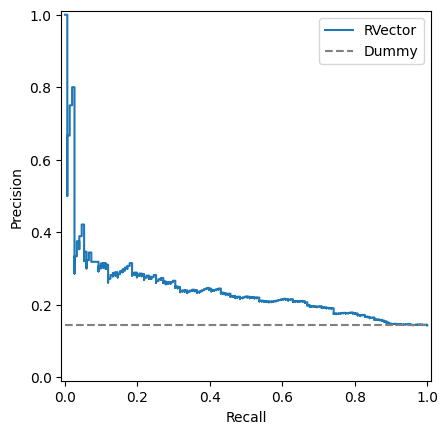

In [32]:
ax = plt.axes()

precision, recall, _ = precision_recall_curve(y_test, preds)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax, name='RVector')

random_classifier = np.mean(y_test)
plt.plot([0, 1], [random_classifier, random_classifier], linestyle='--', color='gray', label='Dummy')

plt.legend()

plt.show()